# 関数&クラス定義

## インポート

In [3]:
#関数やclassをまとめておく
#読み出すときは from function import * で読み込める
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns

# import
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time
#from tqdm import tqdm as tqdm
import numpy as np
import lightgbm as lgb
from sklearn import preprocessing as pre
import importlib
import matplotlib as mpl

import warnings
warnings.simplefilter('ignore')

## 関数

In [2060]:
#resultsの前処理
def preprocessing(results):
    df = results.copy()
    # 着順が数字以外のものを取り除く
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df.dropna(subset=['着順'], inplace=True)
    df['着順'] = df['着順'].astype(int)
    # 性齢を性と年齢にわける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
    # 馬体重を体重と増減にわける
    df['体重'] = df['馬体重(増減)'].str.split("(", expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重(増減)'].str.split("(", expand=True)[1].str[:-1].replace('前計不', '0').astype(int)
    #race_typeのカテゴリー変数を作成
    df['race_cat'] = df['place'] + df['race_type'] + df['course_len'].astype(str)
    df['枠番_cat'] = df['枠番'].astype(str)
    df['馬番_cat'] = df['馬番'].astype(str)
    # タイムを秒数に変換(教師に使う)
    df['タイム(秒)'] = df['タイム'].str.split(":", expand=True)[0].astype(float) * 60 + df['タイム'].str.split(":", expand=True)[1].astype(float)
    # 型変換
    df['枠番'] = df['枠番'].astype(int)
    df['馬番'] = df['馬番'].astype(int)
    df['斤量'] = df['斤量'].astype(float) 
    df['単勝'] = df['単勝'].astype(float)
    df['5th_prize'] = df['5th_prize'].astype(int)
    df['人気'] = df['人気'].astype(int)
    df['head_count'] = df['head_count'].astype(int)
    df['course_len'] = df['course_len'].astype(float)
    for i in range(len(df)):
        df['date'].iloc[i] = df['date'].iloc[i].replace('/', '月')
        if '日' not in df['date'].iloc[i]:
            df['date'].iloc[i] = df['date'].iloc[i] + '日'
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    #df.drop(['日付'], axis=1, inplace=True)

    df['タイム/len'] = df['タイム(秒)'] / df['course_len']
    # 不要な列を削除
    df.drop(['性齢'], axis=1, inplace=True)
    df.drop(['馬体重(増減)'], axis=1, inplace=True)
    df.drop(['タイム'], axis=1, inplace=True)
    df.drop(['着差'], axis=1, inplace=True)
    #df.drop(['騎手'], axis=1, inplace=True)
    df.drop(['調教師'], axis=1, inplace=True)
    df.drop(['厩舎'], axis=1, inplace=True)
    #df.drop(['着差', '調教師', 'ﾀｲﾑ指数', '通過', '上り', '調教ﾀｲﾑ','厩舎ｺﾒﾝﾄ', '備考', '賞金(万円)'], axis=1, inplace=True)

    return df

def split_data(df, test_size):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(
        len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(
        len(sorted_id_list) * (1 - test_size)):]

    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)

    return train, test

#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

#正規化
def normalize(df, normalize_df, i=1, PRINT=False):
    ss = pre.MinMaxScaler()
    result = df.copy()
    race_id_list = result.index.unique()
    for race_id in tqdm(race_id_list):
        target = result.loc[race_id][list(normalize_df.columns)]
        target_standardization = pd.DataFrame(ss.fit_transform(target), index=target.index, columns=target.columns)
        target_standardization = target_standardization.add_prefix('正規化_')
        target_standardization = round(target_standardization,10)
        if i == 1:
            for feature_name in target_standardization.columns:
                #まずメインdfに新しい正規化の名前を追加
                result[feature_name] = 0.0
                result.loc[race_id,[feature_name]] = target_standardization[[feature_name]]
                if PRINT:
                    print(feature_name)
                i = 2
        else:
            for feature_name in target_standardization.columns:
                result.loc[race_id,[feature_name]] = target_standardization[[feature_name]]

    return result

def update_data(old, new):
    filterd_old = old[~old.index.isin(new.index)]
    
    return pd.concat([filterd_old, new])

def gain(return_func, X, n_samples, threshold, odds, min_expectation = 0.5, max_expectation=10):
    #横軸:かけた枚数, 縦軸return_rate, hitrate
    gain_Average_number_of_bets_R = {}
    gain_Average_number_of_bets_H = {}
    gain_expectation_R = {}
    gain_expectation_H = {}
    N_count = 0
    odds = 0
    for k in tqdm(range(n_samples)):
        #期待値を変化させる
        expectation = max_expectation * (k / n_samples) + min_expectation * (1-(k/n_samples))
        
        #その条件での, 結果を取得
        Average_number_of_bets, return_rate, hit_rate, _, _ = return_func(X, N_count, threshold, expectation)
        
        #1レースに何頭賭けているかに変更
        gain_Average_number_of_bets_R[Average_number_of_bets] = return_rate
        gain_Average_number_of_bets_H[Average_number_of_bets] = hit_rate
        gain_expectation_R[expectation] = return_rate
        gain_expectation_H[expectation] = hit_rate

    return pd.Series(gain_Average_number_of_bets_R), pd.Series(gain_expectation_R),\
            pd.Series(gain_Average_number_of_bets_H), pd.Series(gain_expectation_H)

## 馬クラス

In [5]:
#HORSECLASS
class HorseResults:
    # このクラスを作った時に実行される関数
    # self. → このクラスの という意味
    def __init__(self, horse_results):
        self.horse_results = horse_results.copy()
        #self.horse_results = horse_results[['日付', '着順', '賞金', '騎手', '距離', '着差', '上り']]
        self.preprocessing()

    def preprocessing(self):
        df = self.horse_results.copy()
        df.fillna({'頭数': 0.0, '枠番': 0.0, '人気': 0.0, '賞金': 0.0,'着順': 0.0, '馬体重': 0.0}, inplace=True)
        
        # 着順が数字以外のものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        
        #df['頭数'] = df['頭数'].astype(str).astype(int)
        
        #日付をdatetimeに変換
        df['date'] = pd.to_datetime(df['日付'])

        # 距離をrace_typeとcourse_lenにわける
        df['race_type'] = df['距離'].map(lambda x: str(x)[0])
        df['course_len'] = df['距離'].map(lambda x: str(x)[1:]).astype(int)

        # 賞金のNaNを0でうめる
        df['賞金'].fillna(0, inplace=True)
        
        # 型変換
        df['着順'] = df['着順'].astype(int)
        df['頭数'] = df['頭数'].astype(int)
        df['枠番'] = df['枠番'].astype(int)
        df['人気'] = df['人気'].astype(int)
        
        # 馬体重を体重と増減にわける
        #df['体重'] = df['馬体重'].str.split("(", expand=True)[0].astype(int)
        df['体重'] = df['馬体重'].str.split("(", expand=True)[0]
        #df['体重変化'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1].astype(int)
        df['体重変化'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1]
        
        #いらないのを消す
        df.drop(['日付'], axis=1, inplace=True)
        df.drop(['距離'], axis=1, inplace=True)
        df.drop(['馬体重'], axis=1, inplace=True)

        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        # 一日で走る馬だけに絞る
        #target_df = self.horse_results.loc[horse_id_list]
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去データ(n_samplesまで)にしぼる
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]\
            [['天気', '頭数', '枠番', '馬番', 'オッズ', '人気' , '着順' ,'騎手', '馬場', '着差', '上り', '体重','体重変化', '賞金', 'date', 'race_type' , 'course_len']]
            
        elif n_samples > 1:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)\
            [['天気', '頭数', '枠番', '馬番', 'オッズ', '人気' , '着順' ,'騎手', '馬場', '着差', '上り', '体重','体重変化','賞金', 'date', 'race_type' , 'course_len']]
            
        elif n_samples == 1:
            pre_race = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(1)[['date']]
            return pre_race.rename(columns={'date': 'pre_date'})
        else:
            raise Exception('n_samples must be > 0')

        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        average = average.rename(columns={'着順': '着順平均_{}R'.format(n_samples), '賞金': '獲得賞金平均_{}R'.format(n_samples)})
        
        if n_samples == 5:
            #filtered_df.drop(['date'], axis=1)
            for column in filtered_df.columns:
                #print(column)
                pre_race_df = filtered_df.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
                pre_race_df = pre_race_df.str.split(',', expand=True).add_prefix('{}_'.format(column))
                average = average.merge(pre_race_df, left_index=True, right_index=True, how='left')
            
            average = average.rename(columns = {'着差_0': '前走着差', '上り_0': '前走上り', '騎手_0': '前走騎手', 'course_len_0': 'pre_course_len'})

        return average

    def merge(self, results, date, n_samples='all'):
        # くっつけたいデータを日付で絞り込む
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df

    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

## 騎手クラス

In [6]:
#JOCKEYCLASS
class JockeyResults:
    # このクラスを作った時に実行される関数
    # self. → このクラスの という意味
    def __init__(self, jockey_results_thisyear, jockey_results_allyear):
        self.jockey_results_thisyear = jockey_results_thisyear[['日付', '着順', '賞金(万円)', '距離', '着差', '上り']]
        self.jockey_results_allyear = jockey_results_allyear.drop(['代表馬'], axis=1)
        self.preprocessing()

    def preprocessing(self):
        df = self.jockey_results_thisyear.copy()
        df2 = self.jockey_results_allyear.copy()
        # 着順が数字以外のものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        # 着順を0,1化
        df['着順_01'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        #日付
        df['date'] = pd.to_datetime(df['日付'])
        #df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
        df.drop(['日付'], axis=1, inplace=True)

        # 距離をrace_typeとcourse_lenにわける
        df['pre_race_type'] = df['距離'].map(lambda x: str(x)[0])
        df['course_len'] = df['距離'].map(lambda x: str(x)[1:]).astype(int)
        df.drop(['距離'], axis=1, inplace=True)

        # 賞金のNaNを0でうめる
        df['賞金(万円)'].fillna(0, inplace=True)

        self.jockey_results_thisyear = df
        self.jockey_results_allyear = df2

    def results_year(self, jockey_id_list, date, n_samples):
        # 過去データ(騎手の年度成績)にしぼる
        target_df = self.jockey_results_allyear.query('index in @jockey_id_list')
        
        year = pd.to_datetime(date).year
        # 過去データ(去年までのデータ)にしぼる
        #target_df = target_df[target_df['年度'] != '出走']
        target_df = target_df[target_df['年度'] != '累計'].astype(float)
        #print(target_df.info())
        
        three_year_target_df = target_df[target_df['年度']< year].groupby(level=0).head(3)
        last_year_target_df = three_year_target_df.groupby(level=0).head(1)

        average = three_year_target_df.groupby(level=0)[['勝率', '連対率', '複勝率', '収得賞金(万円)']].mean()
        average.rename(columns={'勝率': '勝率_3Y', '連対率': '連対率_3Y', '複勝率': '複勝率_3Y', '収得賞金(万円)': '収得賞金(万円)_3Y'},inplace=True)
        
        last_year_target_df.rename(columns={'勝率': '勝率_1Y', '連対率': '連対率_1Y', '複勝率': '複勝率_1Y', '収得賞金(万円)': '収得賞金(万円)_1Y'},inplace=True)
        last_year_target_df.rename(columns={'順位': '順位_1Y', '1着': '1着_1Y', '2着': '2着_1Y', '3着': '3着_1Y','着外':'着外_1Y'},inplace=True)
        last_year_target_df.rename(columns={'重賞_出走': '重賞_出走_1Y', '重賞_勝利': '重賞_勝利_1Y', '特別_出走': '特別_出走_1Y', '特別_勝利': '特別_勝利_1Y'},inplace=True)
        last_year_target_df.rename(columns={'平場_出走': '平場_出走_1Y', '平場_勝利': '平場_勝利_1Y', '芝_出走': '芝_出走_1Y', '芝_勝利': '芝_勝利_1Y'},inplace=True)
        last_year_target_df.rename(columns={'ダート_出走': 'ダート_出走_1Y', 'ダート_勝利': 'ダート_勝利_1Y', '芝_出走': '芝_出走_1Y', '芝_勝利': '芝_勝利_1Y'},inplace=True)

        pre_race_merge = average.merge(last_year_target_df, left_index=True, right_index=True, how='left')
        pre_race_merge.drop(['年度'],axis=1,inplace=True)
        
        # 過去データ(騎手の近走成績)にしぼる
#         target_df2 = self.jockey_results_thisyear.query('index in @jockey_id_list')
#         filtered_df2 = target_df2[target_df2['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
#         filtered_df2.drop(['date'], axis=1, inplace=True)
#         print(target_df2)
#         average2 = filtered_df2.groupby(level=0)[['着順', '賞金(万円)', '着差', '上り', '着順_01']].mean()
#         average2 = average2.rename(columns={'着順': '騎手着順平均_{}R'.format(n_samples), '賞金(万円)': '騎手獲得賞金平均_{}R'.format(n_samples),\
#                                           '着差': '騎手着差平均_{}R'.format(n_samples), '上り': '騎手上り平均_{}R'.format(n_samples), \
#                                           '着順_01': '騎手着順_01平均_{}R'.format(n_samples)})
        
#         for column in filtered_df2.columns:
#             pre_race_df = filtered_df2.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
#             pre_race_df = pre_race_df.str.split(',', expand=True).add_prefix('騎手近走_{}_'.format(column))
#             average2 = average2.merge(pre_race_df, left_index=True, right_index=True, how='left')    
            
#         pre_race_merge_final = pre_race_merge.merge(average2, left_index=True, right_index=True, how='left')
        
        return pre_race_merge

    def merge(self, results, date, n_samples):
        # くっつけたいデータを日付で絞り込む
        df = results[results['date'] == date]
        jockey_id_list = df['jockey_id']
        merged_df = df.merge(self.results_year(jockey_id_list, date, n_samples), left_on='jockey_id', right_index=True, how='left')
        return merged_df

    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        merged_df[['勝率_3Y','連対率_3Y', '複勝率_3Y', '収得賞金(万円)_3Y', '1着_1Y', '2着_1Y', '3着_1Y', '着外_1Y', \
                   '重賞_出走_1Y','重賞_勝利_1Y', '特別_出走_1Y', '特別_勝利_1Y', '平場_出走_1Y', '平場_勝利_1Y', \
                   '芝_出走_1Y', '芝_勝利_1Y', 'ダート_出走_1Y','ダート_勝利_1Y', '勝率_1Y', '連対率_1Y', '複勝率_1Y', '収得賞金(万円)_1Y']] \
        = merged_df[['勝率_3Y','連対率_3Y', '複勝率_3Y', '収得賞金(万円)_3Y', '1着_1Y', '2着_1Y', '3着_1Y', '着外_1Y', '重賞_出走_1Y','重賞_勝利_1Y',\
                     '特別_出走_1Y', '特別_勝利_1Y', '平場_出走_1Y', '平場_勝利_1Y', '芝_出走_1Y', '芝_勝利_1Y', 'ダート_出走_1Y','ダート_勝利_1Y', \
                     '勝率_1Y', '連対率_1Y','複勝率_1Y', '収得賞金(万円)_1Y']].fillna(0).astype(float)

        return merged_df


## 払い戻しクラス

In [622]:
#払戻金CLASS
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables

    # 変数みたいに使える
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        # brでわける → 第２回
        wins = fukusho[1].str.split('br', expand=True).drop([3], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        returns = fukusho[2].str.split('br', expand=True).drop([3], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる

    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        wins = tansho[1].str.split('br', expand=True).drop([1], axis=1)
        wins.columns = ['win']

        returns = tansho[2].str.split('br', expand=True).drop([1], axis=1)
        returns.columns = ['return']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる

    @property
    def san_renpuku(self):
        san_renpuku = self.return_tables[self.return_tables[0] == '三連複'][[1, 2]]

        wins = san_renpuku[1].str.split('br', expand=True).drop([1], axis=1)
        wins = wins[0].str.split('-', expand=True)
        wins.columns = ['win_0', 'win_1', 'win_2']

        returns = san_renpuku[2].str.split('br', expand=True).drop([1], axis=1)
        returns.columns = ['return']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる
    
    @property
    def san_rentan(self):
        san_rentan = self.return_tables[self.return_tables[0] == '三連単'][[1, 2]]

        wins = san_rentan[1].str.split('br', expand=True).drop([1], axis=1)
        wins = wins[0].str.split('→', expand=True)
        wins.columns = ['win_0', 'win_1', 'win_2']

        returns = san_rentan[2].str.split('br', expand=True).drop([1], axis=1)
        returns.columns = ['return']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる
        
    # 変数みたいに使える
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0] == 'ワイド'][[1, 2]]
        # brでわける → 第２回
        temp = wide[1].str.split('br', expand=True).drop([3,4], axis=1)
        wins0 = temp[0].str.split('-', expand=True)
        wins1 = temp[1].str.split('-', expand=True)
        wins2 = temp[2].str.split('-', expand=True)
        wins = pd.concat([wins0, wins1, wins2], axis=1)
        #wins = wins[1].str.split('-', expand=True).drop([3], axis=1)
        #wins = wins[2].str.split('-', expand=True).drop([3], axis=1)
        wins.columns = ['win_0_0', 'win_0_1', 'win_1_0','win_1_1', 'win_2_0', 'win_2_1']
        
        returns = wide[2].str.split('br', expand=True).drop([3,4], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1, 2]]

        wins = umaren[1].str.split('br', expand=True).drop([1], axis=1)
        wins = wins[0].str.split('-', expand=True)
        wins.columns = ['win_0', 'win_1']

        returns = umaren[2].str.split('br', expand=True).drop([1], axis=1)
        returns.columns = ['return_0']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる
        
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0] == '馬単'][[1, 2]]

        wins = umatan[1].str.split('br', expand=True).drop([1], axis=1)
        wins = wins[0].str.split('→', expand=True)
        wins.columns = ['win_0', 'win_1']

        returns = umatan[2].str.split('br', expand=True).drop([1], axis=1)
        returns.columns = ['return_0']
        df = pd.concat([wins, returns], axis=1)
        for columns in df.columns:
            df[columns] = df[columns].str.replace(',', '')
        return df.fillna(0).astype(int)
        # axis = 1で横に繋がる, 最初は=0で縦につながる

## モデル評価クラス

In [2110]:
############################# Model Evaluator クラス##################################
#入力, 学習積みのモデルと, 払い戻しテーブル
class ModelEvaluator:
    def __init__(self, model, return_tables, TYPE='Nomal', std=True, Umaban=True, Tansho=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.san_renpuku = Return(return_tables).san_renpuku
        self.san_rentan = Return(return_tables).san_rentan
        self.wide = Return(return_tables).wide
        self.umaren = Return(return_tables).umaren
        self.umatan = Return(return_tables).umatan
        self.std = std
        self.TYPE = TYPE
        self.umaban = Umaban
        self.Tansho = Tansho

    def predict_proba(self, X):
        if self.TYPE=='Ensemble':
            y_pred = pd.Series(self.model.predict_proba(X,num_iteration=self.model.best_iteration_)[:, 1], index=X.index)
            
        elif self.TYPE=='LambdaRank':
            y_pred = pd.Series(self.model.predict(X,num_iteration=self.model.best_iteration), index=X.index)
            
        elif self.TYPE=='Regression':
            y_pred = pd.Series(self.model.predict(X,num_iteration=self.model.best_iteration), index=X.index)
        
        else:
            y_pred = pd.Series(self.model.predict_proba(X,num_iteration=self.model.best_iteration_)[:, 1], index=X.index)
            
        if self.std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            y_pred = y_pred.groupby(level=0).transform(standard_scaler)
            y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
            
        return y_pred
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]

    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))

    def feature_importances(self, X, n_display=20):
        importances = pd.DataFrame(
            {"features": X.columns, "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]

    
    
    def pred_table_single(self, X, N_count, threshold, odds, expectation, bet_only=True):
        # []だけならSeries, [[]]ならDataFrame
        pred_table = X.copy()[['馬番', '単勝']]
        
        #X(予測に用いるデータ)に元々'馬番'があるかどうか, アンサンブル学習などはないため, 予測にはdropする必要がある
        if self.umaban == False and self.Tansho == False:
            pred_table['pred'] = self.predict_proba(X.drop(['馬番','単勝'],axis=1))
        elif self.umaban == False and self.Tansho == True:
            #馬番がもともとなく, 追加しているならば
            pred_table['pred'] = self.predict_proba(X.drop(['馬番'],axis=1))
        elif self.umaban == True and self.Tansho == False:
            #単勝オッズがもともとなく, 追加しているならば
            pred_table['pred'] = self.predict_proba(X.drop(['単勝'],axis=1))
        else:
            pred_table['pred'] = self.predict_proba(X)
        
        if bet_only:
            if N_count != 0:
                #頭数関係あるときは, まず頭数で選ぶ
                pred_table = pred_table[pred_table.groupby(level=0)["pred"].rank(ascending=False)<=N_count]
                
            #期待値で絞り込み
            pred_table['expectation'] = pred_table['pred'] * pred_table['単勝']
            
            #予測スコアで絞り込み
            pred_table = pred_table[pred_table['pred'] >= threshold]
            #単勝オッズで絞り込み
            pred_table = pred_table[pred_table['単勝'] >= odds]
            #期待値で絞り込み
            pred_table = pred_table[pred_table['expectation'] >= expectation]
            pred_table = pred_table.rename(columns={'馬番':'馬番_pred'})
                
            
        return pred_table

        
    def pred_table_multiple(self, X, N_count, threshold, odds, expectation, bet_only=True):
        
        pred_table = X.copy()[['馬番', '単勝']]
        #X(予測に用いるデータ)に元々'馬番'があるかどうか, アンサンブル学習などはないため, 予測にはdropする必要がある
        if self.umaban == False and self.Tansho == False:
            pred_table['pred'] = self.predict_proba(X.drop(['馬番','単勝'],axis=1))
        elif self.umaban == False and self.Tansho == True:
            #馬番がもともとなく, 追加しているならば
            pred_table['pred'] = self.predict_proba(X.drop(['馬番'],axis=1))
        elif self.umaban == True and self.Tansho == False:
            #単勝オッズがもともとなく, 追加しているならば
            pred_table['pred'] = self.predict_proba(X.drop(['単勝'],axis=1))
        else:
            pred_table['pred'] = self.predict_proba(X)
            
            
        if bet_only:
            if N_count != 0:
                #頭数関係あるときは, まず頭数で選ぶ
                pred_table = pred_table[pred_table.groupby(level=0)["pred"].rank(ascending=False)<=N_count]
            
            #予測スコアで絞り込み
            pred_table = pred_table[pred_table['pred'] >= threshold]
            #単勝オッズで絞り込み
            pred_table = pred_table[pred_table['単勝'] >= odds]
            #期待値で絞り込み
            pred_table['expectation'] = pred_table['pred'] * pred_table['単勝']
            pred_table = pred_table[pred_table['expectation'] >= expectation]
            pred_table = pred_table.rename(columns={'馬番':'馬番_pred'})
     
        df_dct = {}
        for i in pred_table.groupby(level=0):
            df_dct[i[0]] = i[1].values[:,:].reshape(1,-1)[0]  # valuesでnumpy配列にして、reshapeで1行に変換
            #print(df_dct)
            # {201905010402: array([[8.      , 0.783678, 7.      , 0.710182, 2.      , 0.470611]]), 201907010601: array([[15.      ,  0.758492, 11.      ,  0.722583, 10.      ,  0.704865]]), 201907010604: array([[ 7.      ,  0.834579, 14.      ,  0.773029, 11.      ,  0.659245]]), 201907010606: array([[5.      , 0.84976 , 4.      , 0.804972, 6.      , 0.801182]])}

        df_dct2 = {}
        for k,v in df_dct.items():   # pd.Seriesに変換
             df_dct2[k]=pd.Series(v)
        
        pred_table_multi = pd.DataFrame(df_dct2).T.fillna(0)
        #pred_table3 = pred_table3.dropna(axis=0)

        for column in pred_table_multi:
            #print(column)
            columns_type = len(pred_table.columns)
            if column % columns_type == 0:
                pred_table_multi.rename(columns={column:'horse_{}'.format(column//columns_type)}, inplace=True)
                pred_table_multi['horse_{}'.format(column//columns_type)] = pred_table_multi['horse_{}'.format(column//columns_type)].astype(int)
            elif column % columns_type == 1:
                pred_table_multi.rename(columns={column:'odds_{}'.format(column//columns_type)}, inplace=True)
            elif column % columns_type == 2:
                pred_table_multi.rename(columns={column:'pred_{}'.format(column//columns_type)}, inplace=True)
            elif column % columns_type == 3:
                pred_table_multi.rename(columns={column:'expectation_{}'.format(column//columns_type)}, inplace=True)
        
        return pred_table_multi

    def fukusho_return(self, X, N_count, threshold, odds, expectation):
        pred_table = self.pred_table_single(X, N_count, threshold, odds, expectation)
        #賭けた枚数
        n_bets = len(pred_table)
        #1レースに賭けた平均枚数
        Average_number_of_bets = n_bets / len(X.index)
        money_initialize = n_bets * (-100)
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True,right_index=True, how='right')
        Hit_count = 0
        for i in range(3):
            money = money_initialize + df[df['win_{}'.format(i)] == df['馬番_pred']]['return_{}'.format(i)].sum()
            Hit_count += len(df[df['win_{}'.format(i)] == df['馬番_pred']])
        
        if n_bets==0:
            Hit_rate = 0
        else:
            Hit_rate = Hit_count / n_bets * 100
            
        Recovery_rate = (money - money_initialize)/ abs(money_initialize) * 100
        #1レースに賭けた平均枚数, 回収率 , 的中率, 初期投資, 最終払い戻し, 賭けた枚数
        return Average_number_of_bets, Recovery_rate, Hit_rate, money_initialize, money, n_bets
        #return df

    def tansho_return(self, X, N_count, threshold):
        pred_table = self.pred_table_single(X, N_count, threshold, odds, expectation)
        #賭けた枚数
        n_bets = len(pred_table)
        #1レースに賭けた平均枚数
        Average_number_of_bets = n_bets / len(X.index)
        money_initialize = n_bets * (-100)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        Hit_df = df[df['win'] == df['馬番_pred']]
        money = money_initialize + Hit_df['return'].sum()
        if n_bets==0:
            Hit_rate = 0
        else:
            Hit_rate = len(Hit_df) / n_bets * 100
        Recovery_rate = Hit_df['return'].sum() / abs(money_initialize) * 100
        
        return Average_number_of_bets, Recovery_rate, Hit_rate, money_initialize, money, n_bets
        #return df
        
    def tansho_return_proper(self, X, N_count, threshold, odds, expectation):
        #X_tansho = X[['馬番','単勝']]
        pred_table = self.pred_table_single(X, N_count, threshold, odds, expectation)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_bets = len(pred_table)
        #1レースに賭けた平均枚数
        Average_number_of_bets = n_bets / len(X.index)
        #そのなかで当たったもの
        Hit_df = df[(df['win'] == df['馬番_pred'])]

        if n_bets==0:
            Hit_rate = 0
        else:
            Hit_rate = len(Hit_df) / n_bets * 100
        
        #単勝適正回収値を計算
        money_initialize = -((100  * 10000 / (df['単勝'] * 100)).sum())

        money_payout = (100 * 10000 / (Hit_df['単勝']*100) * (Hit_df['return']/100)).sum()

        money = money_initialize + money_payout
        Recovery_rate = money_payout / (-money_initialize) * 100
        
        return Average_number_of_bets, Recovery_rate, Hit_rate, money_initialize, money, n_bets
        #return df
    
    def sanren_box_return(self, X, N_count, threshold, odds, expectation, sanrenpuku=True):
        #まず, returnを計算するのが, 三連複か三連単かで払い戻しが変わる
        if sanrenpuku:
            df = self.san_renpuku.copy()
        else:
            df = self.san_rentan.copy()
        
        #賭ける可能性のある馬一覧
        pred_table = self.pred_table_multiple(X, N_count, threshold, odds, expectation)
        
        '''
        掛ける馬
        '''
        #pred_tableにいくつcolumnの種類があるかカウント 
        column_count = 0
        for column in pred_table.columns.values:
            if '0' in column:
                column_count += 1
                
        #実際に賭けた枚数のトータル
        n_bets = 0
        N_count_df = pred_table.copy()
        Counted_race_count = 0
        #一番買い目が多いときの頭数
        max_horse_count = int(len(N_count_df.columns)/column_count)
        
        #賭ける通りを計算
        for i in range(0, max_horse_count):
            #何頭boxで購入するか　N_count=0→１頭も賭けない
            N_count = i
            #そのレースが何レースあるか → 初めて0が出てきたDataFrameの数
            race_count = len(N_count_df[N_count_df['horse_{}'.format(i)] == 0])
            Counted_race_count += race_count
            
            #賭ける枚数更新
            if N_count < 3:
                n_bets += 0
                #３頭以下のものは, 3連系は賭けられないので取り除く
                bet_df = N_count_df[N_count_df['horse_{}'.format(i)] != 0]
            elif sanrenpuku:
                n_bets += race_count * (N_count*(N_count-1)*(N_count-2) / 6)
            else:
                n_bets += race_count *(N_count*(N_count-1)*(N_count-2))
                
            N_count_df = N_count_df[N_count_df['horse_{}'.format(i)] != 0]
            
            #最後に処理
            if i == max_horse_count-1:
                #最後まで,0が出てこなかったら
                N_count = max_horse_count
                race_count = len(pred_table) - Counted_race_count
                if sanrenpuku:
                    n_bets += race_count * (N_count*(N_count-1)*(N_count-2) / 6)
                else:
                    n_bets += race_count *(N_count*(N_count-1)*(N_count-2))
        
        '''
        払い戻し金計算
        '''
        #bet_df(実際に3連系が賭けられるもの)だけを払い戻しと組み合わせる
        merge_df = df.merge(bet_df, left_index=True, right_index=True, how='right')
        
        #馬番順に並んでいる→ここから
        merge_df['bool_0'] = False
        merge_df['bool_1'] = False
        merge_df['bool_2'] = False
        for i in range(3):
            for k in range(0, max_horse_count):
                #mask関数, Trueの要素を変更可能
                merge_df['bool_{}'.format(i)].mask((merge_df['win_{}'.format(i)] == merge_df['horse_{}'.format(k)]) &\
                                                   (merge_df['bool_{}'.format(i)] == False), True, inplace=True)
                
        #Hit_df = merge_df[merge_df['bool_0'] == True & merge_df['bool_1'] == True & merge_df['bool_2'] == True]
        Hit_df = merge_df.query('bool_0 == True & bool_1 == True & bool_2 == True')
        
        money_initialize = n_bets * (-100)
        money = money_initialize + Hit_df['return'].sum()
        
        #1レースに賭けた平均枚数
        Average_number_of_bets = n_bets / len(X.index)
        #回収率
        Recovery_rate = Hit_df['return'].sum() / (-money_initialize) * 100
        #的中率
        if n_bets==0:
            Hit_rate = 0
        else:
            Hit_rate = len(Hit_df) / n_bets * 100
        
        #1レースに賭けた平均枚数, 回収率 , 的中率, 初期投資, 最終払い戻し, 賭けた枚数
        return Average_number_of_bets, Recovery_rate, Hit_rate, money_initialize, money, n_bets
    

In [2111]:
me2 = ModelEvaluator(lgb_rank2, return_tables, TYPE='Nomal', std=False, Umaban = True, Tansho=False)  # モデルを決める
me_12_2 = ModelEvaluator(lgb_rank_12_2, return_tables, TYPE='Nomal', std=False, Umaban = True, Tansho=False)  # モデルを決める
me_LR_std = ModelEvaluator(LRmodel, return_tables, TYPE='LambdaRank', std=True, Umaban = True, Tansho=False)  # モデルを決める

In [2112]:
me2.sanren_box_return(X_test2_V, N_count =0 , threshold=0.5, odds=0, expectation=1.0, sanrenpuku=False)

(1.3730787290655815,
 78.19038825433738,
 0.7853999954403483,
 -8772600,
 -1913270,
 87726)

In [2113]:
me2.sanren_box_return(X_test2_V, N_count = 3, threshold=0., odds=0, expectation=1.0, sanrenpuku=False)

(0.4358428549068712,
 84.84486102133161,
 1.282051282051282,
 -2784600,
 -422010,
 27846)

In [2114]:
me_12_2.sanren_box_return(X_test2_V, N_count = 0 , threshold=0.5, odds=0, expectation=1.0, sanrenpuku=False)

(0.16810142432305525,
 97.86405959031657,
 1.3966480446927374,
 -1074000,
 -22940,
 10740)

In [2117]:
me_12_2.sanren_box_return(X_test2_V, N_count = 3, threshold=0., odds=0, expectation=1.0, sanrenpuku=False)

(0.38099859132884645,
 74.97699449511133,
 1.2201133842740943,
 -2434200,
 -609110,
 24342)

In [1781]:
#me2.tansho
#me = ModelEvaluator(lgb_rank, return_tables, std=False)  # モデルを決める
# me_LR = ModelEvaluator(LRmodel, return_tables, TYPE='LambdaRank', std=False)  # モデルを決める
# me_LR_std = ModelEvaluator(LRmodel, return_tables, TYPE='LambdaRank', std=True)  # モデルを決める
# me_ensemble = ModelEvaluator(lgb_rank_AN, return_tables, TYPE='Ensemble', std=False)  # モデルを決める
# me_regression2 = ModelEvaluator(lgb_time2, return_tables, TYPE='Regression', std=False)  # モデルを決める
# me_regression2_std = ModelEvaluator(lgb_time2, return_tables, TYPE='Regression', std=True)  # モデルを決める

#me2.pred_table_multiple(X_test2, 3, 0)
#me_regression2.sanren_return(X_test2, N_count = 3, threshold = 0, sanrenpuku=False)
#me2.sanren_return(X_test2, N_count = 3, threshold = 0, sanrenpuku=True)
#me_LR.pred_table_N_count(X_test2, 3)
#me2.pred_table_multiple(X_test2, 0, threshold=0.5)
#me_LR_std.sanren_return(X_test2, N_count = 3, threshold=0, sanrenpuku=True)
#me2.tansho_return(X_test2, N_count = 10, threshold=0)
#me2.pred_table_single(X_test2, N_count = 0, threshold=0.5)
#me2.pred_table_single(X_test2_V, N_count = 0, threshold=0.5, expectation=3.0)
#me2.tansho_return_proper(X_test2_V, N_count = 0, threshold=0.5, expectation=3.0)
#A, B, C, D, E, F = gain_ReturnRate(me2.tansho_return_proper, X_test2_V)
#me2.predict_proba(X_test2)
#me2.predict(X_test2, threshold=0.8)
BR, ER, BH, EH  = gain(me2.tansho_return_proper, X_test2_V, 100, 0.5)
BR_12, ER_12, BH_12, EH_12 = gain(me_12_2.tansho_return_proper, X_test2_V, 100, 0.5)

In [1787]:
BR, ER, BH, EH  = gain_ReturnRate_expectation(me2.tansho_return_proper, X_train2_V, 100, 0.5)
BR_12, ER_12, BH_12, EH_12 = gain_ReturnRate_expectation(me_12_2.tansho_return_proper, X_train2_V, 100, threshold=0.5, odds=0)

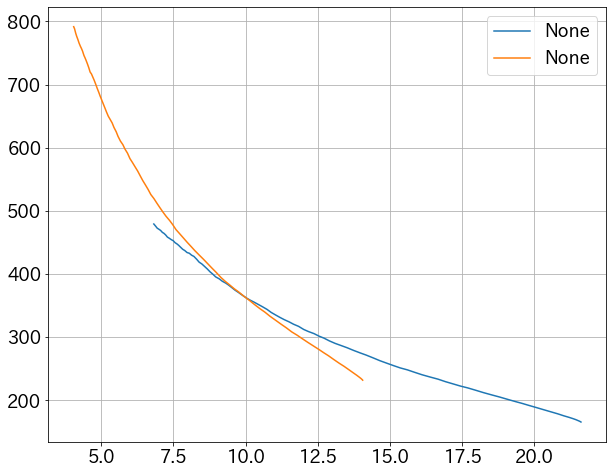

In [1788]:
#賭け数
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
#gain.rename('baseline').plot(legend=True)
BR.plot(legend=True)
BR_12.plot(legend=True)
plt.grid()

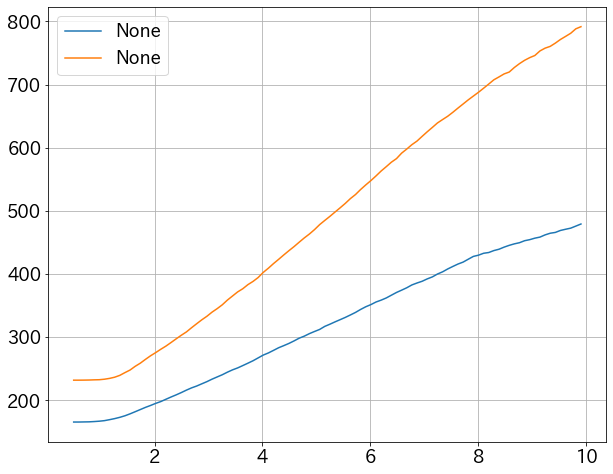

In [1789]:
#期待値
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
#gain.rename('baseline').plot(legend=True)
ER.plot(legend=True)
ER_12.plot(legend=True)
plt.grid()

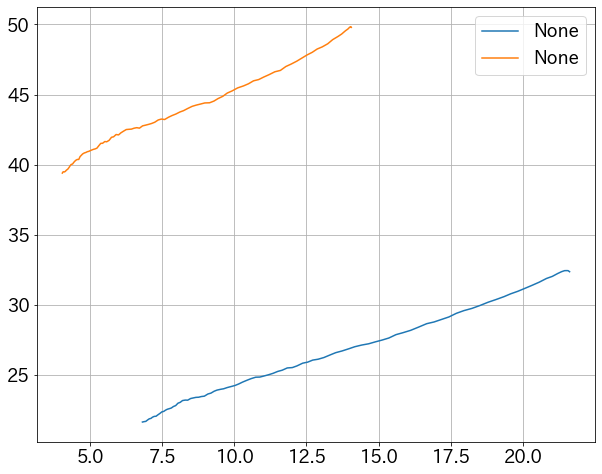

In [1790]:
#賭け数
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
#gain.rename('baseline').plot(legend=True)
BH.plot(legend=True)
BH_12.plot(legend=True)
plt.grid()

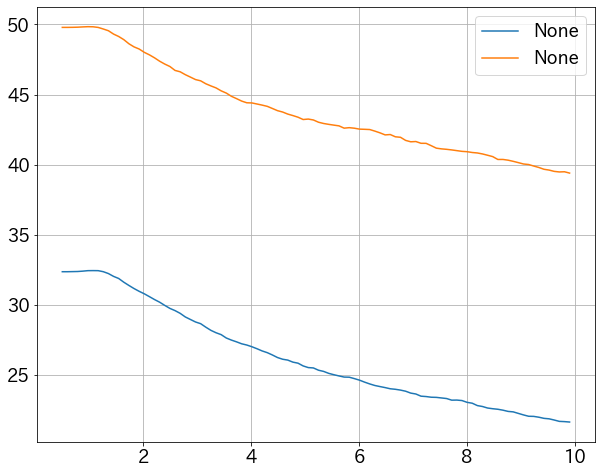

In [1791]:
#期待値
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
#gain.rename('baseline').plot(legend=True)
EH.plot(legend=True)
EH_12.plot(legend=True)
plt.grid()

## 当日関数

In [1000]:
########################################################################
#############################当日の予想の関数##############################
########################################################################

def sclape_race_info_today(race_id):
    ####################### 当日の馬柱 ###############################
    url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
    df = {}
    #df[race_id] = pd.read_html(url, header=0)[0].drop([0, 1, 2], axis=0).drop(['お気に入り馬', 'Unnamed: 9', '人気'], axis=1)
    df[race_id] = pd.read_html(url, header=0)[0].drop([0], axis=0).drop(['Unnamed: 9','印','お気に入り馬','お気に入り馬.1', '人気'], axis=1)
    
    for key in df.keys():
        df[key].index = [key] * len(df[key])
    results_df = pd.concat([df[key] for key in df.keys()], sort=False)
    
    ##################horse_IDとjocker_IDも入れられるようにする#################
    html = requests.get(url)
    html.encoding = 'EUC-JP'
    soup = BeautifulSoup(html.text, 'html.parser')
    horse_a_list = soup.find("div", attrs={"class": 'RaceTableArea'}).find_all('a', attrs={'href': re.compile("^https://db.netkeiba.com/horse")})
    # この中の数字だけ
    # horse_idリスト化
    horse_id_list = []
    for a in horse_a_list:
        horse_id = re.findall(r'\d+', a['href'])
        horse_id_list.append(horse_id[0])

    # jockey_id_list作成
    jockey_id_list = []
    jockey_a_list = soup.find("div", attrs={"class": 'RaceTableArea'}).find_all(
        'a', attrs={'href': re.compile("^https://db.netkeiba.com/jockey")})
    # この中の数字だけ
    # jockey_idリスト化
    for a in jockey_a_list:
        jockey_id = re.findall(r'\d+', a['href'])
        jockey_id_list.append(jockey_id[0])
    
    # results_dfに追加
    results_df["horse_id"] = horse_id_list
    results_df["jockey_id"] = jockey_id_list
    
    ################################# 脚質 #####################
    # horse_style
    url2 = 'https://race.netkeiba.com/race/shutuba_past.html?race_id=' + race_id + '&rf=shutuba_submenu'
    html = requests.get(url2)
    html.encoding = 'EUC-JP'
    soup = BeautifulSoup(html.text, 'html.parser')

    horse_style_list = []
    horse_style_a_list = soup.find_all("img", attrs={'src': re.compile("horse_race_type")})

    for a in horse_style_a_list:
        horse_style = re.findall(r'\d+', a['src'])
        horse_style_list.append(horse_style[1])
                
    results_df["horse_style"] = horse_style_list
    
    results_df['逃げ馬の数'] = len(results_df[results_df['horse_style'] == '01'])
    results_df['先行馬の数'] = len(results_df[results_df['horse_style'] == '02'])
    results_df['差し馬の数'] = len(results_df[results_df['horse_style'] == '03'])
    results_df['追込馬の数'] = len(results_df[results_df['horse_style'] == '04'])
    results_df['不明馬の数'] = len(results_df[results_df['horse_style'] == '05'])
    results_df['新馬の数'] = len(results_df[results_df['horse_style'] == '00'])
            
    df[race_id] = results_df

    #################################レースの情報#####################
    race_infos = {}
    date_Active = soup.find("dl", attrs={"id": 'RaceList_DateList'})
    date_No = race_id[:4] + '年' + \
        date_Active.find_all('dd', attrs={'class': 'Active'})[0].text
    date = date_No.split("(")[0]
    if date[6] in '/':
        date = date + '日'
        date = date.replace('/', '月')
    if date[7] in '/':
        date = date + '日'
        date = date.replace('/', '月')

    text = soup.find("div", attrs={"class": 'RaceList_Item02'}).text
    info = re.findall(r'\w+', text)
    # 見づらいからdataframeに
    info_dict = {}
    info_dict['date'] = date
    info_dict['race_name'] = info[0]
    for text in info:
        if '芝' in text:
            info_dict['race_type'] = '芝'
        if 'ダ' in text:
            info_dict['race_type'] = 'ダート'
        if '障' in text:
            info_dict['race_type'] = '障害'
        if 'm' in text:
            info_dict['course_len'] = int(re.findall(r'\d+', text)[0])
        if text in ['良', '稍重', '重', '不良']:
            info_dict['grand_state'] = text
        if '稍' in text:
            info_dict['grand_state'] = '稍重'
        if '不' in text:
            info_dict['grand_state'] = '不良'
        if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
            info_dict['weather'] = text
        if text in ['東京', '京都', '新潟', '阪神', '函館', '中京', '福島', '小倉', '札幌', '中山']:
            info_dict['place'] = text
        if text in ['右', '左', '直線']:
            info_dict['race_type_direction'] = text
        if '頭' in text:
            info_dict['head_count'] = int(re.findall(r'\d+', text)[0])
        if '万円' in text:
            info_dict['5th_prize'] = int(re.findall(r'\d+', text)[0])

    race_infos[race_id] = info_dict
    race_infos_pd = pd.DataFrame(race_infos).T
    # つなげる
    race_today = results_df.merge(race_infos_pd, left_index=True,
                                  right_index=True, how='inner')
    ################## 当日オッズと人気 予想urlからとる#################
    url = 'https://race.netkeiba.com/yoso/mark_list.html?race_id=' + \
        race_id + '&rf=race_list'
    html = requests.get(url)
    html.encoding = 'EUC-JP'
    soup = BeautifulSoup(html.text, 'html.parser')

    # オッズ
    odds_list = []
    # 人気
    popular_list = []
    odds_li_list = soup.find("div", attrs={"class": 'YosoTableWrap'}).find_all(
        'li', attrs={'class': 'Popular'})
    popular_li_list = soup.find("div", attrs={"class": 'YosoTableWrap'}).find_all(
        "li", attrs={'class': 'Txt_C'})

    for t in range(len(odds_li_list)):
        odds_list.append(odds_li_list[t].text)
        popular_list.append(
            popular_li_list[t - int(len(popular_li_list) / 3)].text)

    race_today["単勝"] = odds_list
    race_today["人気"] = popular_list
    return race_today


def sclape_Today_horse_pastresults(Today_result):
    # 当日の1レースのhorse_id, jockey_dから過去レースをスクレイピング(辞書型) → データフレーム化まで
    horse_results = {}
    horse_id_list = Today_result['horse_id'].unique()
    for horse_id in tqdm(horse_id_list):
        try:
            url = 'https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
            if df.columns[0] == '受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
            time.sleep(0.1)
        except IndexError:
            print("IndexError")
            continue
        except:
            # for文から抜け出す
            print("bleak")
            break
    # horseIDをindexにして, DataFrame化
    for key in horse_results.keys():
        horse_results[key].index = [key] * len(horse_results[key])

    horse_results = pd.concat([horse_results[key]
                               for key in horse_results.keys()], sort=False)
    return horse_results

def sclape_Today_jockey_pastresults(Today_result):
    jockey_results_thisyear = {}
    jockey_results_allyear = {}
    jockey_id_list = Today_result['jockey_id'].unique()
    for jockey_id in tqdm(jockey_id_list):
        if jockey_id in jockey_results_allyear.keys():
            continue
        try:
            url = 'https://db.netkeiba.com/jockey/' + jockey_id
            #近走
            df = pd.read_html(url)[0]


            url2 = 'https://db.netkeiba.com/jockey/result/' + jockey_id
            #年度
            df2 = pd.read_html(url2, header=0)[0]

            df2.rename(columns={'重賞':'重賞_出走','重賞.1':'重賞_勝利','平場':'平場_出走','平場.1':'平場_勝利','ダート':'ダート_出走','ダート.1':'ダート_勝利'}, inplace=True)
            df2.rename(columns={'特別':'特別_出走','特別.1':'特別_勝利','芝':'芝_出走','芝.1':'芝_勝利'}, inplace=True)
            df2.drop(df2.index[[0]], inplace=True)
            
            jockey_results_thisyear[jockey_id] = df
            jockey_results_allyear[jockey_id] = df2

            time.sleep(0.1)
        except IndexError:
            print("IndexError")
            continue
        except:
            # for文から抜け出す
            print("bleak")
            break

    for key in tqdm(jockey_results_thisyear.keys()):
        jockey_results_thisyear[key].index = [key] * len(jockey_results_thisyear[key])
    jockey_results_thisyear = pd.concat([jockey_results_thisyear[key] for key in tqdm(jockey_results_thisyear.keys())], sort=False)

    for key in tqdm(jockey_results_allyear.keys()):
        jockey_results_allyear[key].index = [key] * len(jockey_results_allyear[key])

    jockey_results_allyear = pd.concat([jockey_results_allyear[key] for key in tqdm(jockey_results_allyear.keys())], sort=False)

    return jockey_results_thisyear, jockey_results_allyear

def sclape_peds_today(Today_results, pre_peds={}, pre_horse_top={}):
    horse_id_list = Today_results['horse_id'].unique()
    peds = pre_peds
    horse_top = pre_horse_top
    for horse_id in tqdm(horse_id_list):
        if horse_id in peds.keys():
            continue
        try:
            url = 'https://db.netkeiba.com/horse/ped/' + horse_id
            df = pd.read_html(url)[0]
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i]
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
                
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            
            url2 = 'https://db.netkeiba.com/horse/' + horse_id
            horse_top[horse_id] = pd.read_html(url2)[1].set_index(0).T.reset_index(drop=True)
            time.sleep(0.1)
        except IndexError:
            print("IndexError")
            continue
        except Exception as e:
            print(e)
            # for文から抜け出す
            print("bleak")
            break

    peds_df = pd.concat([peds[horse_id] for horse_id in peds], axis=1).T.add_prefix('peds_')
    
    for key in horse_top.keys():
        horse_top[key].index = [key] * len(horse_top[key])

    horse_top_df = pd.concat([horse_top[key] for key in horse_top.keys()], sort=False)
    
    
    peds_final = peds_df.merge(horse_top_df, left_index=True, right_index=True, how='left')
    return peds_final


def preprocessing_today(results):
    df = results.copy()
    # 性齢を性と年齢にわける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
    # 馬体重を体重と増減にわける
    df['体重'] = df['馬体重(増減)'].str.split("(", expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重(増減)'].str.split("(", expand=True)[1].str[:-1].replace('前計不', '0').astype(int)
    # 枠のcolumn名変更
    df['枠番'] = df['枠'].astype(int)
    # 調教師を場所と名前に分ける
    #df['調教師_場所'] = df['調教師'].str.split("]", expand=True)[0].str.split("[", expand=True)[1]
    #df['調教師名'] = df['調教師'].str.split("]", expand=True)[1]
    #race_typeのカテゴリー変数を作成
    df['race_cat'] = df['place'] + df['race_type'] + df['course_len'].astype(str)
    df['枠番_cat'] = df['枠番'].astype(str)
    df['馬番_cat'] = df['馬番'].astype(str)
    # 型変換
    df['枠番'] = df['枠番'].astype(int)
    df['馬番'] = df['馬番'].astype(int)
    df['斤量'] = df['斤量'].astype(float)
    df['単勝'] = df['単勝'].astype(float)
    df['5th_prize'] = df['5th_prize'].astype(int)
    df['人気'] = df['人気'].astype(int)
    df['head_count'] = df['head_count'].astype(int)
    df['course_len'] = df['course_len'].astype(float)
    for i in range(len(df)):
        df['date'].iloc[i] = df['date'].iloc[i].replace('/', '月')
        if '日' not in df['date'].iloc[i]:
            df['date'].iloc[i] = df['date'].iloc[i] + '日'
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    #df.drop(['日付'], axis=1, inplace=True)

    # 不要な列を削除
    df.drop(['性齢'], axis=1, inplace=True)
    df.drop(['馬体重(増減)'], axis=1, inplace=True)
    df.drop(['枠'], axis=1, inplace=True)
    df.drop(['厩舎'], axis=1, inplace=True)
    #df.drop(['騎手'], axis=1, inplace=True)
    #df.drop(['調教師'], axis=1, inplace=True)
    #df.drop(['着差', '調教師', 'ﾀｲﾑ指数', '通過', '上り', '調教ﾀｲﾑ','厩舎ｺﾒﾝﾄ', '備考', '賞金(万円)'], axis=1, inplace=True)
    return df

def fit_LabelEncoding(categorical_columns, training_df, Today_df):
    
    for column in tqdm(categorical_columns):
        df = Today_df.copy()
        le_column = LabelEncoder().fit(training_df[column].fillna('Na'))
        mask = df[column].isin(le_column.classes_)
        column_new_data = df[column].mask(mask).unique()
        le_column.classes_ = np.concatenate([le_column.classes_, column_new_data])
        df[column] = le_column.transform(df[column])
    
    # le_horse = LabelEncoder().fit(Today_you['horse_id'])
    # le_horse.classes_
    # Today_results_all_S['horse_id'].isin(le_horse.classes_)
    # mask = Today_results_all_S['horse_id'].isin(le_horse.classes_)
    # Today_results_all_S['horse_id'].mask(mask)
    # new_horse_id = Today_results_all_S['horse_id'].mask(mask).unique()
    # le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
    # le_horse.transform(Today_results_all_S['horse_id'])
    return df

def fit_dummy(categorical_columns, training_df, Today_df):
    df = Today_df.copy()
    fit_dummy_columns = []
    for i in training_df.select_dtypes(include=object).columns.tolist():
        if i not in categorical_columns:
            fit_dummy_columns.append(i)
            
    for column in tqdm(training_df[fit_dummy_columns].columns):
        #print(column)
        fit_type = training_df[column].dropna().unique()
        #NA = training_df[column].value_counts(dropna=False).index[0]
        df[column] = pd.Categorical(df[column], fit_type)
        
    df = pd.get_dummies(df, columns=fit_dummy_columns)
    
    
    # fit_dummy_columns = []
    # for i in results_all_S_rt.select_dtypes(include=object).columns.tolist():
    #     if i not in  categorical_columns:
    #         fit_dummy_columns.append(i)
    # fit_dummy_columns
    # weather = results_all_S_rt['weather'].unique()
    # sample = Today_results_all_S_dummy[fit_dummy_columns].copy()
    # sample['weather'] = pd.Categorical(sample['weather'], weather)
    # sample['weather']
    # pd.get_dummies(sample['weather'])
    return df
        

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# データ読み込み

In [476]:
race_results = pd.read_pickle('1-2-2results2015_2020.pickle')
horse_results = pd.read_pickle('1-4horse_results2015_2020.pickle')
jockey_results_thisyear = pd.read_pickle('1-8jockey_results_thisyear2015-2020.pickle')
jockey_results_allyear = pd.read_pickle('1-8jockey_results_allyear2015-2020.pickle')
peds = pd.read_pickle('1-11peds2015_2020.pickle')
return_tables = pd.read_pickle('1-12return_tables2015_2020.pickle')

In [477]:
#Past_race_results = pd.read_pickle('1-2results2015_2020.pickle')
# Past_horse_results = pd.read_pickle('1-4horse_results2015_2020.pickle')
# Past_horse_results.to_pickle('1-15horse_results2015_2020.pickle')
# Past_jockey_results_thisyear = pd.read_pickle('1-8jockey_results_thisyear2015-2020.pickle')
# Past_jockey_results_thisyear.to_pickle('1-15jockey_results_thisyear2015-2020.pickle')
# Past_jockey_results_allyear = pd.read_pickle('1-8jockey_results_allyear2015-2020.pickle')
# Past_jockey_results_allyear.to_pickle('1-15jockey_results_allyear2015-2020.pickle')
# Past_peds = pd.read_pickle('1-11peds2015_2020.pickle')
# Past_peds.to_pickle('1-15peds2015_2020.pickle')
#Past_return_tables = pd.read_pickle('1-12return_tables2015_2020.pickle')

In [478]:
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

In [362]:
# race_results['差し馬の数'] = 0
# race_results['新馬の数'] = 0
# race_id_list = race_results.index.unique()
# for race_id in tqdm(race_id_list):
#     race_results.loc[race_id]['差し馬の数'] = len(race_results.loc[race_id][race_results.loc[race_id]['horse_style'] == '03'])
#     race_results.loc[race_id]['新馬の数'] = len(race_results.loc[race_id][race_results.loc[race_id]['horse_style'] == '00'])

# データ前処理

In [500]:
#過去データの前処理
race_results_p = preprocessing(race_results)
#horse_classのインスタンス化
hr = HorseResults(horse_results)
#過去レースと馬の平均成績をmerge

race_results_Pre = hr.merge_all(race_results_p, n_samples=1)
results_5R = hr.merge_all(race_results_Pre, n_samples=5)
results_5R_9R = hr.merge_all(results_5R, n_samples=9)
results_5R_9R_all = hr.merge_all(results_5R_9R, n_samples='all')

In [501]:
#jockey_classのインスタンス化
jr = JockeyResults(jockey_results_thisyear, jockey_results_allyear)
#過去レースとジョッキー成績をmerge
results_5R_9R_all_jocky = jr.merge_all(results_5R_9R_all, n_samples=5)
#血統データを結合
results_5R_9R_all_jocky_peds = pd.merge(results_5R_9R_all_jocky, peds, left_on='horse_id', right_index=True, how='left')

In [502]:
results_all = results_5R_9R_all_jocky_peds.copy()

In [503]:
results_all.head(3)

,枠番,馬番,馬名,斤量,騎手,horse_id,jockey_id,horse_style,逃げ馬の数,先行馬の数,差し馬の数,追込馬の数,不明馬の数,新馬の数,着順,単勝,人気,date,race_name,race_type,course_len,race_type_direction,weather,grand_state,place,head_count,5th_prize,性,年齢,体重,体重変化,調教師_場所,調教師名,race_cat,枠番_cat,馬番_cat,タイム(秒),タイム/len,pre_date,着順平均_5R,獲得賞金平均_5R,天気_0,天気_1,天気_2,天気_3,天気_4,頭数_0,頭数_1,頭数_2,頭数_3,頭数_4,枠番_0,枠番_1,枠番_2,枠番_3,枠番_4,馬番_0,馬番_1,馬番_2,馬番_3,馬番_4,オッズ_0,オッズ_1,オッズ_2,オッズ_3,オッズ_4,人気_0,人気_1,人気_2,人気_3,人気_4,着順_0,着順_1,着順_2,着順_3,着順_4,前走騎手,騎手_1,騎手_2,騎手_3,騎手_4,馬場_0,馬場_1,馬場_2,馬場_3,馬場_4,前走着差,着差_1,着差_2,着差_3,着差_4,前走上り,上り_1,上り_2,上り_3,上り_4,体重_0,体重_1,体重_2,体重_3,体重_4,体重変化_0,体重変化_1,体重変化_2,体重変化_3,体重変化_4,賞金_0,賞金_1,賞金_2,賞金_3,賞金_4,date_0,date_1,date_2,date_3,date_4,race_type_0,race_type_1,race_type_2,race_type_3,race_type_4,pre_course_len,course_len_1,course_len_2,course_len_3,course_len_4,着順平均_9R,獲得賞金平均_9R,着順平均_allR,獲得賞金平均_allR,勝率_3Y,連対率_3Y,複勝率_3Y,収得賞金(万円)_3Y,順位_1Y,1着_1Y,2着_1Y,3着_1Y,着外_1Y,重賞_出走_1Y,重賞_勝利_1Y,特別_出走_1Y,特別_勝利_1Y,平場_出走_1Y,平場_勝利_1Y,芝_出走_1Y,芝_勝利_1Y,ダート_出走_1Y,ダート_勝利_1Y,勝率_1Y,連対率_1Y,複勝率_1Y,収得賞金(万円)_1Y,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,peds_10,peds_11,peds_12,peds_13,peds_14,peds_15,peds_16,peds_17,peds_18,peds_19,peds_20,peds_21,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61,生年月日,調教師,馬主,生産者,産地,セリ取引価格,獲得賞金,通算成績,主な勝鞍,近親馬,募集情報
201503010101,1,1,アルボルデヴィダ,51.0,木幡初,2012105329,01153,03,4,2,6,1,0,2,11,66.0,12,2015-04-11,3歳未勝利,ダート,1700.0,右,雨,重,福島,15,50,牝,3,468,-6,西,飯田祐史,福島ダート1700,1,1,109.4,0.064353,2015-01-11,10.800000,0.0,曇,晴,晴,曇,晴,14,16,16,12,16,4,8,7,2,2,5,16,13,2,3,182.9,368.5,78.5,48.9,6.9,13,14,11,9,4,7,12,10,12,13,川島信二,川島信二,川島信二,池添謙一,池添謙一,稍,良,稍,良,良,1.8,3.3,2.4,3.4,2.4,39.3,39.7,38.2,39.4,36.9,474,480,486,472,478,-6,-6,+14,-6,0,0.0,0.0,0.0,0.0,0.0,2015-01-11,2014-12-27,2014-12-06,2014-07-19,2014-07-12,ダ,ダ,ダ,芝,芝,1800,1800,1400,1800,1200,10.800000,0.0,10.800000,0.0,0.028000,0.076000,0.127000,19453.400000,64.0,12.0,21.0,22.0,377.0,1.0,0.0,28.0,0.0,403.0,12.0,186.0,5.0,246.0,7.0,0.028,0.076,0.127,19453.4,ジャイアントレッカー Giant Wrecker(米) 2002 栗毛 [血統][産駒] S...,ロングパイル 2002 鹿毛 [血統][産駒] FNo.[4-r],Giant's Causeway (米) 1997 栗毛 [血統][産駒],Homewrecker 1983 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],ロングマサユメ 1989 鹿毛 [血統][産駒],Storm Cat (米) 1983 [血統][産駒],Mariah's Storm 1991 [血統][産駒],Buckaroo 1975 [血統][産駒],Execution 1975 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],キャンペンガール 1987 鹿毛 [血統][産駒],アレミロード Allez Milord(米) 1983 鹿毛 [血統][産駒],コルトニー 1977 鹿毛 [血統][産駒],Storm Bird 1978 鹿毛,Terlingua 1976,Rahy 1985 栗毛,イメンス 1979 黒鹿毛,Buckpasser 1963 鹿毛,Stepping High 1969,The Axe 1958 芦毛,House of Cards 1969,Halo 1969,Wishing Well 1975,マルゼンスキー 1974 鹿毛,レディーシラオキ 1978 鹿毛,Tom Rolfe 1962 鹿毛,Why Me Lord 1974,ラバージョン 1971 栗毛,オキノコトブキ 1969 鹿毛,Northern Dancer,South Ocean,Secretariat,Crimson Saint,Blushing Groom,Glorious Song,Roberto,Imsodear,Tom Fool,Busanda,No Robbery,Bebop,Mahmoud,Blackball,Promised Land,Carolwood,Hail to Reason,Cosmah,Understanding,Mountain Flower,Nijinsky,シル,セントクレスピン,ミスアシヤガワ,Ribot,Pocahontas,Bold Reasoning,Tomorrowland,Damascus,Evening Primrose,アイアンリージ,ハイビスカス,2012年3月14日,飯田祐史 (栗東),泉一郎,高野牧場,浦河町,-,135万円 (地方),41戦3勝 [3-2-4-32],3歳C1,ウインウェルス、ジャイアントスター,NaN
201503010101,2,2,エスプリドパリ,54.0,吉田隼,2012104348,01095,00,4,2,6,1,0,2,13,11.4,4,2015-04-11,3歳未勝利,ダート,1700.0,右,雨,重,福島,15,50,牝,3,514,0,西,吉村圭司,福島ダート1700,2,2,110.8,0.065176,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083667,0.174333,0.247667,95477.166667,18.0,52.0,57.0,42.0,452.0,15.0,1.0

## 特徴量整形

In [504]:
seri = results_all['セリ取引価格']
seri = seri.fillna('0万円(年)')
seri = seri.replace('-', '0万円(年)')
seri_money = seri.str.split("万円", expand=True)[0]

for a in tqdm(range(len(seri_money))):
    if ',' in seri_money[a]:
        seri_money[a] = seri_money[a].replace(',','')
    if '億' in seri_money[a]:
        seri_money[a] = seri_money[a].replace('億','')

In [1016]:
#0埋め, 欠損値埋め
results_all.fillna({'race_type_direction': '障害', 'race_type_0': 'なし','前走騎手': 'なし', 'セリ取引価格':'0.0万円'}, inplace=True)
results_all.fillna({'着順平均_5R': 0.0, '賞金平均_5R': 0.0, '着順平均_9R': 0.0, '賞金平均_9R': 0.0,'着順平均_allR': 0.0, '賞金平均_allR': 0.0} ,inplace=True)
results_all.fillna({'pre_course_len': 0, 'course_len_1': 0, 'course_len_2': 0, 'course_len_3': 0,'course_len_4': 0} ,inplace=True)
results_all.fillna({'頭数_0': 0, '頭数_1': 0, '頭数_2': 0, '頭数_3': 0,'頭数_4': 0} ,inplace=True)
results_all.fillna({'枠番_0': 0, '枠番_1': 0, '枠番_2': 0, '枠番_3': 0,'枠番_4': 0} ,inplace=True)
results_all.fillna({'馬番_0': 0, '馬番_1': 0, '馬番_2': 0, '馬番_3': 0,'馬番_4': 0} ,inplace=True)
results_all.fillna({'オッズ_0': 0, 'オッズ_1': 0, 'オッズ_2': 0, 'オッズ_3': 0,'オッズ_4': 0} ,inplace=True)
results_all.fillna({'人気_0': 0, '人気_1': 0, '人気_2': 0, '人気_3': 0,'人気_4': 0} ,inplace=True)
results_all.fillna({'着順_0': 0, '着順_1': 0, '着順_2': 0, '着順_3': 0,'着順_4': 0} ,inplace=True)
results_all.fillna({'前走着差': 0, '着差_1': 0, '着差_2': 0, '着差_3': 0,'着差_4': 0} ,inplace=True)
results_all.fillna({'前走上り': 0, '上り_1': 0, '上り_2': 0, '上り_3': 0,'上り_4': 0} ,inplace=True)
results_all.fillna({'体重_0': 0, '体重_1': 0, '体重_2': 0, '体重_3': 0,'体重_4': 0} ,inplace=True)
results_all.fillna({'体重変化_0': 0, '体重変化_1': 0, '体重変化_2': 0, '体重変化_3': 0,'体重変化_4': 0} ,inplace=True)
results_all.fillna({'賞金_0': 0, '賞金_1': 0, '賞金_2': 0, '賞金_3': 0,'賞金_4': 0} ,inplace=True)
results_all.fillna({'pre_course_len': 0, 'course_len_1': 0, 'course_len_2': 0, 'course_len_3': 0,'course_len_4': 0} ,inplace=True)
results_all.fillna({'date_0': '2050-01-01', 'date_1': '2050-01-01', 'date_2': '2050-01-01', 'date_3':'2050-01-01','date_4': '2050-01-01'} ,inplace=True)
#型変換
results_all['pre_course_len'] = results_all['pre_course_len'].astype(float)
results_all[['頭数_0', '頭数_1', '頭数_2', '頭数_3', '頭数_4']] = results_all[['頭数_0', '頭数_1', '頭数_2', '頭数_3', '頭数_4']].astype(int)
results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']] = results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']].astype(int)
results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']] = results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']].astype(int)
results_all[['オッズ_0', 'オッズ_1', 'オッズ_2', 'オッズ_3', 'オッズ_4']] = results_all[['オッズ_0', 'オッズ_1', 'オッズ_2', 'オッズ_3', 'オッズ_4']].astype(float)
results_all[['人気_0', '人気_1', '人気_2', '人気_3', '人気_4']] = results_all[['人気_0', '人気_1', '人気_2', '人気_3', '人気_4']].astype(int)
results_all[['着順_0', '着順_1', '着順_2', '着順_3', '着順_4']] = results_all[['着順_0', '着順_1', '着順_2', '着順_3', '着順_4']].astype(int)
results_all[['前走着差', '着差_1', '着差_2', '着差_3', '着差_4']] = results_all[['前走着差', '着差_1', '着差_2', '着差_3', '着差_4']].astype(float)
results_all[['前走上り', '上り_1', '上り_2', '上り_3', '上り_4']] = results_all[['前走上り', '上り_1', '上り_2', '上り_3', '上り_4']].astype(float)
results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']] = results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']].replace('計不', '0')
results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']] = results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']].astype(int)
results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']] = results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']].replace('None', '0')
results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']] = results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']].astype(int)
results_all[['賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4']] = results_all[['賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4']].astype(float)
results_all[['pre_course_len', 'course_len_1', 'course_len_2', 'course_len_3', 'course_len_4']] = results_all[['pre_course_len', 'course_len_1', 'course_len_2', 'course_len_3', 'course_len_4']].astype(float)
results_all['date_0'] = pd.to_datetime(results_all['date_0'])
results_all['date_1'] = pd.to_datetime(results_all['date_1'])
results_all['date_2'] = pd.to_datetime(results_all['date_2'])
results_all['date_3'] = pd.to_datetime(results_all['date_3'])
results_all['date_4'] = pd.to_datetime(results_all['date_4'])
results_all['枠番'] = results_all['枠番'].astype(int)
results_all['馬番'] = results_all['馬番'].astype(int)
results_all['斤量'] = results_all['斤量'].astype(float)
#新しい列作成
results_all['jockey_change'] = ~(results_all['騎手'] == results_all['前走騎手'])
results_all['セリ場所'] = seri.str.split("万円", expand=True)[1].str.split("年", expand=True)[1].str.split(")", expand=True)[0].replace('', 'なし')
results_all['セリ取引価格(万円)'] = seri_money.astype(int)
results_all['dif_len'] = results_all['course_len'] - results_all['pre_course_len'].astype(int)
results_all['調教師_場所'] = results_all['調教師'].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
results_all['調教師名'] = results_all['調教師'].str.split("(", expand=True)[0]
#新しい列作成 (予想)
results_all['rank'] = results_all['着順'].map(lambda x: 1 if x < 4 else 0)
results_all['lambdarank'] = results_all['着順'].map(lambda x: 1 if x < 4 else 4)
results_all['lambdarank2'] = results_all['着順'].map(lambda x: int(1.0/x*10) if x < 4 else 0)
results_all['-着順']= -results_all['着順']
results_all['rank1_2']= results_all['着順'].map(lambda x: 1 if x < 3 else 0)

results_all = pd.concat([results_all, results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']].astype(str).add_suffix('_cat')], axis=1)
results_all = pd.concat([results_all, results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']].astype(str).add_suffix('_cat')], axis=1)

#予測に使わないデータをdrop
results_all.drop(['騎手','馬名','生年月日','獲得賞金' ,'通算成績', '主な勝鞍' ,'近親馬','募集情報','セリ取引価格'], axis=1, inplace=True)
results_all.drop(['調教師'],axis=1, inplace=True)

KeyError: '騎手'

In [506]:
results_all.head(3)

,枠番,馬番,斤量,horse_id,jockey_id,horse_style,逃げ馬の数,先行馬の数,差し馬の数,追込馬の数,不明馬の数,新馬の数,着順,単勝,人気,date,race_name,race_type,course_len,race_type_direction,weather,grand_state,place,head_count,5th_prize,性,年齢,体重,体重変化,調教師_場所,調教師名,race_cat,枠番_cat,馬番_cat,タイム(秒),タイム/len,pre_date,着順平均_5R,獲得賞金平均_5R,天気_0,天気_1,天気_2,天気_3,天気_4,頭数_0,頭数_1,頭数_2,頭数_3,頭数_4,枠番_0,枠番_1,枠番_2,枠番_3,枠番_4,馬番_0,馬番_1,馬番_2,馬番_3,馬番_4,オッズ_0,オッズ_1,オッズ_2,オッズ_3,オッズ_4,人気_0,人気_1,人気_2,人気_3,人気_4,着順_0,着順_1,着順_2,着順_3,着順_4,前走騎手,騎手_1,騎手_2,騎手_3,騎手_4,馬場_0,馬場_1,馬場_2,馬場_3,馬場_4,前走着差,着差_1,着差_2,着差_3,着差_4,前走上り,上り_1,上り_2,上り_3,上り_4,体重_0,体重_1,体重_2,体重_3,体重_4,体重変化_0,体重変化_1,体重変化_2,体重変化_3,体重変化_4,賞金_0,賞金_1,賞金_2,賞金_3,賞金_4,date_0,date_1,date_2,date_3,date_4,race_type_0,race_type_1,race_type_2,race_type_3,race_type_4,pre_course_len,course_len_1,course_len_2,course_len_3,course_len_4,着順平均_9R,獲得賞金平均_9R,着順平均_allR,獲得賞金平均_allR,勝率_3Y,連対率_3Y,複勝率_3Y,収得賞金(万円)_3Y,順位_1Y,1着_1Y,2着_1Y,3着_1Y,着外_1Y,重賞_出走_1Y,重賞_勝利_1Y,特別_出走_1Y,特別_勝利_1Y,平場_出走_1Y,平場_勝利_1Y,芝_出走_1Y,芝_勝利_1Y,ダート_出走_1Y,ダート_勝利_1Y,勝率_1Y,連対率_1Y,複勝率_1Y,収得賞金(万円)_1Y,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,peds_10,peds_11,peds_12,peds_13,peds_14,peds_15,peds_16,peds_17,peds_18,peds_19,peds_20,peds_21,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61,馬主,生産者,産地,jockey_change,セリ場所,セリ取引価格(万円),dif_len,rank,lambdarank,lambdarank2,-着順,rank1_2,枠番_0_cat,枠番_1_cat,枠番_2_cat,枠番_3_cat,枠番_4_cat,馬番_0_cat,馬番_1_cat,馬番_2_cat,馬番_3_cat,馬番_4_cat
201503010101,1,1,51.0,2012105329,01153,03,4,2,6,1,0,2,11,66.0,12,2015-04-11,3歳未勝利,ダート,1700.0,右,雨,重,福島,15,50,牝,3,468,-6,栗東,飯田祐史,福島ダート1700,1,1,109.4,0.064353,2015-01-11,10.800000,0.0,曇,晴,晴,曇,晴,14,16,16,12,16,4,8,7,2,2,5,16,13,2,3,182.9,368.5,78.5,48.9,6.9,13,14,11,9,4,7,12,10,12,13,川島信二,川島信二,川島信二,池添謙一,池添謙一,稍,良,稍,良,良,1.8,3.3,2.4,3.4,2.4,39.3,39.7,38.2,39.4,36.9,474,480,486,472,478,-6,-6,14,-6,0,0.0,0.0,0.0,0.0,0.0,2015-01-11,2014-12-27,2014-12-06,2014-07-19,2014-07-12,ダ,ダ,ダ,芝,芝,1800.0,1800.0,1400.0,1800.0,1200.0,10.800000,0.0,10.800000,0.0,0.028000,0.076000,0.127000,19453.400000,64.0,12.0,21.0,22.0,377.0,1.0,0.0,28.0,0.0,403.0,12.0,186.0,5.0,246.0,7.0,0.028,0.076,0.127,19453.4,ジャイアントレッカー Giant Wrecker(米) 2002 栗毛 [血統][産駒] S...,ロングパイル 2002 鹿毛 [血統][産駒] FNo.[4-r],Giant's Causeway (米) 1997 栗毛 [血統][産駒],Homewrecker 1983 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],ロングマサユメ 1989 鹿毛 [血統][産駒],Storm Cat (米) 1983 [血統][産駒],Mariah's Storm 1991 [血統][産駒],Buckaroo 1975 [血統][産駒],Execution 1975 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],キャンペンガール 1987 鹿毛 [血統][産駒],アレミロード Allez Milord(米) 1983 鹿毛 [血統][産駒],コルトニー 1977 鹿毛 [血統][産駒],Storm Bird 1978 鹿毛,Terlingua 1976,Rahy 1985 栗毛,イメンス 1979 黒鹿毛,Buckpasser 1963 鹿毛,Stepping High 1969,The Axe 1958 芦毛,House of Cards 1969,Halo 1969,Wishing Well 1975,マルゼンスキー 1974 鹿毛,レディーシラオキ 1978 鹿毛,Tom Rolfe 1962 鹿毛,Why Me Lord 1974,ラバージョン 1971 栗毛,オキノコトブキ 1969 鹿毛,Northern Dancer,South Ocean,Secretariat,Crimson Saint,Blushing Groom,Glorious Song,Roberto,Imsodear,Tom Fool,Busanda,No Robbery,Bebop,Mahmoud,Blackball,Promised Land,Carolwood,Hail to Reason,Cosmah,Understanding,Mountain Flower,Nijinsky,シル,セントクレスピン,ミスアシヤガワ,Ribot,Pocahontas,Bold Reasoning,Tomorrowland,Damascus,Evening Primrose,アイアンリージ,ハイビスカス,泉一郎,高野牧場,浦河町,True,なし,0,-100.0,0,4,0,-11,0,4,8,7,2,2,5,16,13,2,3
201503010101,2,2,54.0,2012104348,01095,00,4,2,6,1,0,2,13,11.4,4,2015-04-11,3歳未勝利,ダート,1700.0,右,雨,重,福島,15,50,牝,3,514,0,栗東,吉村圭司,福島ダート1700,2,2,110.8,0.065176,NaT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2050-01-01,2050-01-01,2050-01-01,2050-01-01,2050-01-01,なし,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.000000,NaN,0.083667,0.1743

In [507]:
#results_all.to_pickle('1-15results_all_pre_S.pickle')
#results_all = pd.read_pickle('1-15results_all_pre_S.pickle')
#当日のために正規化前のデータを保存しておく
Today_you_pre_S = results_all.copy()

## 正規化

In [510]:
#レース内正規化したい変数を確保
normalize_df = results_all[['斤量','単勝','体重','体重変化','着順平均_5R','獲得賞金平均_5R',\
                            'オッズ_0' , 'オッズ_1' , 'オッズ_2' , 'オッズ_3','オッズ_4',\
                            '人気_0' , '人気_1' , '人気_2' , '人気_3','人気_4',\
                            '着順_0' , '着順_1' , '着順_2' , '着順_3','着順_4',\
                            '前走着差','着差_1', '着差_2' ,'着差_3', '着差_4',\
                            '前走上り','上り_1','上り_2','上り_3', '上り_4',\
                            '賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4',\
                            'pre_course_len', 'course_len_1' , 'course_len_2' ,'course_len_3' ,'course_len_4',\
                            '着順平均_9R', '獲得賞金平均_9R','着順平均_allR', '獲得賞金平均_allR',\
                            '勝率_3Y' , '連対率_3Y','複勝率_3Y' , '収得賞金(万円)_3Y',\
                            '順位_1Y'	,'1着_1Y','2着_1Y','3着_1Y', '着外_1Y' ,'重賞_出走_1Y' ,'重賞_勝利_1Y','特別_出走_1Y',\
                            '特別_勝利_1Y','平場_出走_1Y','平場_勝利_1Y' , '芝_出走_1Y' ,'芝_勝利_1Y', 'ダート_出走_1Y', 'ダート_勝利_1Y',\
                            '勝率_1Y',  '連対率_1Y', '複勝率_1Y', '収得賞金(万円)_1Y',\
                            'dif_len','タイム(秒)','タイム/len']]
len(normalize_df.columns)

71

In [511]:
results_all_normalize = normalize(results_all, normalize_df)

正規化_斤量
正規化_単勝
正規化_体重
正規化_体重変化
正規化_着順平均_5R
正規化_獲得賞金平均_5R
正規化_オッズ_0
正規化_オッズ_1
正規化_オッズ_2
正規化_オッズ_3
正規化_オッズ_4
正規化_人気_0
正規化_人気_1
正規化_人気_2
正規化_人気_3
正規化_人気_4
正規化_着順_0
正規化_着順_1
正規化_着順_2
正規化_着順_3
正規化_着順_4
正規化_前走着差
正規化_着差_1
正規化_着差_2
正規化_着差_3
正規化_着差_4
正規化_前走上り
正規化_上り_1
正規化_上り_2
正規化_上り_3
正規化_上り_4
正規化_賞金_0
正規化_賞金_1
正規化_賞金_2
正規化_賞金_3
正規化_賞金_4
正規化_pre_course_len
正規化_course_len_1
正規化_course_len_2
正規化_course_len_3
正規化_course_len_4
正規化_着順平均_9R
正規化_獲得賞金平均_9R
正規化_着順平均_allR
正規化_獲得賞金平均_allR
正規化_勝率_3Y
正規化_連対率_3Y
正規化_複勝率_3Y
正規化_収得賞金(万円)_3Y
正規化_順位_1Y
正規化_1着_1Y
正規化_2着_1Y
正規化_3着_1Y
正規化_着外_1Y
正規化_重賞_出走_1Y
正規化_重賞_勝利_1Y
正規化_特別_出走_1Y
正規化_特別_勝利_1Y
正規化_平場_出走_1Y
正規化_平場_勝利_1Y
正規化_芝_出走_1Y
正規化_芝_勝利_1Y
正規化_ダート_出走_1Y
正規化_ダート_勝利_1Y
正規化_勝率_1Y
正規化_連対率_1Y
正規化_複勝率_1Y
正規化_収得賞金(万円)_1Y
正規化_dif_len
正規化_タイム(秒)
正規化_タイム/len



## 正規化後ちょっとした処理

In [519]:
#正規化後
results_all_S = results_all_normalize.copy()
#新しい列を追加　3着衣内に入った馬のみのtime
results_all_S['正規化_タイム/len123'] = 1.0
results_all_S['正規化_タイム/len12'] = 1.0
results_all_S['正規化_タイム(秒)123'] = 1.0
results_all_S['正規化_タイム(秒)12'] = 1.0

for num in tqdm(range(len(results_all_S))):
    if results_all_S['rank'].iloc[num] == 1:
        results_all_S['正規化_タイム/len123'].iloc[num] = results_all_S['正規化_タイム/len'].iloc[num]
        results_all_S['正規化_タイム(秒)123'].iloc[num] = results_all_S['正規化_タイム(秒)'].iloc[num]
        
    if results_all_S['rank1_2'].iloc[num] == 1:
        results_all_S['正規化_タイム/len12'].iloc[num] = results_all_S['正規化_タイム/len'].iloc[num]
        results_all_S['正規化_タイム(秒)12'].iloc[num] = results_all_S['正規化_タイム(秒)'].iloc[num]

## 複勝期待値の計算

In [591]:
#期待値計算のために, 払戻金情報を加工
fukusho = return_tables[return_tables[0] == '複勝'][[1, 2]]
# brでわける → 第２回
wins = fukusho[1].str.split('br', expand=True).drop([3], axis=1)
wins.columns = ['win_0', 'win_1', 'win_2']
returns = fukusho[2].str.split('br', expand=True).drop([3], axis=1)
returns.columns = ['return_0', 'return_1', 'return_2']
df_hukusho = pd.concat([wins, returns], axis=1)

for columns in df_hukusho.columns:
    df_hukusho[columns] = df_hukusho[columns].str.replace(',', '')

df_hukusho = df_hukusho.fillna(0).astype(int)

# axis = 1で横に繋がる, 最初は=0で縦につながる
#期待値計算後
results_all_S_rt = df_hukusho.merge(results_all_S, left_index=True,right_index=True, how='right')

#期待値複勝払い戻し
results_all_S_rt['Expected_value'] = 0
for num in tqdm(range(len(results_all_S_rt))):
    for i in range(3):
        if results_all_S_rt['馬番'].iloc[num] == results_all_S_rt['win_{}'.format(i)].iloc[num]:
            results_all_S_rt['Expected_value'].iloc[num] = results_all_S_rt['return_{}'.format(i)].iloc[num]
#複勝オッズ
results_all_S_rt['Expected_value/100']= results_all_S_rt['Expected_value'] / 100

## 日付データの整形

In [592]:
results_all_S_rt.drop(['pre_date'],axis=1, inplace=True)
results_all_S_rt['days_interval_0'] = (results_all_S_rt['date'] - results_all_S_rt['date_0']).astype(str).str.split("days", expand=True)[0].astype(int)
results_all_S_rt['days_interval01'] = (results_all_S_rt['date_0'] - results_all_S_rt['date_1']).astype(str).str.split("days", expand=True)[0].astype(int)
results_all_S_rt['days_interval12'] = (results_all_S_rt['date_1'] - results_all_S_rt['date_2']).astype(str).str.split("days", expand=True)[0].astype(int)
results_all_S_rt['days_interval23'] = (results_all_S_rt['date_2'] - results_all_S_rt['date_3']).astype(str).str.split("days", expand=True)[0].astype(int)
results_all_S_rt['days_interval34'] = (results_all_S_rt['date_3'] - results_all_S_rt['date_4']).astype(str).str.split("days", expand=True)[0].astype(int)

In [593]:
a = (results_all_S_rt['date'].dt.month.astype(str) + results_all_S_rt['date'].dt.day.astype(str)).astype(int)
b = (results_all_S_rt['date_0'].dt.month.astype(str) + results_all_S_rt['date_0'].dt.day.astype(str)).astype(int)
results_all_S_rt['season_cos'] = np.cos(2*np.pi * ((a - 101) / (1231 - 101)))
results_all_S_rt['season_cos_0'] = np.cos(2*np.pi * ((b - 101) / (1231 - 101)))

results_all_S_rt.drop(['date_0','date_1','date_2','date_3','date_4'],axis=1, inplace=True)

# 最終的なデータ

In [599]:
results_all_S_rt.head(3)

,win_0,win_1,win_2,return_0,return_1,return_2,枠番,馬番,斤量,horse_id,jockey_id,horse_style,逃げ馬の数,先行馬の数,差し馬の数,追込馬の数,不明馬の数,新馬の数,着順,単勝,人気,date,race_name,race_type,course_len,race_type_direction,weather,grand_state,place,head_count,5th_prize,性,年齢,体重,体重変化,調教師_場所,調教師名,race_cat,枠番_cat,馬番_cat,タイム(秒),タイム/len,着順平均_5R,獲得賞金平均_5R,天気_0,天気_1,天気_2,天気_3,天気_4,頭数_0,頭数_1,頭数_2,頭数_3,頭数_4,枠番_0,枠番_1,枠番_2,枠番_3,枠番_4,馬番_0,馬番_1,馬番_2,馬番_3,馬番_4,オッズ_0,オッズ_1,オッズ_2,オッズ_3,オッズ_4,人気_0,人気_1,人気_2,人気_3,人気_4,着順_0,着順_1,着順_2,着順_3,着順_4,前走騎手,騎手_1,騎手_2,騎手_3,騎手_4,馬場_0,馬場_1,馬場_2,馬場_3,馬場_4,前走着差,着差_1,着差_2,着差_3,着差_4,前走上り,上り_1,上り_2,上り_3,上り_4,体重_0,体重_1,体重_2,体重_3,体重_4,体重変化_0,体重変化_1,体重変化_2,体重変化_3,体重変化_4,賞金_0,賞金_1,賞金_2,賞金_3,賞金_4,race_type_0,race_type_1,race_type_2,race_type_3,race_type_4,pre_course_len,course_len_1,course_len_2,course_len_3,course_len_4,着順平均_9R,獲得賞金平均_9R,着順平均_allR,獲得賞金平均_allR,勝率_3Y,連対率_3Y,複勝率_3Y,収得賞金(万円)_3Y,順位_1Y,1着_1Y,2着_1Y,3着_1Y,着外_1Y,重賞_出走_1Y,重賞_勝利_1Y,特別_出走_1Y,特別_勝利_1Y,平場_出走_1Y,平場_勝利_1Y,芝_出走_1Y,芝_勝利_1Y,ダート_出走_1Y,ダート_勝利_1Y,勝率_1Y,連対率_1Y,複勝率_1Y,収得賞金(万円)_1Y,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,peds_10,peds_11,peds_12,peds_13,peds_14,peds_15,peds_16,peds_17,peds_18,peds_19,peds_20,peds_21,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61,馬主,生産者,産地,jockey_change,セリ場所,セリ取引価格(万円),dif_len,rank,lambdarank,lambdarank2,-着順,rank1_2,枠番_0_cat,枠番_1_cat,枠番_2_cat,枠番_3_cat,枠番_4_cat,馬番_0_cat,馬番_1_cat,馬番_2_cat,馬番_3_cat,馬番_4_cat,正規化_斤量,正規化_単勝,正規化_体重,正規化_体重変化,正規化_着順平均_5R,正規化_獲得賞金平均_5R,正規化_オッズ_0,正規化_オッズ_1,正規化_オッズ_2,正規化_オッズ_3,正規化_オッズ_4,正規化_人気_0,正規化_人気_1,正規化_人気_2,正規化_人気_3,正規化_人気_4,正規化_着順_0,正規化_着順_1,正規化_着順_2,正規化_着順_3,正規化_着順_4,正規化_前走着差,正規化_着差_1,正規化_着差_2,正規化_着差_3,正規化_着差_4,正規化_前走上り,正規化_上り_1,正規化_上り_2,正規化_上り_3,正規化_上り_4,正規化_賞金_0,正規化_賞金_1,正規化_賞金_2,正規化_賞金_3,正規化_賞金_4,正規化_pre_course_len,正規化_course_len_1,正規化_course_len_2,正規化_course_len_3,正規化_course_len_4,正規化_着順平均_9R,正規化_獲得賞金平均_9R,正規化_着順平均_allR,正規化_獲得賞金平均_allR,正規化_勝率_3Y,正規化_連対率_3Y,正規化_複勝率_3Y,正規化_収得賞金(万円)_3Y,正規化_順位_1Y,正規化_1着_1Y,正規化_2着_1Y,正規化_3着_1Y,正規化_着外_1Y,正規化_重賞_出走_1Y,正規化_重賞_勝利_1Y,正規化_特別_出走_1Y,正規化_特別_勝利_1Y,正規化_平場_出走_1Y,正規化_平場_勝利_1Y,正規化_芝_出走_1Y,正規化_芝_勝利_1Y,正規化_ダート_出走_1Y,正規化_ダート_勝利_1Y,正規化_勝率_1Y,正規化_連対率_1Y,正規化_複勝率_1Y,正規化_収得賞金(万円)_1Y,正規化_dif_len,正規化_タイム(秒),正規化_タイム/len,正規化_タイム/len123,正規化_タイム/len12,正規化_タイム(秒)123,正規化_タイム(秒)12,Expected_value,Expected_value/100,days_interval_0,days_interval01,days_interval12,days_interval23,days_interval34,season_cos,season_cos_0
201503010101,13,12,5,220,110,460,1,1,51.0,2012105329,01153,03,4,2,6,1,0,2,11,66.0,12,2015-04-11,3歳未勝利,ダート,1700.0,右,雨,重,福島,15,50,牝,3,468,-6,栗東,飯田祐史,福島ダート1700,1,1,109.4,0.064353,10.800000,0.0,曇,晴,晴,曇,晴,14,16,16,12,16,4,8,7,2,2,5,16,13,2,3,182.9,368.5,78.5,48.9,6.9,13,14,11,9,4,7,12,10,12,13,川島信二,川島信二,川島信二,池添謙一,池添謙一,稍,良,稍,良,良,1.8,3.3,2.4,3.4,2.4,39.3,39.7,38.2,39.4,36.9,474,480,486,472,478,-6,-6,14,-6,0,0.0,0.0,0.0,0.0,0.0,ダ,ダ,ダ,芝,芝,1800.0,1800.0,1400.0,1800.0,1200.0,10.800000,0.0,10.800000,0.0,0.028000,0.076000,0.127000,19453.400000,64.0,12.0,21.0,22.0,377.0,1.0,0.0,28.0,0.0,403.0,12.0,186.0,5.0,246.0,7.0,0.028,0.076,0.127,19453.4,ジャイアントレッカー Giant Wrecker(米) 2002 栗毛 [血統][産駒] S...,ロングパイル 2002 鹿毛 [血統][産駒] FNo.[4-r],Giant's Causeway (米) 1997 栗毛 [血統][産駒],Homewrecker 1983 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],ロングマサユメ 1989 鹿毛 [血統][産駒],Storm Cat (米) 1983 [血統][産駒],Mariah's Storm 1991 [血統][産駒],Buckaroo 1975 [血統][産駒],Execution 1975 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],キャンペンガール 1987 鹿毛 [血統][産駒],アレミロード Allez Milord(米) 1983 鹿毛 [血統][産駒],コルトニー 1977 鹿毛 [血統][産駒],Storm Bird 1978 鹿毛,Terlingua 1976,Rahy 1985 栗毛,イメンス 1979 黒鹿毛,Buckpasser 1963 鹿毛,Stepping High 1969,The Axe 1958 芦毛,House of Cards 1969,Halo 1969,Wishing Well 1975,マルゼンスキー 1974 鹿毛,レディーシラオキ 1978 鹿毛,Tom Rolfe 1962 鹿毛,Why Me Lord 1974,ラバージョン 1971 栗毛,オキノコ

In [595]:
results_all_S_rt.info(1)  # 最終的に使うデータ

<class 'pandas.core.frame.DataFrame'>
Index: 221444 entries, 201503010101 to 202001020301
Data columns (total 319 columns):
 #   Column               Dtype         
---  ------               -----         
 0   win_0                int64         
 1   win_1                int64         
 2   win_2                int64         
 3   return_0             int64         
 4   return_1             int64         
 5   return_2             int64         
 6   枠番                   int64         
 7   馬番                   int64         
 8   斤量                   float64       
 9   horse_id             object        
 10  jockey_id            object        
 11  horse_style          object        
 12  逃げ馬の数                int64         
 13  先行馬の数                int64         
 14  差し馬の数                int64         
 15  追込馬の数                int64         
 16  不明馬の数                int64         
 17  新馬の数                 int64         
 18  着順                   int64         
 19  単勝        

In [605]:
results_all_S_rt.columns

Index(['win_0', 'win_1', 'win_2', 'return_0', 'return_1', 'return_2', '着順',
       '枠番', '馬番', '斤量',
       ...
       '正規化_勝率_1Y', '正規化_連対率_1Y', '正規化_複勝率_1Y', '正規化_収得賞金(万円)_1Y',
       '正規化_dif_len', '正規化_タイム/len', '正規化_タイム/len123', '正規化_タイム/len12',
       'Expected_value', 'Expected_value/100'],
      dtype='object', length=305)

In [596]:
#results_all_S_rt.to_pickle('1-15results_all_S.pickle')
#results_all_S_rt = pd.read_pickle('1-15results_all_S.pickle')

# シミュレーション用にデータ加工

In [600]:
#一応のために残しておく
Today_you = results_all_S_rt.copy()

## LabelEncoding & ダミー変数化

In [601]:
#one-hot変換をしないカテゴリ変数化
categorical_columns = ['horse_id', 'jockey_id', 'race_name', '調教師名', '前走騎手', '騎手_1','騎手_2','騎手_3','騎手_4','馬主', '生産者', '産地'] + list(peds.columns)[:-11]

In [602]:
results_d = process_categorical(results_all_S_rt, categorical_columns)

In [627]:
#機械学習で予測するもの
predict_df = results_d[['着順','タイム(秒)','タイム/len','rank','lambdarank','lambdarank2','-着順','rank1_2','正規化_タイム/len','正規化_タイム/len123','正規化_タイム/len12','正規化_タイム(秒)123','正規化_タイム(秒)12','正規化_タイム(秒)', 'Expected_value','Expected_value/100']]

In [888]:
results_d.info(1)

<class 'pandas.core.frame.DataFrame'>
Index: 221444 entries, 201503010101 to 202001020301
Data columns (total 732 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   win_0                   int64         
 1   win_1                   int64         
 2   win_2                   int64         
 3   return_0                int64         
 4   return_1                int64         
 5   return_2                int64         
 6   枠番                      int64         
 7   馬番                      int64         
 8   斤量                      float64       
 9   horse_id                category      
 10  jockey_id               category      
 11  逃げ馬の数                   int64         
 12  先行馬の数                   int64         
 13  差し馬の数                   int64         
 14  追込馬の数                   int64         
 15  不明馬の数                   int64         
 16  新馬の数                    int64         
 17  着順                      int64      

In [630]:
train, test = split_data(results_d, 0.3)

In [1591]:
#トレーニングデータ
#train = train.drop(['pre_date'], axis=1)
X_train = train.drop(['win_0','win_1','win_2','return_0','return_1','return_2'] + list(predict_df.columns), axis=1)

X_train2 = X_train.drop(['単勝','正規化_単勝','人気'], axis=1)
X_train2_V = X_train.drop(['正規化_単勝','人気'], axis=1)

X_train3 = X_train2.drop(['体重','体重変化','正規化_体重','正規化_体重変化'], axis=1)

#回帰で予測
y_train_time = train['タイム/len']
y_train_time_ss = train['正規化_タイム/len']
y_train_odds = train['単勝']
y_train_EV = train['Expected_value/100']

#分類で予測
y_train_rank = train['rank']
y_train_rank12 = train['rank1_2']
y_train_lambdarank = train['lambdarank2']
#y_train_tyakujun = train['着順']

In [1592]:
# 検証用データ
#test = test.drop(['pre_date'], axis=1)
X_test = test.drop(['win_0','win_1','win_2','return_0','return_1','return_2'] + list(predict_df.columns), axis=1)

X_test2 = X_test.drop(['単勝','正規化_単勝','人気'], axis=1)
X_test2_V = X_test.drop(['正規化_単勝','人気'], axis=1)

X_test3 = X_test2.drop(['体重','体重変化','正規化_体重','正規化_体重変化'], axis=1)

#回帰で予測
y_test_time = test['タイム/len']
y_test_time_ss = test['正規化_タイム/len']
y_test_odds = test['単勝']
y_test_EV = test['Expected_value']

#分類で予測
y_test_rank = test['rank']
y_test_rank12 = test['rank1_2']
y_test_lambdarank = test['lambdarank2']
#y_test_tyakujun = test['着順']

# hold法でシミュレーション

## 各パラメータの指定

In [1566]:
# 各モデルのパラメータ
# hold time
# Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 
#'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.010899510271390668, 'lambda_l2': 0.7547846949717588,
#'num_leaves': 231, 'feature_fraction': 0.7, 'bagging_fraction': 0.5879928742235913, 'bagging_freq': 7, 'min_child_samples': 20}

#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 7.102282849428687e-07, 'lambda_l2': 4.328766750051105e-06, 'num_leaves': 255,
#'feature_fraction': 0.42, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
ht_params = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 100,
        'num_boost_round': 5000, # 最大試行数
        'early_stopping_rounds': 20, # この数分、連続でメトリックに変化なければ終了する
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'num_leaves': 255, # 枝葉の数
        'feature_fraction':0.42,
        'bagging_fraction':1.0,
        'bagging_freq':0,
        'min_child_samples':100,
        'verbosity':500
}
#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 
#'feature_pre_filter': False, 'lambda_l1': 0.0015879023971955395, 'lambda_l2': 9.824165167376433, 'num_leaves': 170, 'feature_fraction': 0.5, 
#'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
ht_params2 = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 100,
        'num_boost_round': 5000, # 最大試行数
        'early_stopping_rounds': 20, # この数分、連続でメトリックに変化なければ終了する
        'lambda_l1': 0.0,
        'lambda_l2': 10.0,
        'num_leaves': 170,
        'feature_fraction':0.5,
        'bagging_fraction':1.0,
        'bagging_freq':0,
        'min_child_samples':100,
        'verbosity':500
}

#hold ss time
#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 
#'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 1.445214568490942e-06, 'lambda_l2': 8.788122252259734,
 #               'num_leaves': 191, 'feature_fraction': 0.6, 
#'bagging_fraction': 0.9445259557597319, 'bagging_freq': 1, 'min_child_samples': 20}

#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 3.1213373594064984, 'lambda_l2': 0.0018497479540771078, 'num_leaves': 157, 'feature_fraction': 0.5,
 #                   'bagging_fraction': 1.0, 'bagging_freq': 0, 
#'min_child_samples': 20}
ht_ss_params = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 100,
        'num_boost_round': 5000, # 最大試行数
        'early_stopping_rounds': 20, # この数分、連続でメトリックに変化なければ終了する
        'lambda_l1': 3.0,
        'lambda_l2': 0.0,
        'num_leaves': 157,
        'feature_fraction':0.5,
        'bagging_fraction':1.0,
        'bagging_freq':0,
        'min_child_samples':20,
        'verbosity':500
}


#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 
#'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False, 
#'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 216, 'feature_fraction': 0.5, 
#               'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50}

#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 3.2421520529317256, 'lambda_l2': 7.557147030233436, 'num_leaves': 139, 'feature_fraction': 0.5,
#'bagging_fraction': 0.9600115254722352, 'bagging_freq': 2, 'min_child_samples': 10}
ht_ss_params2 = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 100,
        'num_boost_round': 5000, # 最大試行数
        'early_stopping_rounds': 20, # この数分、連続でメトリックに変化なければ終了する
        'lambda_l1': 3.2,
        'lambda_l2': 7.6,
        'num_leaves': 136,
        'feature_fraction':0.5,
        'bagging_fraction':0.9,
        'bagging_freq':2,
        'min_child_samples':10,
        'verbosity':500
}


# hold odds
#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced',
#'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 8.096565434966984e-07, 'lambda_l2': 2.1743817645120795e-06,
#'num_leaves': 36, 'feature_fraction': 1.0, 'bagging_fraction': 0.962316366385762, 'bagging_freq': 1, 'min_child_samples': 20}
ho_params = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 10,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'num_leaves': 36, # 枝葉の数
        'feature_fraction': 1.0,
        'bagging_fraction': 1.0,
        'bagging_freq': 1,
        'min_child_samples': 20,
        'random_seed': 100,
        'class_weight': "balanced"
}

#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 
#'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.8157147226352721, 
 #               'lambda_l2': 2.3455327722581552e-08, 'num_leaves': 254,
#'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.8564754343492987, 'bagging_freq': 1, 'min_child_samples': 100}

#Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 
#'feature_pre_filter': False, 'lambda_l1': 1.3650874347237714e-08, 'lambda_l2': 1.0223239724176367e-08, 
#'num_leaves': 256, 'feature_fraction': 0.42, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
ho_params2 = {
    'objective': 'regression',
        'learning_rate': 0.01, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'verbose': 10,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'num_leaves': 256, # 枝葉の数
        'feature_fraction': 0.42,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_child_samples': 100,
        'random_seed': 100,
        'class_weight': "balanced"
}

# hold rank
#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced',
#'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 9.047329475723911, 
#'lambda_l2': 0.0339505955905859, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
hr_params = {
    'lambda_l1':9.0,
    'lambda_l2':0.0,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.7,
    'bagging_fraction': 1.0,
    'class_weight': "balanced",
    'reg_lambda':0,
    'random_state': 100,
    'bagging_freq': 0,
    'objective': "binary",
    'min_child_samples':20
}

# hold rank2
#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 
#'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 1.131211222837394, 'lambda_l2': 8.073372376189376, 
#'num_leaves': 206, 'feature_fraction': 0.4, 'bagging_fraction': 0.8772120854187484, 'bagging_freq': 3, 'min_child_samples': 20}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced',
#'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.06054297431468179, 'lambda_l2': 9.259815348731308, 'num_leaves': 239, 
#'feature_fraction': 0.784, 'bagging_fraction': 0.8586910590952799, 'bagging_freq': 3, 'min_child_samples': 20}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 2.509070701220802e-07, 'lambda_l2': 6.5395988212625715,
#'num_leaves': 235, 'feature_fraction': 0.8, 'bagging_fraction': 0.9511618808095298, 'bagging_freq': 4, 'min_child_samples': 20}
hr2_params = {
    'lambda_l1':2.509070701220802e-07,
    'lambda_l2':6.5395988212625715,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 235,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.8,
    'bagging_fraction': 0.9511618808095298,
    'class_weight': "balanced",
    #'reg_lambda':0,
    'random_state': 100,
    'bagging_freq': 4,
    'objective': "binary",
    'min_child_samples':20
}

# hr2_params = {
#     'lambda_l1': 0.0,
#     'lambda_l2':0.0,
#     'max_depth':7,
#     'n_estimators': 100000,
#     'metric': 'binary_logloss',
#     'num_leaves': 55,
#     'learning_rate': 0.01, # 学習率
#     'feature_fraction':0.4,
#     'bagging_fraction': 1.0,
#     'class_weight': "balanced",
#     'random_state': 100,
#     'bagging_freq': 0,
#     'objective': "binary",
#     'min_child_samples':20
# }


#hold rank3 (体重, 変化なし, 当日データなし)
hr3_params = {
    'lambda_l1': 0.0,
    'lambda_l2':0.0,
    'max_depth':7,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 55,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.4,
    'bagging_fraction': 1.0,
    'class_weight': "balanced",
    'random_state': 100,
    'bagging_freq': 0,
    'objective': "binary",
    'min_child_samples':20
}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss',
#'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False,
 #               'lambda_l1': 8.668441087886217, 'lambda_l2': 9.677072661666184, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999,
#'bagging_fraction': 0.8414575562398672, 'bagging_freq': 1, 'min_child_samples': 20}
hr12_params = {
    'lambda_l1':9.0,
    'lambda_l2':1.0,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.9,
    'bagging_fraction': 0.9,
    'class_weight': "balanced",
    'reg_lambda':0,
    'random_state': 100,
    'bagging_freq': 1,
    'objective': "binary",
    'min_child_samples':20
}


#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 0.5794359791045445, 'lambda_l2': 8.885342254739667, 
#'num_leaves': 194, 'feature_fraction': 0.4, 'bagging_fraction': 1.0,
#            'bagging_freq': 0, 'min_child_samples': 20}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 
#'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False,
#                'lambda_l1': 1.0064701896962953, 'lambda_l2': 8.94598256069392, 'num_leaves': 141,
#'feature_fraction': 0.6, 'bagging_fraction': 0.8640997212821089, 'bagging_freq': 3, 'min_child_samples': 20}
hr12_params2 = {
    'lambda_l1':1.0,
    'lambda_l2':9.0,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 144,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.6,
    'bagging_fraction': 0.9,
    'class_weight': "balanced",
    'reg_lambda':0,
    'random_state': 100,
    'bagging_freq': 3,
    'objective': "binary",
    'min_child_samples':20
}

# Support Vector Classifier 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

#LambdaRank
max_position = 10
#Best Params: {'task': 'train', 'boosting_type': 'gbdt', 
#'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [1, 2, 3], 'max_position': 10, 'learning_rate': 0.01, 
                    #'random_state': 777, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 25,
#'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

LambdaRank_params =  {
    'task': 'train',
    'lambda_l1':0.0,
    'lambda_l2':0.0,
    'num_leaves':25,
    'feature_fraction':1.0,
    'bagging_fraction':1.0,
    'bagging_freq':0,
    'min_child_samples':20,
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',   # for lambdarank
    'ndcg_eval_at': [1,2,3],  # for lambdarank
    'max_position': max_position,  # for lambdarank
    'learning_rate': 0.01,
    'min_data': 1,
    'min_data_in_bin': 1,
    'min_data_in_leaf':1,
    'random_state': 777,
}

#Best Params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'lambdarank', 'metric': 'ndcg',
#'ndcg_eval_at': [1, 2, 3], 'max_position': 10, 'learning_rate': 0.01, 'min_data_in_bin': 1, 'random_state': 777,
#                    'feature_pre_filter': False, 'min_data_in_leaf': 1, 'lambda_l1': 0.0, 'lambda_l2': 0.0,
#'num_leaves': 3, 'feature_fraction': 0.48000000000000004, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

#Best Params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'lambdarank', 
#'metric': 'ndcg', 'ndcg_eval_at': [1, 2, 3], 'max_position': 10, 'learning_rate': 0.01, 'random_state': 777,
 #                   'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 99,
#'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

LambdaRank_params2 =  {
    'task': 'train',
    'lambda_l1':0.0,
    'lambda_l2':0.0,
    'num_leaves':99,
    'feature_fraction':0.6,
    'bagging_fraction':1.0,
    'bagging_freq':0,
    'min_child_samples':20,
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',   # for lambdarank
    'ndcg_eval_at': [1,2,3],  # for lambdarank
    'max_position': max_position,  # for lambdarank
    'learning_rate': 0.01,
    'min_data': 1,
    'min_data_in_bin': 1,
    'min_data_in_leaf':1,
    'random_state': 777,
}

#ensemble(アンサンブル)
#Best Params: {'lambda_l1': 0.0249378712470619, 'lambda_l2': 1.694636311814557e-05, 'num_leaves': 6, 
#'feature_fraction': 0.552, 'bagging_fraction': 0.9040038866235183, 'bagging_freq': 2, 
#'min_child_samples': 25, 'objective': 'binary', 'metric': 'binary_logloss', 
#'random_seed': 100, 'max_depth': 7, 'class_weight': 'balanced', 'learning_rate': 0.01}

#{'lambda_l1': 0.030165398369968465, 'lambda_l2': 0.061178251839245315,
#'num_leaves': 11, 'feature_fraction': 0.4, 'bagging_fraction': 0.8654072555891648, 
#'bagging_freq': 7, 'min_child_samples': 100, 'objective': 'binary', 'metric': 'binary_logloss',
#'random_seed': 100, 'max_depth': 7, 'class_weight': 'balanced', 'learning_rate': 0.01}

# Best Params: {'lambda_l1': 0.012775273067179137, 'lambda_l2': 1.0124616535636802e-08, 
#               'num_leaves': 37, 'feature_fraction': 0.41600000000000004, 
#               'bagging_fraction': 0.6209181050629136,
#               'bagging_freq': 2, 'min_child_samples': 20, 'objective': 'binary', 'metric': 
#               'binary_logloss', 
#               'random_seed': 100, 'max_depth': 7, 'class_weight': 'balanced', 'learning_rate': 0.01}

# Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100,
#'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 4.024670297714234, 'lambda_l2': 1.3676222638098474e-08, 
#'num_leaves': 2, 'feature_fraction': 0.516, 'bagging_fraction': 0.4877979249899945, 'bagging_freq': 7, 'min_child_samples': 50}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01,
#'feature_pre_filter': False, 'lambda_l1': 2.8580279159407054, 'lambda_l2': 0.010888796225680408, 
#'num_leaves': 221, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50}
ensemble_params123 = {
    'lambda_l1': 3.0,
    'lambda_l2':0.0,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 221,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.4,
    'bagging_fraction': 1.0,
    'class_weight': "balanced",
    'random_state': 100,
    'bagging_freq': 0,
    'objective': "binary",
    'min_child_samples':50
}

#Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 
#'feature_pre_filter': False, 'lambda_l1': 0.04885167012137911, 'lambda_l2': 0.00012462152361003356, 
#'num_leaves': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.4373443975902281, 'bagging_freq': 7, 'min_child_samples': 50}
ensemble_params12 = {
    'lambda_l1': 0.05,
    'lambda_l2':0.0,
    'max_depth':-1,
    'n_estimators': 100000,
    'metric': 'binary_logloss',
    'num_leaves': 5,
    'learning_rate': 0.01, # 学習率
    'feature_fraction':0.4,
    'bagging_fraction': 0.4,
    'class_weight': "balanced",
    'random_state': 100,
    'bagging_freq': 7,
    'objective': "binary",
    'min_child_samples':50
}

## タイム予測

In [1216]:
## LightGBM用の変数にデータセット
lgb_train = lgb.Dataset(X_train.values, y_train_time.values)
lgb_test = lgb.Dataset(X_test.values, y_test_time.values, reference=lgb_train)

lgb_train2 = lgb.Dataset(X_train2.values, y_train_time.values)
lgb_test2 = lgb.Dataset(X_test2.values, y_test_time.values, reference=lgb_train)

### タイム学習

In [1217]:
evaluation_results  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_time = lgb.train(#params,
                     ht_params,
                      lgb_train,
                      valid_sets = [lgb_train, lgb_test],
                      valid_names=['train', 'test'],
                      evals_result = evaluation_results,
                      verbose_eval = 100
                      )

Training until validation scores don't improve for 20 rounds
[100]	train's l1: 0.000994745	train's l2: 1.70223e-06	train's rmse: 0.00130469	test's l1: 0.00104059	test's l2: 1.81186e-06	test's rmse: 0.00134605
[200]	train's l1: 0.000674194	train's l2: 8.60721e-07	train's rmse: 0.00092775	test's l1: 0.000730355	test's l2: 9.74195e-07	test's rmse: 0.000987013
[300]	train's l1: 0.000575959	train's l2: 6.60163e-07	train's rmse: 0.000812504	test's l1: 0.000651212	test's l2: 7.9897e-07	test's rmse: 0.000893851
[400]	train's l1: 0.000534432	train's l2: 5.80002e-07	train's rmse: 0.000761579	test's l1: 0.000627828	test's l2: 7.48902e-07	test's rmse: 0.000865391
[500]	train's l1: 0.000511213	train's l2: 5.35011e-07	train's rmse: 0.000731444	test's l1: 0.000620508	test's l2: 7.32627e-07	test's rmse: 0.000855936
[600]	train's l1: 0.00049336	train's l2: 5.00993e-07	train's rmse: 0.000707808	test's l1: 0.000616849	test's l2: 7.24377e-07	test's rmse: 0.000851104
[700]	train's l1: 0.000479121	train's l

In [1218]:
#time予測 単勝データなし
evaluation_results2  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_time2 = lgb.train(#params,
                     ht_params,
                      lgb_train2,
                      valid_sets = [lgb_train2, lgb_test2],
                      valid_names=['train2', 'test2'],
                      evals_result = evaluation_results2,
                      verbose_eval = 100
                      )

Training until validation scores don't improve for 20 rounds
[100]	train2's l1: 0.00100377	train2's l2: 1.73177e-06	train2's rmse: 0.00131597	test2's l1: 0.00105353	test2's l2: 1.85287e-06	test2's rmse: 0.0013612
[200]	train2's l1: 0.000684711	train2's l2: 8.8691e-07	train2's rmse: 0.000941759	test2's l1: 0.000744412	test2's l2: 1.01136e-06	test2's rmse: 0.00100566
[300]	train2's l1: 0.000586209	train2's l2: 6.84239e-07	train2's rmse: 0.000827188	test2's l1: 0.000663321	test2's l2: 8.31569e-07	test2's rmse: 0.000911904
[400]	train2's l1: 0.000543879	train2's l2: 6.01788e-07	train2's rmse: 0.00077575	test2's l1: 0.00063942	test2's l2: 7.79494e-07	test2's rmse: 0.000882889
[500]	train2's l1: 0.000520077	train2's l2: 5.55267e-07	train2's rmse: 0.000745162	test2's l1: 0.00063094	test2's l2: 7.60649e-07	test2's rmse: 0.000872152
[600]	train2's l1: 0.000501662	train2's l2: 5.19763e-07	train2's rmse: 0.000720946	test2's l1: 0.000627067	test2's l2: 7.51368e-07	test2's rmse: 0.000866815
[700]	t

### タイム検証

In [1219]:
me_time = ModelEvaluator(lgb_time, return_tables, TYPE='Regression', std=False)  # モデルを決める
me_time_std = ModelEvaluator(lgb_time, return_tables, TYPE='Regression', std=True)  # モデルを決める

In [1220]:
me_time2 = ModelEvaluator(lgb_time2, return_tables, TYPE='Regression', std=False)  # モデルを決める
me_time2_std = ModelEvaluator(lgb_time2, return_tables, TYPE='Regression', std=True)  # モデルを決める

In [1221]:
y_pred = me_time.predict_proba(X_test)
R2 = r2_score(y_test_time, y_pred)
print('R2={:.1%}'.format(R2))
y_pred = me_time2.predict_proba(X_test2)
R2 = r2_score(y_test_time, y_pred)
print('R2={:.1%}'.format(R2))

R2=88.6%
R2=88.3%


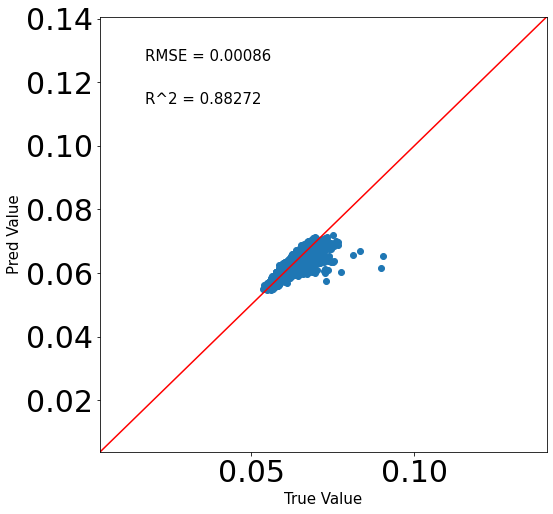

In [1222]:
pred_df = pd.concat([y_test_time.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
pred_df.columns = ['true', 'pred']
# 可視化
True_Pred_map(pred_df)

In [1224]:
# 重要因子のテキスト出力
importance_df = pd.DataFrame({"features": X_test.columns, "importance": lgb_time.feature_importance()})
importance_df2 = pd.DataFrame({"features": X_test2.columns, "importance": lgb_time2.feature_importance()})
sorted_importance_df = importance_df.sort_values(by='importance', ascending=False)
sorted_importance_df2 = importance_df2.sort_values(by='importance', ascending=False)
print(sorted_importance_df.head(10))
print(sorted_importance_df2.head(10))

            features  importance
257       season_cos       13500
14        course_len        5903
182          dif_len        5146
16         5th_prize        5110
3           horse_id        4716
13         race_name        4273
11                単勝        4244
184           正規化_単勝        4110
258     season_cos_0        3193
252  days_interval_0        3162
            features  importance
254       season_cos       15754
12        course_len        6042
3           horse_id        5308
180          dif_len        5057
14         5th_prize        4963
11         race_name        4566
249  days_interval_0        3941
255     season_cos_0        3349
56              前走着差        3338
13        head_count        3258


## 正規化_タイム 予測

In [1225]:
lgb_train_ss = lgb.Dataset(X_train.values, y_train_time_ss.values)
lgb_test_ss = lgb.Dataset(X_test.values, y_test_time_ss.values, reference=lgb_train_ss2)

## LightGBM用の変数にデータセット
lgb_train_ss2 = lgb.Dataset(X_train2.values, y_train_time_ss.values)
lgb_test_ss2 = lgb.Dataset(X_test2.values, y_test_time_ss.values, reference=lgb_train_ss2)

### 正規化_タイム学習

In [1226]:
#time予測 単勝データなし
evaluation_results  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_time_ss = lgb.train(#params,
                     ht_ss_params,
                      lgb_train_ss,
                      valid_sets = [lgb_train_ss, lgb_test_ss],
                      valid_names=['train', 'test'],
                      evals_result = evaluation_results,
                      verbose_eval = 100
                      )

Training until validation scores don't improve for 20 rounds
[100]	train's l1: 0.212903	train's l2: 0.0668791	train's rmse: 0.25861	test's l1: 0.21718	test's l2: 0.0697025	test's rmse: 0.264012
[200]	train's l1: 0.201914	train's l2: 0.0614364	train's rmse: 0.247864	test's l1: 0.208036	test's l2: 0.0655117	test's rmse: 0.255952
[300]	train's l1: 0.196781	train's l2: 0.0590408	train's rmse: 0.242983	test's l1: 0.204996	test's l2: 0.0644066	test's rmse: 0.253785
[400]	train's l1: 0.193374	train's l2: 0.0573274	train's rmse: 0.239431	test's l1: 0.203707	test's l2: 0.0639439	test's rmse: 0.252871
[500]	train's l1: 0.190582	train's l2: 0.0558346	train's rmse: 0.236293	test's l1: 0.202983	test's l2: 0.0636463	test's rmse: 0.252282
[600]	train's l1: 0.18814	train's l2: 0.0544954	train's rmse: 0.233442	test's l1: 0.202536	test's l2: 0.0634465	test's rmse: 0.251886
[700]	train's l1: 0.185871	train's l2: 0.0532419	train's rmse: 0.230742	test's l1: 0.202212	test's l2: 0.063294	test's rmse: 0.25158

In [1227]:
#time予測 単勝データなし
evaluation_results2  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_time_ss2 = lgb.train(#params,
                     ht_ss_params2,
                      lgb_train_ss2,
                      valid_sets = [lgb_train_ss2, lgb_test_ss2],
                      valid_names=['train2', 'test2'],
                      evals_result = evaluation_results2,
                      verbose_eval = 100
                      )

Training until validation scores don't improve for 20 rounds
[100]	train2's l1: 0.221912	train2's l2: 0.0723348	train2's rmse: 0.268951	test2's l1: 0.226714	test2's l2: 0.0754642	test2's rmse: 0.274708
[200]	train2's l1: 0.212176	train2's l2: 0.0672016	train2's rmse: 0.259233	test2's l1: 0.218867	test2's l2: 0.0714899	test2's rmse: 0.267376
[300]	train2's l1: 0.20712	train2's l2: 0.0646676	train2's rmse: 0.254298	test2's l1: 0.215702	test2's l2: 0.0701057	test2's rmse: 0.264775
[400]	train2's l1: 0.203608	train2's l2: 0.0628337	train2's rmse: 0.250667	test2's l1: 0.213953	test2's l2: 0.0693645	test2's rmse: 0.263371
[500]	train2's l1: 0.200784	train2's l2: 0.0613005	train2's rmse: 0.247589	test2's l1: 0.21282	test2's l2: 0.0688936	test2's rmse: 0.262476
[600]	train2's l1: 0.19834	train2's l2: 0.0599322	train2's rmse: 0.244811	test2's l1: 0.212074	test2's l2: 0.0685682	test2's rmse: 0.261855
[700]	train2's l1: 0.196139	train2's l2: 0.0586811	train2's rmse: 0.242242	test2's l1: 0.211577	

### 正規化_タイム 検証

In [1229]:
me_time_ss = ModelEvaluator(lgb_time_ss, return_tables, TYPE='Regression', std=False)  # モデルを決める
me_time_ss_std = ModelEvaluator(lgb_time_ss, return_tables, TYPE='Regression', std=True)  # モデルを決める

me_time_ss2 = ModelEvaluator(lgb_time_ss2, return_tables, TYPE='Regression', std=False)  # モデルを決める
me_time_ss2_std = ModelEvaluator(lgb_time_ss2, return_tables, TYPE='Regression', std=True)  # モデルを決める

feature_fraction, val_score: inf:   0%|          | 0/7 [38:27:46<?, ?it/s]


In [1231]:
y_pred1 = me_time_ss.predict_proba(X_test)
R2 = r2_score(y_test_time_ss, y_pred1)
print('R2={:.1%}'.format(R2))

y_pred = me_time_ss2.predict_proba(X_test2)
R2 = r2_score(y_test_time_ss, y_pred)
print('R2={:.1%}'.format(R2))

R2=32.1%
R2=27.0%


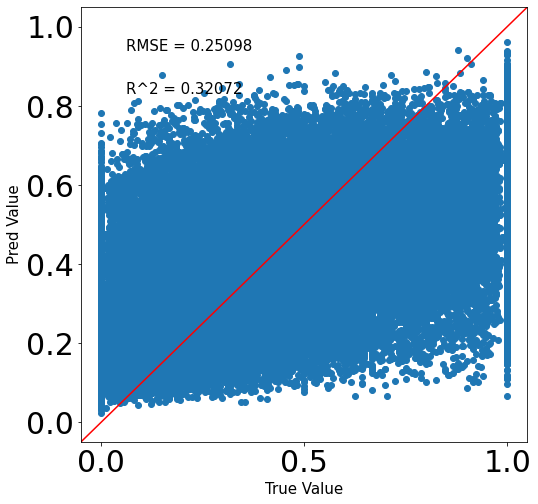

In [1232]:
pred_df = pd.concat([y_test_time_ss.reset_index(drop=True), y_pred1.reset_index(drop=True)], axis=1)
pred_df.columns = ['true', 'pred']
# 可視化
True_Pred_map(pred_df)

In [1233]:
# 重要因子のテキスト出力
importance_df = pd.DataFrame({"features": X_test2.columns, "importance": lgb_time_ss2.feature_importance()})
sorted_importance_df = importance_df.sort_values(by='importance', ascending=False)
print(sorted_importance_df.head(10))

            features  importance
249  days_interval_0        2634
201         正規化_前走着差        2345
182           正規化_体重        1934
206         正規化_前走上り        1907
224  正規化_獲得賞金平均_allR        1842
254       season_cos        1578
61              前走上り        1569
3           horse_id        1510
186        正規化_オッズ_0        1504
176              生産者        1494


## オッズ予測

In [1234]:
lgb_train_odds = lgb.Dataset(X_train.values, y_train_odds.values)
lgb_test_odds = lgb.Dataset(X_test.values, y_test_odds.values, reference=lgb_train_odds)

lgb_train_odds2 = lgb.Dataset(X_train2.values, y_train_odds.values)
lgb_test_odds2 = lgb.Dataset(X_test2.values, y_test_odds.values, reference=lgb_train_odds)

In [1235]:
evaluation_results_odds  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_odds = lgb.train(#params,
                     ho_params,
                      lgb_train_odds,
                      valid_sets = [lgb_train_odds, lgb_test_odds],
                      valid_names=['train', 'test'],
                      num_boost_round = 5000, # 最大試行数
                      early_stopping_rounds=20, # この数分、連続でメトリックに変化なければ終了する
                      evals_result = evaluation_results_odds,
                      verbose_eval=500
                      )

Training until validation scores don't improve for 20 rounds
[500]	train's l1: 0.683485	train's l2: 4.70418	train's rmse: 2.16891	test's l1: 0.896304	test's l2: 28.3505	test's rmse: 5.32452
Early stopping, best iteration is:
[581]	train's l1: 0.53638	train's l2: 3.64395	train's rmse: 1.90891	test's l1: 0.761407	test's l2: 28.0094	test's rmse: 5.29239


In [1236]:
evaluation_results_odds2  = {}  # to record evaluation results for plotting
    # lgbm.trainが、scikit-learnのmodel.fitに相当する
lgb_odds2 = lgb.train(#params,
                     ho_params2,
                      lgb_train_odds2,
                      valid_sets = [lgb_train_odds2, lgb_test_odds2],
                      valid_names=['train', 'test'],
                      num_boost_round = 5000, # 最大試行数
                      early_stopping_rounds=20, # この数分、連続でメトリックに変化なければ終了する
                      evals_result = evaluation_results_odds2,
                      verbose_eval=500
                      )

Training until validation scores don't improve for 20 rounds
[500]	train's l1: 25.2707	train's l2: 1834.66	train's rmse: 42.8329	test's l1: 30.6711	test's l2: 3020.47	test's rmse: 54.9588
[1000]	train's l1: 21.1209	train's l2: 1228.83	train's rmse: 35.0547	test's l1: 29.6018	test's l2: 2798.04	test's rmse: 52.8965
[1500]	train's l1: 18.3505	train's l2: 895.659	train's rmse: 29.9276	test's l1: 29.2635	test's l2: 2728.24	test's rmse: 52.2326
[2000]	train's l1: 16.2302	train's l2: 683.44	train's rmse: 26.1427	test's l1: 29.0977	test's l2: 2696.03	test's rmse: 51.9233
Early stopping, best iteration is:
[2235]	train's l1: 15.3912	train's l2: 610.076	train's rmse: 24.6997	test's l1: 29.0382	test's l2: 2686.35	test's rmse: 51.83


### オッズ検証

In [1247]:
# me_odds = ModelEvaluator(lgb_odds, return_tables, TYPE='Regression', std=False)  # モデルを決める
# me_odds_std = ModelEvaluator(lgb_odds, return_tables, TYPE='Regression', std=True)  # モデルを決める

me_odds2 = ModelEvaluator(lgb_odds2, return_tables, TYPE='Regression', std=False)  # モデルを決める
me_odds2_std = ModelEvaluator(lgb_odds2, return_tables, TYPE='Regression', std=True)  # モデルを決める

In [1248]:
# y_pred_odds1 = me_odds.predict_proba(X_test)
# R2_odds = r2_score(y_test_odds, y_pred_odds1)
# print('R2={:.1%}'.format(R2_odds))

y_pred_odds = me_odds2.predict_proba(X_test2)
R2_odds = r2_score(y_test_odds, y_pred_odds)
print('R2={:.1%}'.format(R2_odds))

R2=70.2%


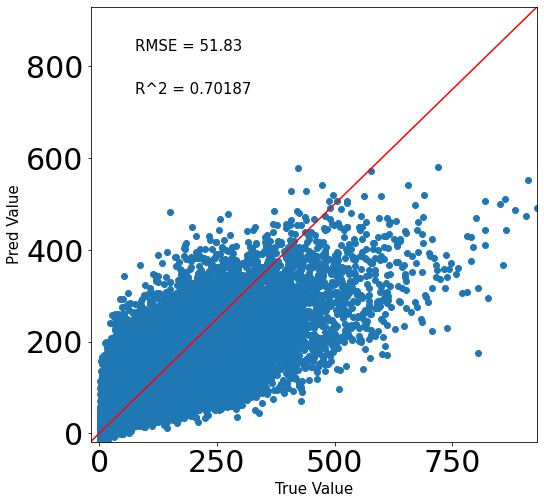

In [1249]:
pred_odds_df = pd.concat([y_test_odds.reset_index(drop=True), y_pred_odds.reset_index(drop=True)], axis=1)
pred_odds_df.columns = ['true', 'pred']
# 可視化
True_Pred_map(pred_odds_df)

In [1250]:
# 重要因子のテキスト出力
importance_df = pd.DataFrame({"features": X_test2.columns, "importance": lgb_odds2.feature_importance()})
sorted_importance_df = importance_df.sort_values(by='importance', ascending=False)
print(sorted_importance_df.head(10))

            features  importance
36             オッズ_0        8088
254       season_cos        8014
201         正規化_前走着差        7136
56              前走着差        6757
249  days_interval_0        6669
224  正規化_獲得賞金平均_allR        6352
3           horse_id        6347
186        正規化_オッズ_0        5647
61              前走上り        5322
196         正規化_着順_0        5306


In [28]:
lgb_rank = lgb.LGBMClassifier(**hr_params)
lgb_rank.fit(X_train.values, y_train_rank.values, eval_set=[(X_test.values, y_test_rank.values)], early_stopping_rounds=20, verbose=1000)

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[369]	valid_0's binary_logloss: 0.534852


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_date_in_leaf=10, min_split_gain=0.0,
               n_estimators=100000, n_jobs=-1, num_leaves=49,
               objective='binary', random_state=100, reg_alpha=1, reg_lambda=0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

### rank検証

In [29]:
me = ModelEvaluator(lgb_rank, return_tables, std=False)  # モデルを決める
me_std = ModelEvaluator(lgb_rank, return_tables, std=True)  # モデルを決める

In [30]:
print(me.score(y_train_rank, X_train))
print(me.score(y_test_rank, X_test))
me.feature_importances(X_train, 10)

0.8338626876538714
0.8111747984190845


,features,importance
3,単勝,2880
11,head_count,450
4,人気,444
128,正規化_賞金_5R,414
120,正規化_単勝,413
24,前走着差,267
127,正規化_前走着差,231
124,正規化_着順_5R,227
77,peds_43,214
121,正規化_前走上り,206


In [31]:
################### 予測値を返してくれる #######################
# 何が何件あるかをみる
print(pd.Series(me.predict(X_test)).value_counts())
#実際は？
print(y_test_rank.value_counts())

0    31923
1    21117
dtype: int64
0    41368
1    11672
Name: rank, dtype: int64


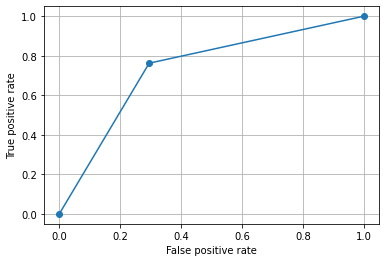

In [32]:
y_pred_test = pd.Series(me.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test_rank, y_pred_test)

plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

## rank予測

In [1572]:
lgb_rank = lgb.LGBMClassifier(**hr_params)
lgb_rank.fit(X_train.values, y_train_rank.values, eval_set=[(X_test.values, y_test_rank.values)], early_stopping_rounds=20, verbose=1000)

lgb_rank2 = lgb.LGBMClassifier(**hr2_params)
lgb_rank2.fit(X_train2.values, y_train_rank.values, eval_set=[(X_test2.values, y_test_rank.values)], early_stopping_rounds=3, verbose=1000)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[375]	valid_0's binary_logloss: 0.533194
Training until validation scores don't improve for 5 rounds
[1000]	valid_0's binary_logloss: 0.523425
[2000]	valid_0's binary_logloss: 0.490844
[3000]	valid_0's binary_logloss: 0.471898
[4000]	valid_0's binary_logloss: 0.46004
Early stopping, best iteration is:
[4830]	valid_0's binary_logloss: 0.454469


LGBMClassifier(bagging_fraction=0.9511618808095298, bagging_freq=4,
               class_weight='balanced', feature_fraction=0.8,
               lambda_l1=2.509070701220802e-07, lambda_l2=6.5395988212625715,
               learning_rate=0.01, metric='binary_logloss', n_estimators=100000,
               num_leaves=235, objective='binary', random_state=100)

### rank検証

In [1685]:
me = ModelEvaluator(lgb_rank, return_tables, std=False)  # モデルを決める
me_std = ModelEvaluator(lgb_rank, return_tables, std=True)  # モデルを決める

#Model Evaluator
me2 = ModelEvaluator(lgb_rank2, return_tables, TYPE='Nomal', std=False)  # モデルを決める
me2_std = ModelEvaluator(lgb_rank2, return_tables, std=True)  # モデルを決める

In [1253]:
print(me.score(y_train_rank, X_train))
print(me.score(y_test_rank, X_test))
me.feature_importances(X_train, 10)

0.8248824789754909
0.8195060482143748


,features,importance
11,単勝,2112
184,正規化_単勝,398
12,人気,397
15,head_count,330
308,調教師_場所_栗東,247
253,days_interval01,245
177,馬主,201
188,正規化_獲得賞金平均_5R,187
252,days_interval_0,183
251,正規化_dif_len,145


In [1574]:
print(me2.score(y_train_rank, X_train2))
print(me2.score(y_test_rank, X_test2))
me2.feature_importances(X_train2, 10)

0.9999954646193382
0.7884972720249324


,features,importance
182,正規化_体重,10925
175,馬主,10584
18,調教師名,10439
114,peds_1,10298
254,season_cos,10280
249,days_interval_0,9557
172,peds_59,9368
173,peds_60,9307
255,season_cos_0,9274
174,peds_61,9114


In [1584]:
# 何が何件あるかをみる
print(pd.Series(me2.predict(X_train2)).value_counts())
print(pd.Series(me2_std.predict(X_train2)).value_counts())
#実際は？
print(y_train_rank.value_counts())

0    123494
1     34060
dtype: int64
0    122618
1     34936
dtype: int64
0    124452
1     33102
Name: rank, dtype: int64


In [1585]:
# 何が何件あるかをみる
print(pd.Series(me.predict(X_test)).value_counts())
# 何が何件あるかをみる
print(pd.Series(me2.predict(X_test2)).value_counts())
print(pd.Series(me2_std.predict(X_test2)).value_counts())
#実際は？
print(y_test_rank.value_counts())

0    37690
1    26200
dtype: int64
0    49742
1    14148
dtype: int64
0    46955
1    16935
dtype: int64
0    49706
1    14184
Name: rank, dtype: int64


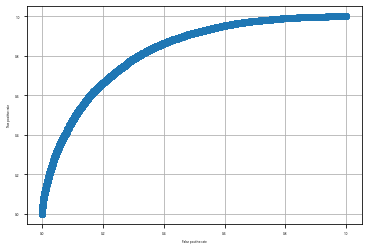

In [1559]:
y_pred_test = pd.Series(me.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test_rank, y_pred_test)

plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

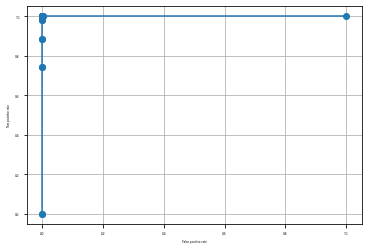

In [1576]:
y_pred_train2 = pd.Series(me2.predict_proba(X_train2))
fpr, tpr, thresholds = roc_curve(y_train_rank, y_pred_train2)

plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

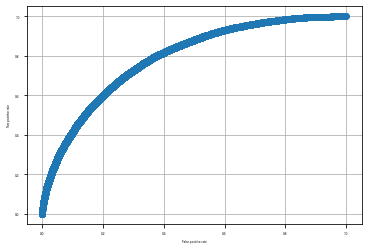

In [1560]:
y_pred_test2 = pd.Series(me2.predict_proba(X_test2))
fpr, tpr, thresholds = roc_curve(y_test_rank, y_pred_test2)
plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

In [1149]:
me.tansho_return(X_test, N_count = 3, threshold=0)

(14178, -1417800, -261150, 81.58061785865426, 22.15404147270419)

In [1150]:
me.tansho_return(X_test, N_count = 0, threshold=0.5)

(26200, -2620000, -447380, 82.92442748091602, 15.725190839694655)

### rank2検証

In [1125]:
me2.tansho_return(X_test2, N_count = 3, threshold=0)

(14178, -1417800, -214670, 84.85893638030751, 20.242629425871066)

In [1129]:
me2.tansho_return(X_test2, N_count = 0, threshold=0.9)

(809, -80900, -11510, 85.77255871446229, 43.38689740420272)

In [1127]:
me2.fukusho_return(X_test2, N_count = 3, threshold=0)

(14178, -1417800, -1101480, 22.31062209056284, 49.6191282268303)

In [1128]:
me2.fukusho_return(X_test2, N_count = 0, threshold=0.5)

(13146, -1314600, -1020630, 22.361935189411227, 50.77590141487905)

In [34]:
lgb_rank3 = lgb.LGBMClassifier(**hr3_params)
lgb_rank3.fit(X_train3.values, y_train_rank.values, eval_set=[(X_test3.values, y_test_rank.values)], early_stopping_rounds=20, verbose=1000)

Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's binary_logloss: 0.566087
[2000]	valid_0's binary_logloss: 0.553311
[3000]	valid_0's binary_logloss: 0.541737
[4000]	valid_0's binary_logloss: 0.531942
[5000]	valid_0's binary_logloss: 0.522888
[6000]	valid_0's binary_logloss: 0.516411
[7000]	valid_0's binary_logloss: 0.51075
[8000]	valid_0's binary_logloss: 0.506277
[9000]	valid_0's binary_logloss: 0.502939
[10000]	valid_0's binary_logloss: 0.500333
Early stopping, best iteration is:
[10579]	valid_0's binary_logloss: 0.498948


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0,
               feature_fraction=0.4, importance_type='split', lambda_l1=0.0,
               lambda_l2=0.0, learning_rate=0.01, max_depth=7,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100000,
               n_jobs=-1, num_leaves=55, objective='binary', random_state=100,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### rank3検証

In [35]:
me3 = ModelEvaluator(lgb_rank3, return_tables, std=False)  # モデルを決める
me3_std = ModelEvaluator(lgb_rank3, return_tables, std=True)  # モデルを決める

In [375]:
print(me3.score(y_train_rank, X_train3))
print(me3.score(y_test_rank, X_test3))
me3.feature_importances(X_train3, 10)

0.9899041200741716
0.7462393824817029


,features,importance
120,正規化_前走着差,9044
116,正規化_前走上り,8799
21,前走上り,8647
20,前走着差,8421
19,前走騎手,7359
117,正規化_着順_5R,6888
3,horse_id,6619
118,正規化_着順_9R,6560
119,正規化_着順_allR,6385
46,peds_16,6380


In [524]:
# 何が何件あるかをみる
print(pd.Series(me3.predict(X_test3)).value_counts())
#実際は？
print(y_test_rank.value_counts())

0    40282
1    12758
dtype: int64
53040


In [1659]:
gain_proper = gain(me2.tansho_return_proper, X_test2_V)

In [1660]:
gain = gain(me2.tansho_return, X_test2)

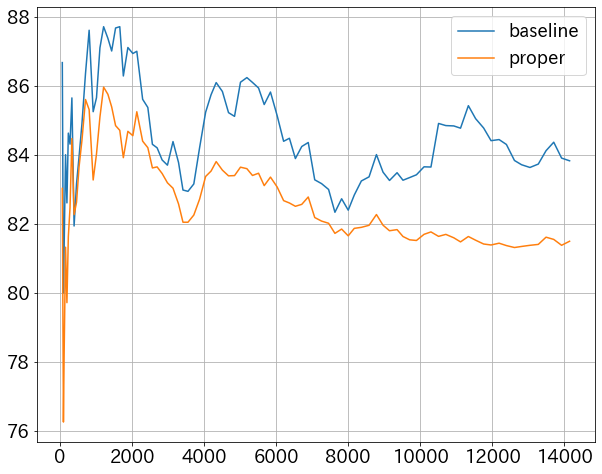

In [1663]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
gain.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

In [1668]:
gain_proper_simple = gain_Simple(me2.tansho_return_proper, X_test2_V)

In [1670]:
gain_simple = gain_Simple(me2.tansho_return, X_test2)

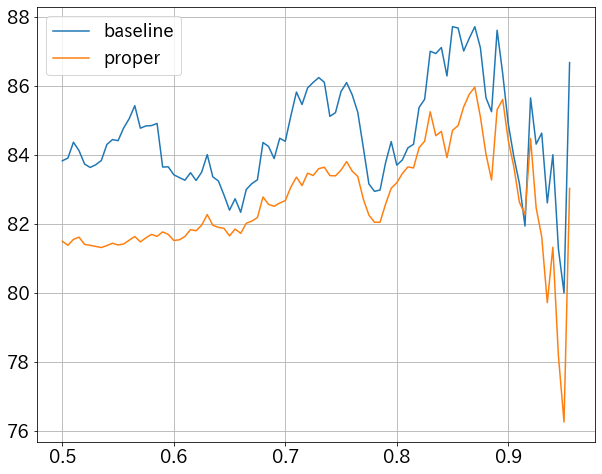

In [1671]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
gain_simple.rename('baseline').plot(legend=True)
gain_proper_simple.rename('proper').plot(legend=True)
plt.grid()

In [1686]:
gain_n_bets, gain_threthold = gain_HitRate(me2.fukusho_return, X_test2)

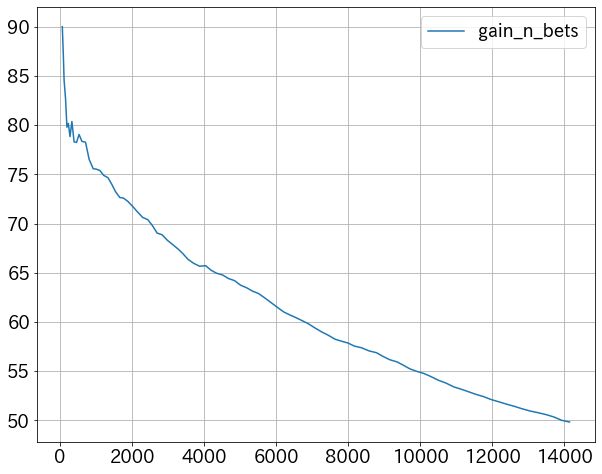

In [1687]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
gain_n_bets.rename('gain_n_bets').plot(legend=True)
plt.grid()

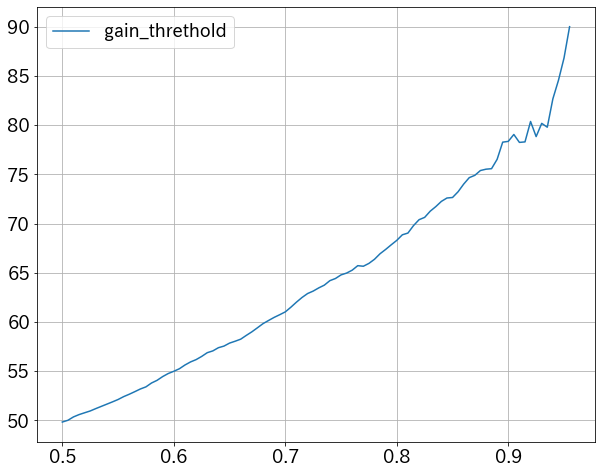

In [1688]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 18
gain_threthold.rename('gain_threthold').plot(legend=True)
plt.grid()

## LambdaRank予測

In [1258]:
headcount_query_train = X_train.groupby(level=0).size().values
headcount_query_test = X_test.groupby(level=0).size().values

headcount_query_train2 = X_train2.groupby(level=0).size().values
headcount_query_test2 = X_test2.groupby(level=0).size().values

In [1261]:
dtrain = lgb.Dataset(X_train.values, y_train_lambdarank, group=headcount_query_train)
dvalid = lgb.Dataset(X_test.values, y_test_lambdarank, reference=dtrain, group=headcount_query_test)
LRmodel = lgb.train(
   LambdaRank_params,
   dtrain,
   num_boost_round=10000,
   valid_sets=dvalid,
   valid_names=['train','valid'],
   early_stopping_rounds=20,
   verbose_eval=5
)

Training until validation scores don't improve for 20 rounds
[5]	train's ndcg@1: 0.414161	train's ndcg@2: 0.483791	train's ndcg@3: 0.547016
[10]	train's ndcg@1: 0.408082	train's ndcg@2: 0.480444	train's ndcg@3: 0.545239
[15]	train's ndcg@1: 0.408388	train's ndcg@2: 0.480018	train's ndcg@3: 0.544076
[20]	train's ndcg@1: 0.407263	train's ndcg@2: 0.481431	train's ndcg@3: 0.544279
[25]	train's ndcg@1: 0.405268	train's ndcg@2: 0.480426	train's ndcg@3: 0.54366
Early stopping, best iteration is:
[5]	train's ndcg@1: 0.414161	train's ndcg@2: 0.483791	train's ndcg@3: 0.547016


In [1262]:
dtrain2 = lgb.Dataset(X_train2.values, y_train_lambdarank, group=headcount_query_train2)
dvalid2 = lgb.Dataset(X_test2.values, y_test_lambdarank, reference=dtrain, group=headcount_query_test2)
LRmodel2 = lgb.train(
   LambdaRank_params2,
   dtrain2,
   num_boost_round=10000,
   valid_sets=dvalid2,
   valid_names=['train','valid'],
   early_stopping_rounds=20,
   verbose_eval=5
)

Training until validation scores don't improve for 20 rounds
[5]	train's ndcg@1: 0.33563	train's ndcg@2: 0.402671	train's ndcg@3: 0.465819
[10]	train's ndcg@1: 0.33768	train's ndcg@2: 0.407176	train's ndcg@3: 0.470777
[15]	train's ndcg@1: 0.335301	train's ndcg@2: 0.409168	train's ndcg@3: 0.472894
[20]	train's ndcg@1: 0.339569	train's ndcg@2: 0.413215	train's ndcg@3: 0.475457
[25]	train's ndcg@1: 0.337662	train's ndcg@2: 0.411891	train's ndcg@3: 0.474175
[30]	train's ndcg@1: 0.33544	train's ndcg@2: 0.411994	train's ndcg@3: 0.475094
[35]	train's ndcg@1: 0.335162	train's ndcg@2: 0.413388	train's ndcg@3: 0.476398
[40]	train's ndcg@1: 0.336746	train's ndcg@2: 0.414582	train's ndcg@3: 0.477251
Early stopping, best iteration is:
[21]	train's ndcg@1: 0.342138	train's ndcg@2: 0.414186	train's ndcg@3: 0.476982


### LambdaRank検証

In [1263]:
me_LR = ModelEvaluator(LRmodel, return_tables, TYPE='LambdaRank', std=False)  # モデルを決める
me_LR_std = ModelEvaluator(LRmodel, return_tables, TYPE='LambdaRank', std=True)  # モデルを決める

In [1264]:
me_LR2 = ModelEvaluator(LRmodel2, return_tables, TYPE='LambdaRank', std=False)  # モデルを決める
me_LR_std2 = ModelEvaluator(LRmodel2, return_tables, TYPE='LambdaRank', std=True)  # モデルを決める

In [1265]:
me_LR_std.tansho_return(X_test, N_count = 3, threshold=0)

(13973, -1397300, -264770, 81.0513132469763, 22.19280040077292)

In [1266]:
me_LR_std.fukusho_return(X_test, N_count = 3, threshold=0)

(13973, -1397300, -1103040, 21.05918557217491, 52.78751878623059)

In [1267]:
me_LR_std.tansho_return(X_test, N_count = 0, threshold=0.5)

(24374, -2437400, -462490, 81.02527283170592, 16.23451218511529)

In [1268]:
me_LR_std.fukusho_return(X_test, N_count = 0, threshold=0.5)

(24374, -2437400, -1835440, 24.6968080741774, 42.93099204069911)

## LambdaRank予測(単勝データなし)

In [1077]:
print(len(X_train2))
print(len(X_test2))
print(sum(headcount_query_train2))
print(sum(headcount_query_test2))

157554
63890
157554
63890


In [1078]:
print(y_train_lambdarank.value_counts())
print(sum(y_train_lambdarank.value_counts()))

0     124452
10     11036
3      11035
5      11031
Name: lambdarank2, dtype: int64
157554


### LambdaRank(単勝データなし)検証

In [1269]:
me_LR_std2.tansho_return(X_test2, N_count = 3, threshold=0)

(14178, -1417800, -308000, 78.27620256735787, 19.53731132740866)

In [1270]:
me_LR_std2.fukusho_return(X_test2, N_count = 3, threshold=0)

(14178, -1417800, -1112220, 21.55311045281422, 47.67950345605868)

In [1271]:
me_LR_std2.tansho_return(X_test2, N_count = 0, threshold=0.5)

(31599, -3159900, -643250, 79.64334314377038, 12.826355264407102)

In [1272]:
me_LR_std2.fukusho_return(X_test2, N_count = 0, threshold=0.5)

(31599, -3159900, -2340800, 25.921706383113392, 35.12136460014557)

## rank2着まで予測

In [1273]:
lgb_rank_12 = lgb.LGBMClassifier(**hr12_params)
lgb_rank_12.fit(X_train.values, y_train_rank12.values, eval_set=[(X_test.values, y_test_rank12.values)], early_stopping_rounds=20, verbose=1000)

lgb_rank_12_2 = lgb.LGBMClassifier(**hr12_params2)
lgb_rank_12_2.fit(X_train2.values, y_train_rank12.values, eval_set=[(X_test2.values, y_test_rank12.values)], early_stopping_rounds=20, verbose=1000)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.525837
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's binary_logloss: 0.509826
[2000]	valid_0's binary_logloss: 0.463982
[3000]	valid_0's binary_logloss: 0.433115
[4000]	valid_0's binary_logloss: 0.411303
[5000]	valid_0's binary_logloss: 0.395476
[6000]	valid_0's binary_logloss: 0.384418
[7000]	valid_0's binary_logloss: 0.376459
[8000]	valid_0's binary_logloss: 0.371235
[9000]	valid_0's binary_logloss: 0.367799
[10000]	valid_0's binary_logloss: 0.366007
Early stopping, best iteration is:
[10070]	valid_0's binary_logloss: 0.365939


LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, class_weight='balanced',
               feature_fraction=0.6, lambda_l1=1.0, lambda_l2=9.0,
               learning_rate=0.01, metric='binary_logloss', n_estimators=100000,
               num_leaves=144, objective='binary', random_state=100,
               reg_lambda=0)

### rank2着まで検証(単勝データなし)

In [1274]:
#Model Evaluator
me_12 = ModelEvaluator(lgb_rank_12, return_tables, TYPE='Nomal', std=False)  # モデルを決める
me_12_std = ModelEvaluator(lgb_rank_12, return_tables, std=True)  # モデルを決める

#Model Evaluator
me_12_2 = ModelEvaluator(lgb_rank_12_2, return_tables, TYPE='Nomal', std=False)  # モデルを決める
me_12_2_std = ModelEvaluator(lgb_rank_12_2, return_tables, std=True)  # モデルを決める

In [1275]:
print(me_12_2.score(y_train_rank12, X_train2))
print(me_12_2.score(y_test_rank12, X_test2))
me_12_2.feature_importances(X_train2, 10)

1.0
0.7914540555485318


,features,importance
175,馬主,13301
18,調教師名,13254
254,season_cos,13130
182,正規化_体重,13053
114,peds_1,12642
172,peds_59,12286
255,season_cos_0,11957
173,peds_60,11939
118,peds_5,11849
174,peds_61,11758


In [1276]:
# 何が何件あるかをみる
print(pd.Series(me_12_2.predict(X_test2)).value_counts())
#実際は？
print(y_test_rank12.value_counts())

0    56418
1     7472
dtype: int64
0    54432
1     9458
Name: rank1_2, dtype: int64


In [1277]:
me_12.tansho_return(X_test, N_count = 2, threshold=0)

(9452, -945200, -178630, 81.10135421074904, 26.534066864155736)

In [1278]:
me_12.fukusho_return(X_test, N_count = 2, threshold=0)

(9452, -945200, -766470, 18.909225560727887, 58.421498095641134)

In [1279]:
me_12.tansho_return(X_test, N_count = 0, threshold=0.5)

(23562, -2356200, -418830, 82.22434428316781, 16.87462863933452)

In [1280]:
me_12.fukusho_return(X_test, N_count = 0, threshold=0.5)

(23562, -2356200, -1788470, 24.095153212800273, 44.19828537475596)

## rank2着まで予測(単勝データなし)

### rank2着まで検証(単勝データなし)

In [1281]:
me_12_2.tansho_return(X_test2, N_count = 2, threshold=0)

(9452, -945200, -160450, 83.02475666525602, 23.857384680490902)

In [1282]:
me_12_2.fukusho_return(X_test2, N_count = 2, threshold=0)

(9452, -945200, -745990, 21.0759627592044, 54.41176470588235)

In [1283]:
me_12_2.tansho_return(X_test2, N_count = 0, threshold=0.5)

(7472, -747200, -103180, 86.19111349036402, 26.258029978586723)

In [1284]:
me_12_2.fukusho_return(X_test2, N_count = 0, threshold=0.5)

(7472, -747200, -589130, 21.154978586723768, 58.2441113490364)

## アンサンブル学習予測

In [1342]:
#回帰予測
Ensemble_time_pred_train = me_time.predict_proba(X_train)
Ensemble_time_pred_train_std = me_time_std.predict_proba(X_train)
Ensemble_time_pred_train2 = me_time2.predict_proba(X_train2)
Ensemble_time_pred_train2_std = me_time2_std.predict_proba(X_train2)

Ensemble_time_ss_pred_train = me_time_ss2.predict_proba(X_train)
Ensemble_time_ss_pred_train_std = me_time_ss2_std.predict_proba(X_train)
Ensemble_time_ss_pred_train2 = me_time_ss2.predict_proba(X_train2)
Ensemble_time_ss_pred_train2_std = me_time_ss2_std.predict_proba(X_train2)

#Ensemble_odds_pred_train = me_odds.predict_proba(X_train)
#Ensemble_odds_pred_train_std = me_odds_std.predict_proba(X_train)
Ensemble_odds_pred_train2 = me_odds2.predict_proba(X_train2)
Ensemble_odds_pred_train2_std = me_odds2_std.predict_proba(X_train2)

#分類予測
Ensemble_rank_pred_train = me.predict_proba(X_train)
Ensemble_rank_pred_train_std = me_std.predict_proba(X_train)
Ensemble_rank_pred_train2 = me2.predict_proba(X_train2)
Ensemble_rank_pred_train2_std = me2_std.predict_proba(X_train2)

Ensemble_LRrank_pred_train = me_LR.predict_proba(X_train)
Ensemble_LRrank_pred_train_std = me_LR_std.predict_proba(X_train)
Ensemble_LRrank_pred_train2 = me_LR2.predict_proba(X_train2)
Ensemble_LRrank_pred_train2_std = me_LR_std2.predict_proba(X_train2)

Ensemble_rank_12_pred_train = me_12.predict_proba(X_train)
Ensemble_rank_12_pred_train_std = me_12_std.predict_proba(X_train)
Ensemble_rank_12_pred_train2 = me_12_2.predict_proba(X_train2)
Ensemble_rank_12_pred_train2_std = me_12_2_std.predict_proba(X_train2)

In [1374]:
Ensemble_time_train = pd.concat([Ensemble_time_pred_train, Ensemble_time_pred_train_std], axis=1).rename(columns={0:'time',1:'time_std'})
Ensemble_time_train2 = pd.concat([Ensemble_time_pred_train2, Ensemble_time_pred_train2_std], axis=1).rename(columns={0:'time2',1:'time_std2'})
Ensemble_time_ss_train = pd.concat([Ensemble_time_ss_pred_train, Ensemble_time_ss_pred_train_std], axis=1).rename(columns={0:'time_ss',1:'time_ss_std'})
Ensemble_time_ss_train2 = pd.concat([Ensemble_time_ss_pred_train2, Ensemble_time_ss_pred_train2_std], axis=1).rename(columns={0:'time_ss2',1:'time_ss_std2'})
#Ensemble_odds_train = pd.concat([Ensemble_odds_pred_train, Ensemble_odds_pred_train_std], axis=1).rename(columns={0:'odds',1:'odds_std'})
Ensemble_odds_train2 = pd.concat([Ensemble_odds_pred_train2, Ensemble_odds_pred_train2_std], axis=1).rename(columns={0:'odds2',1:'odds_std2'})

Ensemble_rank_train = pd.concat([Ensemble_rank_pred_train, Ensemble_rank_pred_train_std], axis=1).rename(columns={0:'rank_proba',1:'rank_proba_std'})
Ensemble_rank_train2 = pd.concat([Ensemble_rank_pred_train2, Ensemble_rank_pred_train2_std], axis=1).rename(columns={0:'rank_proba2',1:'rank_proba_std2'})

Ensemble_Lambdarank_train = pd.concat([Ensemble_LRrank_pred_train, Ensemble_LRrank_pred_train_std], axis=1).rename(columns={0:'Lambdarank',1:'Lambdarank_std'})
Ensemble_Lambdarank_train2 = pd.concat([Ensemble_LRrank_pred_train2, Ensemble_LRrank_pred_train2_std], axis=1).rename(columns={0:'Lambdarank2',1:'Lambdarank_std2'})

Ensemble_rank_12_train = pd.concat([Ensemble_rank_12_pred_train2, Ensemble_rank_12_pred_train2_std], axis=1).rename(columns={0:'rank_12_proba',1:'rank_12_proba_std'})
Ensemble_rank_12_train2 = pd.concat([Ensemble_rank_12_pred_train2, Ensemble_rank_12_pred_train2_std], axis=1).rename(columns={0:'rank_12_proba2',1:'rank_12_proba_std2'})

Ensemble_train = pd.concat([Ensemble_rank_train, Ensemble_Lambdarank_train, Ensemble_time_train, Ensemble_rank_12_train, Ensemble_time_ss_train,\
                            Ensemble_rank_train2, Ensemble_Lambdarank_train2, Ensemble_time_train2, Ensemble_odds_train2, Ensemble_rank_12_train2, Ensemble_time_ss_train2], axis=1)
Ensemble_train.head()

,rank_proba,rank_proba_std,Lambdarank,Lambdarank_std,time,time_std,rank_12_proba,rank_12_proba_std,time_ss,time_ss_std,rank_proba2,rank_proba_std2,Lambdarank2,Lambdarank_std2,time2,time_std2,odds2,odds_std2,rank_12_proba2,rank_12_proba_std2,time_ss2,time_ss_std2
201506010101,0.132086,0.306229,-0.066837,0.333931,0.062606,0.579631,0.007752,0.125705,0.503236,0.372107,0.014877,0.235694,-0.260953,0.345366,0.062749,0.599629,121.396386,0.436661,0.007752,0.125705,0.625720,0.667300
201506010101,0.346670,0.456723,-0.023947,0.494313,0.062143,0.459655,0.041819,0.149927,0.512294,0.407425,0.837698,0.844798,-0.223530,0.389970,0.062086,0.420601,33.526944,0.259162,0.041819,0.149927,0.402011,0.448880
201506010101,0.697456,0.702741,0.019597,0.657137,0.061503,0.293565,0.916327,0.771703,0.591449,0.716056,0.886261,0.880748,-0.088327,0.551120,0.061662,0.305782,21.009701,0.233876,0.916327,0.771703,0.278256,0.328050
201506010101,0.660303,0.676684,0.019597,0.657137,0.061598,0.318079,0.058658,0.161899,0.583660,0.685689,0.123131,0.315831,0.046969,0.712379,0.061674,0.309175,5.096340,0.201731,0.058658,0.161899,0.257324,0.307612
201506010101,0.874375,0.826819,0.046177,0.756527,0.061031,0.171052,0.937736,0.786925,0.489486,0.318496,0.923963,0.908657,0.125737,0.806263,0.061204,0.182127,3.250339,0.198002,0.937736,0.786925,0.146693,0.199597


In [1344]:
#回帰予測
Ensemble_time_pred_test = me_time.predict_proba(X_test)
Ensemble_time_pred_test_std = me_time_std.predict_proba(X_test)
Ensemble_time_pred_test2 = me_time2.predict_proba(X_test2)
Ensemble_time_pred_test2_std = me_time2_std.predict_proba(X_test2)

#Ensemble_odds_pred_test = me_odds.predict_proba(X_test)
#Ensemble_odds_pred_test_std = me_odds_std.predict_proba(X_test)
Ensemble_odds_pred_test2 = me_odds2.predict_proba(X_test2)
Ensemble_odds_pred_test2_std = me_odds2_std.predict_proba(X_test2)

Ensemble_time_ss_pred_test = me_time_ss.predict_proba(X_test)
Ensemble_time_ss_pred_test_std = me_time_ss_std.predict_proba(X_test)
Ensemble_time_ss_pred_test2 = me_time_ss2.predict_proba(X_test2)
Ensemble_time_ss_pred_test2_std = me_time_ss2_std.predict_proba(X_test2)

#分類予測
Ensemble_rank_pred_test = me.predict_proba(X_test)
Ensemble_rank_pred_test_std = me_std.predict_proba(X_test)
Ensemble_rank_pred_test2 = me2.predict_proba(X_test2)
Ensemble_rank_pred_test2_std = me2_std.predict_proba(X_test2)

Ensemble_LRrank_pred_test = me_LR.predict_proba(X_test)
Ensemble_LRrank_pred_test_std = me_LR_std.predict_proba(X_test)
Ensemble_LRrank_pred_test2 = me_LR2.predict_proba(X_test2)
Ensemble_LRrank_pred_test2_std = me_LR_std2.predict_proba(X_test2)

Ensemble_rank_12_pred_test = me_12.predict_proba(X_test)
Ensemble_rank_12_pred_test_std = me_12_std.predict_proba(X_test)
Ensemble_rank_12_pred_test2 = me_12_2.predict_proba(X_test2)
Ensemble_rank_12_pred_test2_std = me_12_2_std.predict_proba(X_test2)

In [1375]:
Ensemble_time_test = pd.concat([Ensemble_time_pred_test, Ensemble_time_pred_test_std], axis=1).rename(columns={0:'time',1:'time_std'})
Ensemble_time_test2 = pd.concat([Ensemble_time_pred_test2, Ensemble_time_pred_test2_std], axis=1).rename(columns={0:'time2',1:'time_std2'})

#Ensemble_odds_test = pd.concat([Ensemble_odds_pred_test, Ensemble_odds_pred_test_std], axis=1).rename(columns={0:'odds',1:'odds_std'})
Ensemble_odds_test2 = pd.concat([Ensemble_odds_pred_test2, Ensemble_odds_pred_test2_std], axis=1).rename(columns={0:'odds2',1:'odds_std2'})

Ensemble_time_ss_test = pd.concat([Ensemble_time_ss_pred_test, Ensemble_time_ss_pred_test_std], axis=1).rename(columns={0:'time_ss',1:'time_ss_std'})
Ensemble_time_ss_test2 = pd.concat([Ensemble_time_ss_pred_test2, Ensemble_time_ss_pred_test2_std], axis=1).rename(columns={0:'time_ss2',1:'time_ss_std2'})

Ensemble_rank_test = pd.concat([Ensemble_rank_pred_test, Ensemble_rank_pred_test_std], axis=1).rename(columns={0:'rank_proba',1:'rank_proba_std'})
Ensemble_rank_test2 = pd.concat([Ensemble_rank_pred_test2, Ensemble_rank_pred_test2_std], axis=1).rename(columns={0:'rank_proba2',1:'rank_proba_stdZ'})

Ensemble_Lambdarank_test = pd.concat([Ensemble_LRrank_pred_test, Ensemble_LRrank_pred_test_std], axis=1).rename(columns={0:'Lambdarank',1:'Lambdarank_std'})
Ensemble_Lambdarank_test2 = pd.concat([Ensemble_LRrank_pred_test2, Ensemble_LRrank_pred_test2_std], axis=1).rename(columns={0:'Lambdarank2',1:'Lambdarank_std2'})


Ensemble_rank_12_test = pd.concat([Ensemble_rank_12_pred_test, Ensemble_rank_12_pred_test_std], axis=1).rename(columns={0:'rank_12_proba',1:'rank_12_proba_std'})
Ensemble_rank_12_test2 = pd.concat([Ensemble_rank_12_pred_test2, Ensemble_rank_12_pred_test2_std], axis=1).rename(columns={0:'rank_12_proba2',1:'rank_12_proba_std2'})

Ensemble_test = pd.concat([Ensemble_rank_test, Ensemble_Lambdarank_test, Ensemble_time_test, Ensemble_rank_12_test,Ensemble_time_ss_test,\
                          Ensemble_rank_test2, Ensemble_Lambdarank_test2, Ensemble_time_test2, Ensemble_odds_test2, Ensemble_rank_12_test2,Ensemble_time_ss_test2], axis=1)
Ensemble_test.head()

,rank_proba,rank_proba_std,Lambdarank,Lambdarank_std,time,time_std,rank_12_proba,rank_12_proba_std,time_ss,time_ss_std,rank_proba2,rank_proba_stdZ,Lambdarank2,Lambdarank_std2,time2,time_std2,odds2,odds_std2,rank_12_proba2,rank_12_proba_std2,time_ss2,time_ss_std2
201803020506,0.302881,0.397626,-0.050399,0.364372,0.063171,0.472265,0.283701,0.372205,0.449080,0.575592,0.174103,0.279196,-0.157527,0.325548,0.063402,0.602046,60.225071,0.515142,0.115128,0.243153,0.468116,0.712996
201803020506,0.233202,0.339635,-0.065291,0.295098,0.063220,0.483133,0.190103,0.295700,0.420764,0.536530,0.085047,0.199341,-0.137600,0.363238,0.063363,0.586668,55.253298,0.483135,0.044928,0.170996,0.433405,0.640470
201803020506,0.750598,0.770244,0.024628,0.713384,0.062210,0.257741,0.729287,0.736420,0.194306,0.224131,0.534699,0.602536,0.036480,0.692476,0.062634,0.295462,12.803341,0.209852,0.285283,0.418048,0.240435,0.237264
201803020506,0.120550,0.245878,-0.066837,0.287907,0.063777,0.607680,0.154588,0.266670,0.535421,0.694699,0.172431,0.277697,-0.154601,0.331083,0.062688,0.317063,54.649847,0.479250,0.132970,0.261491,0.377962,0.524622
201803020506,0.832330,0.838266,0.039461,0.782384,0.061957,0.201071,0.827640,0.816811,0.150844,0.164175,0.316636,0.407003,0.043269,0.705315,0.062845,0.379485,27.289812,0.303113,0.376998,0.512318,0.267871,0.294590


In [1376]:
lgb_rank_Ensemble123 = lgb.LGBMClassifier(**ensemble_params123)
lgb_rank_Ensemble123.fit(Ensemble_train.values, y_train_rank.values, eval_set=[(Ensemble_test.values, y_test_rank.values)], early_stopping_rounds=20, verbose=1000)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.458594


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, class_weight='balanced',
               feature_fraction=0.4, lambda_l1=3.0, lambda_l2=0.0,
               learning_rate=0.01, metric='binary_logloss',
               min_child_samples=50, n_estimators=100000, num_leaves=221,
               objective='binary', random_state=100)

In [1377]:
lgb_rank_Ensemble12 = lgb.LGBMClassifier(**ensemble_params12)
lgb_rank_Ensemble12.fit(Ensemble_train.values, y_train_rank12.values, eval_set=[(Ensemble_test.values, y_test_rank12.values)], early_stopping_rounds=20, verbose=1000)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.388293


LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, class_weight='balanced',
               feature_fraction=0.4, lambda_l1=0.05, lambda_l2=0.0,
               learning_rate=0.01, metric='binary_logloss',
               min_child_samples=50, n_estimators=100000, num_leaves=5,
               objective='binary', random_state=100)

## アンサンブル検証

In [1378]:
me_ensemble123 = ModelEvaluator(lgb_rank_Ensemble123, return_tables,TYPE='Ensemble', std=False, umaban=False)  # モデルを決める
me_ensemble123_std = ModelEvaluator(lgb_rank_Ensemble123, return_tables,TYPE='Ensemble', std=True, umaban=False)  # モデルを決める

In [1379]:
me_ensemble12 = ModelEvaluator(lgb_rank_Ensemble12, return_tables,TYPE='Ensemble', std=False, umaban=False)  # モデルを決める
me_ensemble12_std = ModelEvaluator(lgb_rank_Ensemble12, return_tables,TYPE='Ensemble', std=True, umaban=False)  # モデルを決める

In [1380]:
print(me_ensemble123.score(y_train_rank, Ensemble_train))
print(me_ensemble123.score(y_test_rank, Ensemble_test))
me_ensemble123.feature_importances(Ensemble_train, 10)

0.9999946914879204
0.8016919875217094


,features,importance
15,time_std2,860
3,Lambdarank_std,776
17,odds_std2,762
0,rank_proba,730
21,time_ss_std2,709
2,Lambdarank,647
12,Lambdarank2,635
13,Lambdarank_std2,611
20,time_ss2,597
14,time2,595


In [1381]:
print(me_ensemble12.score(y_train_rank12, Ensemble_train))
print(me_ensemble12.score(y_test_rank12, Ensemble_test))
me_ensemble12.feature_importances(Ensemble_train, 10)

0.9999999993310571
0.8104636623171051


,features,importance
6,rank_12_proba,125
7,rank_12_proba_std,94
18,rank_12_proba2,80
10,rank_proba2,78
19,rank_12_proba_std2,74
11,rank_proba_std2,63
20,time_ss2,36
21,time_ss_std2,27
13,Lambdarank_std2,26
12,Lambdarank2,24


0    53508
1    10382
dtype: int64
0    49706
1    14184
Name: rank, dtype: int64


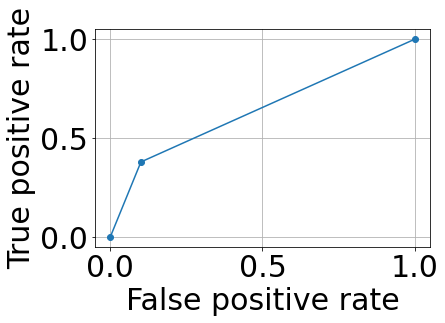

In [1382]:
# 何が何件あるかをみる
y_pred_ensemble = pd.Series(me_ensemble123.predict(Ensemble_test))
print(y_pred_ensemble.value_counts())
#実際は？
print(y_test_rank.value_counts())

fpr, tpr, thresholds = roc_curve(y_test_rank, y_pred_ensemble)

plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

0    54249
1     9641
dtype: int64
0    49706
1    14184
Name: rank, dtype: int64


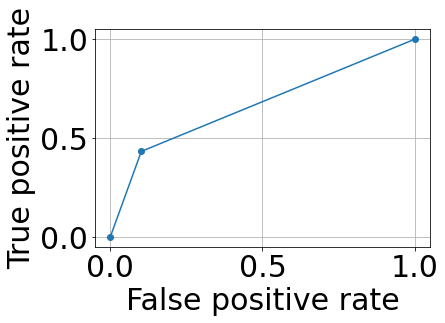

In [1383]:
# 何が何件あるかをみる
y_pred_ensemble = pd.Series(me_ensemble12.predict(Ensemble_test))
print(y_pred_ensemble.value_counts())
#実際は？
print(y_test_rank.value_counts())

fpr, tpr, thresholds = roc_curve(y_test_rank12, y_pred_ensemble)

plt.plot(fpr, tpr, marker='o')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

In [1384]:
Ensemble_test_predict = Ensemble_test.copy()
Ensemble_test_predict['馬番']= X_test2['馬番'].copy()
Ensemble_test_predict.head(3)

,rank_proba,rank_proba_std,Lambdarank,Lambdarank_std,time,time_std,rank_12_proba,rank_12_proba_std,time_ss,time_ss_std,rank_proba2,rank_proba_stdZ,Lambdarank2,Lambdarank_std2,time2,time_std2,odds2,odds_std2,rank_12_proba2,rank_12_proba_std2,time_ss2,time_ss_std2,馬番
201803020506,0.302881,0.397626,-0.050399,0.364372,0.063171,0.472265,0.283701,0.372205,0.449080,0.575592,0.174103,0.279196,-0.157527,0.325548,0.063402,0.602046,60.225071,0.515142,0.115128,0.243153,0.468116,0.712996,1
201803020506,0.233202,0.339635,-0.065291,0.295098,0.063220,0.483133,0.190103,0.295700,0.420764,0.536530,0.085047,0.199341,-0.137600,0.363238,0.063363,0.586668,55.253298,0.483135,0.044928,0.170996,0.433405,0.640470,2
201803020506,0.750598,0.770244,0.024628,0.713384,0.062210,0.257741,0.729287,0.736420,0.194306,0.224131,0.534699,0.602536,0.036480,0.692476,0.062634,0.295462,12.803341,0.209852,0.285283,0.418048,0.240435,0.237264,3


In [1385]:
me_ensemble12.tansho_return(Ensemble_test_predict, N_count = 2, threshold=0)

(9450, -945000, -151390, 83.97989417989417, 24.285714285714285)

In [1386]:
me_ensemble12.fukusho_return(Ensemble_test_predict, N_count = 2, threshold=0)

(9450, -945000, -751430, 20.483597883597884, 55.195767195767196)

In [1387]:
me_ensemble12.tansho_return(Ensemble_test_predict, N_count = 0, threshold=0.5)

(9641, -964100, -152710, 84.1603568094596, 24.323202987241988)

In [1358]:
me_ensemble12.fukusho_return(Ensemble_test_predict, N_count = 0, threshold=0.5)

(9641, -964100, -763990, 20.75614562804688, 55.42993465408153)

# パラメータチューニング

In [1561]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(X_train2.values, label=y_train_rank.values)
dval_tuning = op_lgb.Dataset(X_test2.values, label=y_test_rank.values)

In [1211]:
# test_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
params = {'objective': 'regression',
          'metric': 'rmse',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
          'class_weight': "balanced",
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(params, 
                       dtrain_tuning, 
                       valid_sets=dval_tuning,
                    verbose_eval=0,
                    #best_params=best_params,
                    early_stopping_rounds=5)
                    #tuning_history=tuning_history)

[I 2020-10-06 00:54:20,198] A new study created in memory with name: no-name-b801b34e-11d3-4803-96d1-55118af4e118


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 5.445597:   0%|          | 0/7 [00:42<?, ?it/s]

feature_fraction, val_score: 5.445597:  14%|#4        | 1/7 [00:42<04:12, 42.05s/it][I 2020-10-06 00:55:02,250] Trial 0 finished with value: 5.445597483270945 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 5.445597483270945.


feature_fraction, val_score: 5.445597:  14%|#4        | 1/7 [00:42<04:12, 42.05s/it]

feature_fraction, val_score: 5.445597:  14%|#4        | 1/7 [01:28<04:12, 42.05s/it]

feature_fraction, val_score: 5.445597:  29%|##8       | 2/7 [01:28<03:37, 43.45s/it][I 2020-10-06 00:55:48,969] Trial 1 finished with value: 5.683688095416136 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 5.445597483270945.


feature_fraction, va

In [1562]:
best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(分類モデル用)
test_param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'random_seed':100,
        'num_boost_round': 5000, # 最大試行数
        'class_weight': "balanced",
        'learning_rate': 0.01, # 学習率
        }
booster = op_lgb.train(test_param, dtrain_tuning, valid_sets=dval_tuning,
                    verbose_eval=0,
                    #best_params=best_params,
                    early_stopping_rounds=5)
                    #tuning_history=tuning_history)

[I 2020-10-11 01:37:40,247] A new study created in memory with name: no-name-d2ecf573-0888-41d7-b5f0-578de09c2a27
min_data_in_leaf, val_score: 0.431414: 100%|##########| 5/5 [13:04<00:00, 156.99s/it]


In [ ]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

#LambdaRank
test_headcount_query_train = X_train.groupby(level=0).size().values
test_headcount_query_test = X_test.groupby(level=0).size().values
test_headcount_query_train2 = X_train2.groupby(level=0).size().values
test_headcount_query_test2 = X_test2.groupby(level=0).size().values
dtrain_tuning = op_lgb.Dataset(X_train.values, y_train_lambdarank, group=test_headcount_query_train)
dval_tuning = op_lgb.Dataset(X_test.values, y_test_lambdarank, reference=dtrain, group=test_headcount_query_test)
dtrain_tuning2 = op_lgb.Dataset(X_train2.values, y_train_lambdarank, group=test_headcount_query_train2)
dval_tuning2 = op_lgb.Dataset(X_test2.values, y_test_lambdarank, reference=dtrain, group=test_headcount_query_test2)


max_position = 10
LambdaRank_test_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',   # for lambdarank
    'ndcg_eval_at': [1,2,3],  # for lambdarank
    'max_position': max_position,  # for lambdarank
    'learning_rate': 0.01,
    'random_state': 777,
}

booster = op_lgb.train(LambdaRank_test_params, dtrain_tuning, valid_sets=dval_tuning,
                    verbose_eval=0,
                    #best_params=best_params,
                    early_stopping_rounds=20)
                    #tuning_history=tuning_history)

In [1563]:
print('Best Params:', booster.params)

Best Params: {'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 100, 'class_weight': 'balanced', 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 2.509070701220802e-07, 'lambda_l2': 6.5395988212625715, 'num_leaves': 235, 'feature_fraction': 0.8, 'bagging_fraction': 0.9511618808095298, 'bagging_freq': 4, 'min_child_samples': 20}


In [1564]:
print('Best Iteration:', booster.best_iteration)

Best Iteration: 868


In [1565]:
print('Best Score:', booster.best_score)

Best Score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.4314139657665165)])})


# 当日の予想

## データスクレイプ

In [1501]:
Today_result = sclape_race_info_today('202006040710')
#過去データの前処理
Today_result_p = preprocessing_today(Today_result)
#Today_result
Today_horse_past_results = sclape_Today_horse_pastresults(Today_result)
Today_jockey_past_results_thisyear, Today_jockey_past_results_allyear = sclape_Today_jockey_pastresults(Today_result)
#インスタンス化
thr = HorseResults(Today_horse_past_results)
tjr = JockeyResults(Today_jockey_past_results_thisyear, Today_jockey_past_results_allyear)

In [1502]:
#過去レースと馬の平均成績をmerge
Today_result_Pre = thr.merge_all(Today_result_p, n_samples=1)
Today_results_5R = thr.merge_all(Today_result_Pre, n_samples=5)
Today_results_5R_9R = thr.merge_all(Today_results_5R, n_samples=9)
Today_results_5R_9R_all = thr.merge_all(Today_results_5R_9R, n_samples='all')
#過去レースと馬の平均成績のmergeしたものをジョッキー成績とmerge
Today_results_5R_9R_all_jocky = tjr.merge_all(Today_results_5R_9R_all, n_samples=31)
Today_peds= sclape_peds_today(Today_results_5R_9R_all_jocky)
Today_results_5R_9R_all_jocky_peds = pd.merge(Today_results_5R_9R_all_jocky, Today_peds, left_on='horse_id', right_index=True, how='left')

In [1503]:
Today_results_all = Today_results_5R_9R_all_jocky_peds.copy()

## (データのアップデート)

In [1504]:
Past_horse_results = pd.read_pickle('1-15horse_results2015_2020.pickle')
Update_horse_results = update_data(Past_horse_results, Today_horse_past_results)
Update_horse_results.to_pickle('1-15horse_results2015_2020.pickle.pickle')

Past_jockey_results_thisyear = pd.read_pickle('1-15jockey_results_thisyear2015-2020.pickle')
Update_jockey_results_thisyear = update_data(Past_jockey_results_thisyear, Today_jockey_past_results_thisyear)
Update_jockey_results_thisyear.to_pickle('1-15jockey_results_thisyear2015-2020.pickle')

Past_jockey_results_allyear = pd.read_pickle('1-15jockey_results_allyear2015-2020.pickle')
Update_jockey_results_allyear = update_data(Past_jockey_results_allyear, Today_jockey_past_results_allyear)
Update_jockey_results_allyear.to_pickle('1-15jockey_results_allyear2015-2020.pickle')

Past_peds = pd.read_pickle('1-15peds2015_2020.pickle')
Update_peds = update_data(Past_peds, Today_peds)
Update_peds.to_pickle('1-15peds2015_2020.pickle')

## データ加工

In [1505]:
#過去データの
Today_you_pre_S2 = Today_you_pre_S.drop(['着順','タイム(秒)', 'タイム/len','rank','lambdarank','lambdarank2','-着順','rank1_2'], axis=1)
Today_results_all_tmp = Today_you_pre_S2.append(Today_results_all, sort=False)
Today_results_all = Today_results_all_tmp.tail(len(Today_results_all))
#Today_results_all

In [1506]:
Today_seri = Today_results_all['セリ取引価格']
Today_seri = Today_seri.fillna('0万円(年)')
Today_seri = Today_seri.replace('-', '0万円(年)')
Today_seri_money = Today_seri.str.split("万円", expand=True)[0]

for a in tqdm(range(len(Today_seri_money))):
    if ',' in Today_seri_money[a]:
        Today_seri_money[a] = Today_seri_money[a].replace(',','')
    if '億' in Today_seri_money[a]:
              [a] = Today_seri_money[a].replace('億','')

In [1507]:
#0埋め, 欠損値埋め
Today_results_all.fillna({'race_type_direction': '障害', 'race_type_0': 'なし','前走騎手': 'なし', 'セリ取引価格':'0.0万円'}, inplace=True)
Today_results_all.fillna({'着順平均_5R': 0.0, '賞金平均_5R': 0.0, '着順平均_9R': 0.0, '賞金平均_9R': 0.0,'着順平均_allR': 0.0, '賞金平均_allR': 0.0} ,inplace=True)
Today_results_all.fillna({'pre_course_len': 0, 'course_len_1': 0, 'course_len_2': 0, 'course_len_3': 0,'course_len_4': 0} ,inplace=True)
Today_results_all.fillna({'頭数_0': 0, '頭数_1': 0, '頭数_2': 0, '頭数_3': 0,'頭数_4': 0} ,inplace=True)
Today_results_all.fillna({'枠番_0': 0, '枠番_1': 0, '枠番_2': 0, '枠番_3': 0,'枠番_4': 0} ,inplace=True)
Today_results_all.fillna({'馬番_0': 0, '馬番_1': 0, '馬番_2': 0, '馬番_3': 0,'馬番_4': 0} ,inplace=True)
Today_results_all.fillna({'オッズ_0': 0, 'オッズ_1': 0, 'オッズ_2': 0, 'オッズ_3': 0,'オッズ_4': 0} ,inplace=True)
Today_results_all.fillna({'人気_0': 0, '人気_1': 0, '人気_2': 0, '人気_3': 0,'人気_4': 0} ,inplace=True)
Today_results_all.fillna({'着順_0': 0, '着順_1': 0, '着順_2': 0, '着順_3': 0,'着順_4': 0} ,inplace=True)
Today_results_all.fillna({'前走着差': 0, '着差_1': 0, '着差_2': 0, '着差_3': 0,'着差_4': 0} ,inplace=True)
Today_results_all.fillna({'前走上り': 0, '上り_1': 0, '上り_2': 0, '上り_3': 0,'上り_4': 0} ,inplace=True)
Today_results_all.fillna({'体重_0': 0, '体重_1': 0, '体重_2': 0, '体重_3': 0,'体重_4': 0} ,inplace=True)
Today_results_all.fillna({'体重変化_0': 0, '体重変化_1': 0, '体重変化_2': 0, '体重変化_3': 0,'体重変化_4': 0} ,inplace=True)
Today_results_all.fillna({'賞金_0': 0, '賞金_1': 0, '賞金_2': 0, '賞金_3': 0,'賞金_4': 0} ,inplace=True)
Today_results_all.fillna({'pre_course_len': 0, 'course_len_1': 0, 'course_len_2': 0, 'course_len_3': 0,'course_len_4': 0} ,inplace=True)
Today_results_all.fillna({'date_0': '2050-01-01', 'date_1': '2050-01-01', 'date_2': '2050-01-01', 'date_3':'2050-01-01','date_4': '2050-01-01'} ,inplace=True)
#型変換
Today_results_all['pre_course_len'] = Today_results_all['pre_course_len'].astype(float)
Today_results_all[['頭数_0', '頭数_1', '頭数_2', '頭数_3', '頭数_4']] = Today_results_all[['頭数_0', '頭数_1', '頭数_2', '頭数_3', '頭数_4']].astype(int)
Today_results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']] = Today_results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']].astype(int)
Today_results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']] = Today_results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']].astype(int)
Today_results_all[['オッズ_0', 'オッズ_1', 'オッズ_2', 'オッズ_3', 'オッズ_4']] = Today_results_all[['オッズ_0', 'オッズ_1', 'オッズ_2', 'オッズ_3', 'オッズ_4']].astype(float)
Today_results_all[['人気_0', '人気_1', '人気_2', '人気_3', '人気_4']] = Today_results_all[['人気_0', '人気_1', '人気_2', '人気_3', '人気_4']].astype(int)
Today_results_all[['着順_0', '着順_1', '着順_2', '着順_3', '着順_4']] = Today_results_all[['着順_0', '着順_1', '着順_2', '着順_3', '着順_4']].astype(int)
Today_results_all[['前走着差', '着差_1', '着差_2', '着差_3', '着差_4']] = Today_results_all[['前走着差', '着差_1', '着差_2', '着差_3', '着差_4']].astype(float)
Today_results_all[['前走上り', '上り_1', '上り_2', '上り_3', '上り_4']] = Today_results_all[['前走上り', '上り_1', '上り_2', '上り_3', '上り_4']].astype(float)
Today_results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']] = Today_results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']].replace('計不', '0')
Today_results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']] = Today_results_all[['体重_0', '体重_1', '体重_2', '体重_3', '体重_4']].astype(int)
Today_results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']] = Today_results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']].replace('None', '0')
Today_results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']] = Today_results_all[['体重変化_0', '体重変化_1', '体重変化_2', '体重変化_3', '体重変化_4']].astype(int)
Today_results_all[['賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4']] = Today_results_all[['賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4']].astype(float)
Today_results_all[['pre_course_len', 'course_len_1', 'course_len_2', 'course_len_3', 'course_len_4']] = Today_results_all[['pre_course_len', 'course_len_1', 'course_len_2', 'course_len_3', 'course_len_4']].astype(float)
Today_results_all['date_0'] = pd.to_datetime(Today_results_all['date_0'])
Today_results_all['date_1'] = pd.to_datetime(Today_results_all['date_1'])
Today_results_all['date_2'] = pd.to_datetime(Today_results_all['date_2'])
Today_results_all['date_3'] = pd.to_datetime(Today_results_all['date_3'])
Today_results_all['date_4'] = pd.to_datetime(Today_results_all['date_4'])
Today_results_all['枠番'] = Today_results_all['枠番'].astype(int)
Today_results_all['馬番'] = Today_results_all['馬番'].astype(int)
Today_results_all['斤量'] = Today_results_all['斤量'].astype(float)
#新しい列作成
Today_results_all['jockey_change'] = ~(Today_results_all['騎手'] == Today_results_all['前走騎手'])
Today_results_all['セリ場所'] = Today_seri.str.split("万円", expand=True)[1].str.split("年", expand=True)[1].str.split(")", expand=True)[0].replace('', 'なし')
Today_results_all['セリ取引価格(万円)'] = Today_seri_money.astype(int)
Today_results_all['dif_len'] = Today_results_all['course_len'] - Today_results_all['pre_course_len'].astype(int)
Today_results_all['調教師_場所'] = Today_results_all['調教師'].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
Today_results_all['調教師名'] = Today_results_all['調教師'].str.split("(", expand=True)[0]

#Today_results_all = pd.concat([Today_results_all, Today_results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']].astype(str).add_suffix('_cat')], axis=1)
Today_results_all[['枠番_0_cat', '枠番_1_cat', '枠番_2_cat', '枠番_3_cat', '枠番_4_cat']] = Today_results_all[['枠番_0', '枠番_1', '枠番_2', '枠番_3', '枠番_4']].astype(str)
#Today_results_all = pd.concat([Today_results_all, Today_results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']].astype(str).add_suffix('_cat')], axis=1)
Today_results_all[['馬番_0_cat', '馬番_1_cat', '馬番_2_cat', '馬番_3_cat', '馬番_4_cat']] = Today_results_all[['馬番_0', '馬番_1', '馬番_2', '馬番_3', '馬番_4']].astype(str)

#予測に使わないデータをdrop
#Today_results_all.drop(['騎手','馬名','生年月日','獲得賞金' ,'通算成績', '主な勝鞍' ,'近親馬','募集情報','セリ取引価格'], axis=1, inplace=True)
Today_results_all.drop(['騎手','馬名','生年月日','獲得賞金' ,'通算成績', '主な勝鞍' ,'近親馬','セリ取引価格'], axis=1, inplace=True)
Today_results_all.drop(['調教師'],axis=1, inplace=True)

In [1508]:
Today_results_all.drop(['pre_date'],axis=1, inplace=True)
Today_results_all['days_interval_0'] = (Today_results_all['date'] - Today_results_all['date_0']).astype(str).str.split("days", expand=True)[0].astype(int)
Today_results_all['days_interval01'] = (Today_results_all['date_0'] - Today_results_all['date_1']).astype(str).str.split("days", expand=True)[0].astype(int)
Today_results_all['days_interval12'] = (Today_results_all['date_1'] - Today_results_all['date_2']).astype(str).str.split("days", expand=True)[0].astype(int)
Today_results_all['days_interval23'] = (Today_results_all['date_2'] - Today_results_all['date_3']).astype(str).str.split("days", expand=True)[0].astype(int)
Today_results_all['days_interval34'] = (Today_results_all['date_3'] - Today_results_all['date_4']).astype(str).str.split("days", expand=True)[0].astype(int)

In [1509]:
a = (Today_results_all['date'].dt.month.astype(str) + Today_results_all['date'].dt.day.astype(str)).astype(int)
b = (Today_results_all['date_0'].dt.month.astype(str) + Today_results_all['date_0'].dt.day.astype(str)).astype(int)
Today_results_all['season_cos'] = np.cos(2*np.pi * ((a - 101) / (1231 - 101)))
Today_results_all['season_cos_0'] = np.cos(2*np.pi * ((b - 101) / (1231 - 101)))

Today_results_all.drop(['date_0','date_1','date_2','date_3','date_4'],axis=1, inplace=True)
Today_results_all.drop(['date'],axis=1, inplace=True)

## 正規化

In [1510]:
#レース内正規化したい変数を確保
today_normalize_df = Today_results_all[['斤量','単勝','体重','体重変化','着順平均_5R','獲得賞金平均_5R',\
                            'オッズ_0' , 'オッズ_1' , 'オッズ_2' , 'オッズ_3','オッズ_4',\
                            '人気_0' , '人気_1' , '人気_2' , '人気_3','人気_4',\
                            '着順_0' , '着順_1' , '着順_2' , '着順_3','着順_4',\
                            '前走着差','着差_1', '着差_2' ,'着差_3', '着差_4',\
                            '前走上り','上り_1','上り_2','上り_3', '上り_4',\
                            '賞金_0', '賞金_1', '賞金_2', '賞金_3', '賞金_4',\
                            'pre_course_len', 'course_len_1' , 'course_len_2' ,'course_len_3' ,'course_len_4',\
                            '着順平均_9R', '獲得賞金平均_9R','着順平均_allR', '獲得賞金平均_allR',\
                            '勝率_3Y' , '連対率_3Y','複勝率_3Y' , '収得賞金(万円)_3Y',\
                            '順位_1Y'	,'1着_1Y','2着_1Y','3着_1Y', '着外_1Y' ,'重賞_出走_1Y' ,'重賞_勝利_1Y','特別_出走_1Y',\
                            '特別_勝利_1Y','平場_出走_1Y','平場_勝利_1Y' , '芝_出走_1Y' ,'芝_勝利_1Y', 'ダート_出走_1Y', 'ダート_勝利_1Y',\
                            '勝率_1Y',  '連対率_1Y', '複勝率_1Y', '収得賞金(万円)_1Y',\
                            'dif_len']]
Today_results_all_S = normalize(Today_results_all, today_normalize_df)

## LabelEncoding

## ダミー変数化

In [1511]:
Today_results_all_S_dummy = fit_LabelEncoding(categorical_columns, results_all_S_rt, Today_results_all_S)
Today_results_all_S_dummy[categorical_columns] = Today_results_all_S_dummy[categorical_columns].astype('category')
#Today_results_all_S_dummy
predict_d = fit_dummy(categorical_columns, results_all_S_rt, Today_results_all_S_dummy)
# 結果表示(引数をTodayのものにする)
columns = X_test.columns
columns2 = X_test2.columns
#predict_d
#predict_d[columns]
predict_d2 = predict_d.drop(['単勝','正規化_単勝','人気'], axis=1)

## 馬柱表示

In [1512]:
print('頭数=',len(predict_d))
print(Today_results_all['race_name'].iloc[0])
print(Today_results_all['race_cat'].iloc[0])
Today_result[['馬番','馬名','騎手', '単勝','人気','horse_style']]

頭数= 16
内房S
中山ダート1800


,馬番,馬名,騎手,単勝,人気,horse_style
202006040710,1,エスト,三浦,9.9,5,02
202006040710,2,ローザノワール,石橋脩,8.9,4,01
202006040710,3,カフジジュピター,石川,11.5,7,03
202006040710,4,メダリオンモチーフ,内田博,8.8,3,02
202006040710,5,マイネルアンファン,柴田大,64.4,13,03
202006040710,6,シホノフォルテ,ルメール,3.0,1,02
202006040710,7,エンダウメント,津村,19.1,9,02
202006040710,8,サトノグラン,柴田善,89.0,16,03
202006040710,9,スーパーライナー,戸崎圭太,61.5,12,03
202006040710,10,ラレータ,菅原明,77.4,14,03


## 予測

### time予測

In [1513]:
time_pred = me_time.predict_proba(predict_d[columns])
time_pred_std = me_time_std.predict_proba(predict_d[columns])

time_pred2 = me_time2.predict_proba(predict_d2[columns2])
time_pred2_std = me_time2_std.predict_proba(predict_d2[columns2])

In [1514]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print('timeモデル')
time_pred_df = predict_d[['馬番','人気','単勝','斤量','体重','体重変化']].copy()
#time_pred_df['単勝あり予想走破タイム'] = time_pred * predict_d['course_len'].iloc[0] / 60
time_pred_df['予想走破タイム'] = time_pred * predict_d2['course_len'].iloc[0] / 60
time_pred_df['予想走破タイム(正規化)'] = time_pred_std
time_pred_df['予想走破タイム_オッズ考慮なし'] = time_pred2 * predict_d2['course_len'].iloc[0] / 60
time_pred_df['予想走破タイム(正規化)_オッズ考慮なし'] = time_pred2_std
#time_pred_df['予想走破タイム(逆数)'] = 1 / time_pred_df['予想走破タイム']
A_df = time_pred_df.sort_values('予想走破タイム', ascending=True)['馬番'].rename('馬番_1')
B_df = pd.concat([A_df, time_pred_df.sort_values('予想走破タイム_オッズ考慮なし', ascending=True)], axis=1)
B_df

内房S
頭数= 16
timeモデル


,馬番_1,馬番,人気,単勝,斤量,体重,体重変化,予想走破タイム,予想走破タイム(正規化),予想走破タイム_オッズ考慮なし,予想走破タイム(正規化)_オッズ考慮なし
202006040710,6,6,1,3.0,57.0,514,12,1.894273,0.000000,1.900147,0.000000
202006040710,16,7,9,19.1,57.0,510,-6,1.906748,0.398002,1.906139,0.225736
202006040710,12,14,10,22.1,57.0,500,-4,1.907392,0.418542,1.906870,0.253287
202006040710,15,1,5,9.9,55.0,476,6,1.908632,0.458110,1.906964,0.256822
202006040710,10,16,2,5.7,57.0,480,-10,1.900050,0.184290,1.907580,0.280022
202006040710,7,12,11,27.5,57.0,516,-6,1.904848,0.337373,1.908830,0.327102
202006040710,14,10,14,77.4,57.0,474,0,1.906733,0.397518,1.910213,0.379209
202006040710,1,9,12,61.5,57.0,496,4,1.914117,0.633072,1.910663,0.396177
202006040710,2,15,6,11.3,55.0,516,12,1.906261,0.382450,1.910792,0.401021
202006040710,5,2,4,8.9,55.0,468,6,1.908833,0.464510,1.912046,0.448255


### time_正規化予想

In [1515]:
time_ss_pred = me_time_ss.predict_proba(predict_d[columns])
time_ss_pred_std = me_time_ss_std.predict_proba(predict_d[columns])

time_ss_pred2 = me_time_ss2.predict_proba(predict_d2[columns2])
time_ss_pred2_std = me_time_ss2_std.predict_proba(predict_d2[columns2])

In [1516]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print('time_ssモデル')
time_pred_ss_df = predict_d[['馬番','人気','単勝','斤量','体重','体重変化']].copy()
time_pred_ss_df['予想正規化走破タイム'] = time_ss_pred
time_pred_ss_df['予想正規化走破タイム(正規化)'] = time_ss_pred_std
time_pred_ss_df['予想正規化走破タイム_オッズ考慮なし'] = time_ss_pred2
time_pred_ss_df['予想正規化走破タイム(正規化)_オッズ考慮なし'] = time_ss_pred2_std
#time_pred_df['予想走破タイム(逆数)'] = 1 / time_pred_df['予想走破タイム']
E_df = time_pred_ss_df.sort_values('予想正規化走破タイム', ascending=True)['馬番'].rename('馬番_1')
F_df = pd.concat([E_df, time_pred_ss_df.sort_values('予想正規化走破タイム_オッズ考慮なし', ascending=True)], axis=1)
F_df

内房S
頭数= 16
time_ssモデル


,馬番_1,馬番,人気,単勝,斤量,体重,体重変化,予想正規化走破タイム,予想正規化走破タイム(正規化),予想正規化走破タイム_オッズ考慮なし,予想正規化走破タイム(正規化)_オッズ考慮なし
202006040710,6,6,1,3.0,57.0,514,12,0.217809,0.000000,0.264778,0.000000
202006040710,16,3,7,11.5,57.0,462,-4,0.428819,0.497131,0.376577,0.265055
202006040710,7,1,5,9.9,55.0,476,6,0.414130,0.462524,0.387258,0.290378
202006040710,1,16,2,5.7,57.0,480,-10,0.368983,0.356160,0.394183,0.306796
202006040710,4,15,6,11.3,55.0,516,12,0.435327,0.512463,0.398517,0.317070
202006040710,3,14,10,22.1,57.0,500,-4,0.497031,0.657836,0.418883,0.365355
202006040710,15,4,3,8.8,55.0,452,0,0.416624,0.468399,0.433435,0.399856
202006040710,2,7,9,19.1,57.0,510,-6,0.399018,0.426920,0.439912,0.415210
202006040710,12,11,8,18.6,55.0,476,12,0.513521,0.696685,0.452819,0.445811
202006040710,14,2,4,8.9,55.0,468,6,0.475925,0.608110,0.506985,0.574228


### オッズ予想

In [1517]:
#odds_pred = me_time.predict_proba(predict_d[columns])
#odds_pred_std = me_time_std.predict_proba(predict_d[columns])

odds_pred2 = me_odds2.predict_proba(predict_d2[columns2])
odds_pred2_std = me_odds2_std.predict_proba(predict_d2[columns2])
odds_pred_df = predict_d[['馬番','人気','単勝']].copy()
odds_pred_df['オッズ予想'] = odds_pred2
#odds_pred_df['オッズ予想(正規化)'] = odds_pred2_std
odds_pred_df['オッズの予想差'] = odds_pred_df['単勝'] - odds_pred_df['オッズ予想']
odds_pred_df

,馬番,人気,単勝,オッズ予想,オッズの予想差
202006040710,1,5,9.9,22.211841,-12.311841
202006040710,2,4,8.9,31.132197,-22.232197
202006040710,3,7,11.5,25.451687,-13.951687
202006040710,4,3,8.8,42.241555,-33.441555
202006040710,5,13,64.4,116.953646,-52.553646
202006040710,6,1,3.0,6.941901,-3.941901
202006040710,7,9,19.1,76.681346,-57.581346
202006040710,8,16,89.0,162.146581,-73.146581
202006040710,9,12,61.5,84.761826,-23.261826
202006040710,10,14,77.4,144.879675,-67.479675


### rank予測

In [1518]:
rank_pred = me.predict_proba(predict_d[columns])
rank_pred_std = me_std.predict_proba(predict_d[columns])

rank_pred2 = me2.predict_proba(predict_d2[columns2])
rank_pred2_std = me2_std.predict_proba(predict_d2[columns2])
#print(pd.Series(rank_pred2).sort_values(ascending=False))
#print(pd.Series(rank_pred2_std).sort_values(ascending=False))

In [1519]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print(Today_results_all['race_cat'].iloc[0])
print('rankモデル(単勝オッズなし)')

rank_pdf = pd.concat([Today_result,rank_pred, rank_pred_std,rank_pred2, rank_pred2_std], axis=1).rename(columns={0:'予測確率',1:'正規化予測確率',2:'予測確率(単勝オッズなし)',3:'正規化予測確率(単勝オッズなし)'})
rank_pdf = rank_pdf[['馬番','馬名','人気','単勝','予測確率','正規化予測確率','予測確率(単勝オッズなし)', '正規化予測確率(単勝オッズなし)']]
rank_pdf['人気'] = rank_pdf['人気'].astype(int)
print('0.5以上頭数=',len(rank_pdf[rank_pdf['予測確率(単勝オッズなし)'] > 0.5]))
print('0.7以上頭数=',len(rank_pdf[rank_pdf['予測確率(単勝オッズなし)'] > 0.7]))
print('0.5以上頭数(正規化)=',len(rank_pdf[rank_pdf['正規化予測確率(単勝オッズなし)'] > 0.5]))
print('0.7以上頭数(正規化)=',len(rank_pdf[rank_pdf['正規化予測確率(単勝オッズなし)'] > 0.7]))
C_df = rank_pdf.sort_values('予測確率', ascending=False)['馬番'].rename('馬番_1')
D_df = pd.concat([C_df, rank_pdf.sort_values('予測確率(単勝オッズなし)', ascending=False)], axis=1)
D_df

内房S
頭数= 16
中山ダート1800
rankモデル(単勝オッズなし)
0.5以上頭数= 0
0.7以上頭数= 0
0.5以上頭数(正規化)= 1
0.7以上頭数(正規化)= 1


,馬番_1,馬番,馬名,人気,単勝,予測確率,正規化予測確率,予測確率(単勝オッズなし),正規化予測確率(単勝オッズなし)
202006040710,6,6,シホノフォルテ,1,3.0,0.846294,1.000000,0.338912,1.000000
202006040710,16,4,メダリオンモチーフ,3,8.8,0.606606,0.652116,0.148320,0.414377
202006040710,4,2,ローザノワール,4,8.9,0.605905,0.651098,0.123283,0.337448
202006040710,2,1,エスト,5,9.9,0.528988,0.539460,0.104422,0.279493
202006040710,15,14,サトノディード,10,22.1,0.419190,0.380098,0.088688,0.231149
202006040710,3,15,カナシバリ,6,11.3,0.559581,0.583863,0.088480,0.230509
202006040710,1,3,カフジジュピター,7,11.5,0.545206,0.562999,0.077223,0.195923
202006040710,7,16,ラージヒル,2,5.7,0.643380,0.705490,0.074603,0.187871
202006040710,14,11,キャンディスイート,8,18.6,0.398563,0.350160,0.069220,0.171331
202006040710,11,7,エンダウメント,9,19.1,0.440190,0.410577,0.044793,0.096275


### LambdaRank予測

In [1520]:
LRrank_pred = me_LR.predict_proba(predict_d[columns])
LRrank_pred_std = me_LR_std.predict_proba(predict_d[columns])

#predict_d2 = predict_d.drop(['単勝','正規化_単勝','人気'], axis=1)
#columns2 = X_test2.columns
LRrank_pred2 = me_LR2.predict_proba(predict_d2[columns2])
LRrank_pred2_std = me_LR_std2.predict_proba(predict_d2[columns2])

In [1521]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print(Today_results_all['race_cat'].iloc[0])
print('Lambdaモデル')

LRrank_pd2 = pd.concat([Today_result,LRrank_pred, LRrank_pred_std, LRrank_pred2, LRrank_pred2_std], axis=1).rename(columns={0:'予測確率',1:'正規化予測確率',2:'予測確率(単勝オッズなし)',3:'正規化予測確率(単勝オッズなし)'})
LRrank_pd2 = LRrank_pd2[['馬番','馬名','人気','単勝','斤量','予測確率','正規化予測確率','予測確率(単勝オッズなし)', '正規化予測確率(単勝オッズなし)']]
print('0.5以上頭数(正規化)=',len(LRrank_pd2[LRrank_pd2['正規化予測確率(単勝オッズなし)'] > 0.5]))
print('0.7以上頭数(正規化)=',len(LRrank_pd2[LRrank_pd2['正規化予測確率(単勝オッズなし)'] > 0.7]))
E_df = LRrank_pd2.sort_values('予測確率', ascending=False)['馬番'].rename('馬番_1')
F_df = pd.concat([E_df, LRrank_pd2.sort_values('予測確率(単勝オッズなし)', ascending=False)], axis=1)
F_df

内房S
頭数= 16
中山ダート1800
Lambdaモデル
0.5以上頭数(正規化)= 9
0.7以上頭数(正規化)= 4


,馬番_1,馬番,馬名,人気,単勝,斤量,予測確率,正規化予測確率,予測確率(単勝オッズなし),正規化予測確率(単勝オッズなし)
202006040710,6,6,シホノフォルテ,1,3.0,57.0,0.045094,1.000000,0.112697,1.000000
202006040710,2,15,カナシバリ,6,11.3,55.0,0.003608,0.629360,0.046849,0.835105
202006040710,1,1,エスト,5,9.9,55.0,0.005593,0.647093,0.035534,0.806772
202006040710,15,16,ラージヒル,2,5.7,57.0,-0.007799,0.527448,0.019033,0.765450
202006040710,4,4,メダリオンモチーフ,3,8.8,55.0,0.003009,0.624011,-0.048681,0.595881
202006040710,3,11,キャンディスイート,8,18.6,55.0,-0.017844,0.437709,-0.060611,0.566006
202006040710,16,3,カフジジュピター,7,11.5,57.0,0.001024,0.606278,-0.061306,0.564267
202006040710,7,2,ローザノワール,4,8.9,55.0,0.010321,0.689334,-0.070091,0.542267
202006040710,11,14,サトノディード,10,22.1,57.0,-0.039036,0.248379,-0.078103,0.522203
202006040710,14,9,スーパーライナー,12,61.5,57.0,-0.066837,0.000000,-0.105699,0.453099


### rank12予測

In [1522]:
rank12_pred = me_12.predict_proba(predict_d[columns])
rank12_pred_std = me_12_std.predict_proba(predict_d[columns])

rank12_pred2 = me_12_2.predict_proba(predict_d2[columns2])
rank12_pred2_std = me_12_2_std.predict_proba(predict_d2[columns2])

In [1523]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print(Today_results_all['race_cat'].iloc[0])
print('rank12モデル')

rank_pdf12 = pd.concat([Today_result,rank12_pred, rank12_pred_std, rank12_pred2, rank12_pred2_std], axis=1).rename(columns={0:'予測12確率',1:'正規化予測12確率',2:'予測12確率(単勝オッズなし)',3:'正規化予測12確率(単勝オッズなし)'})
rank_pdf12 = rank_pdf12[['馬番','馬名','人気','単勝','予測12確率','正規化予測12確率','予測12確率(単勝オッズなし)', '正規化予測12確率(単勝オッズなし)']]
rank_pdf12['人気'] = rank_pdf12['人気'].astype(int)
print('0.5以上頭数=',len(rank_pdf12[rank_pdf12['予測12確率(単勝オッズなし)'] > 0.5]))
print('0.7以上頭数=',len(rank_pdf12[rank_pdf12['予測12確率(単勝オッズなし)'] > 0.7]))
print('0.5以上頭数(正規化)=',len(rank_pdf12[rank_pdf12['正規化予測12確率(単勝オッズなし)'] > 0.5]))
print('0.7以上頭数(正規化)=',len(rank_pdf12[rank_pdf12['正規化予測12確率(単勝オッズなし)'] > 0.7]))
G_df = rank_pdf12.sort_values('予測12確率', ascending=False)['馬番'].rename('馬番_1')
H_df = pd.concat([G_df, rank_pdf12.sort_values('予測12確率(単勝オッズなし)', ascending=False)], axis=1)
H_df

内房S
頭数= 16
中山ダート1800
rank12モデル
0.5以上頭数= 0
0.7以上頭数= 0
0.5以上頭数(正規化)= 1
0.7以上頭数(正規化)= 1


,馬番_1,馬番,馬名,人気,単勝,予測12確率,正規化予測12確率,予測12確率(単勝オッズなし),正規化予測12確率(単勝オッズなし)
202006040710,6,6,シホノフォルテ,1,3.0,0.841917,1.000000,0.266042,1.000000
202006040710,16,14,サトノディード,10,22.1,0.433269,0.389807,0.061709,0.216672
202006040710,2,3,カフジジュピター,7,11.5,0.539615,0.548603,0.059994,0.210100
202006040710,4,1,エスト,5,9.9,0.547080,0.559749,0.050547,0.173884
202006040710,1,15,カナシバリ,6,11.3,0.536453,0.543881,0.049109,0.168370
202006040710,3,16,ラージヒル,2,5.7,0.663307,0.733300,0.029939,0.094881
202006040710,15,2,ローザノワール,4,8.9,0.588276,0.621264,0.028528,0.089471
202006040710,7,4,メダリオンモチーフ,3,8.8,0.572058,0.597047,0.028089,0.087787
202006040710,14,7,エンダウメント,9,19.1,0.492528,0.478293,0.025611,0.078288
202006040710,12,5,マイネルアンファン,13,64.4,0.189240,0.025424,0.016741,0.044286


### アンサンブル

In [1524]:
X_ensemble_time = pd.concat([time_pred, time_pred_std], axis=1).rename(columns={0:'time',1:'time_std'})
X_ensemble_time2 = pd.concat([time_pred2, time_pred2_std], axis=1).rename(columns={0:'time2',1:'time_std2'})

X_ensemble_time_ss = pd.concat([time_ss_pred, time_ss_pred_std], axis=1).rename(columns={0:'time_ss',1:'time_ss_std'})
X_ensemble_time_ss2 = pd.concat([time_ss_pred2, time_ss_pred2_std], axis=1).rename(columns={0:'time_ss2',1:'time_ss_std2'})

X_ensemble_odds2 = pd.concat([odds_pred2, odds_pred2_std], axis=1).rename(columns={0:'odds2',1:'odds_std2'})

X_ensemble_rank = pd.concat([rank_pred, rank_pred_std], axis=1).rename(columns={0:'rank_proba',1:'rank_proba_std'})
X_ensemble_rank2 = pd.concat([rank_pred2, rank_pred2_std], axis=1).rename(columns={0:'rank_proba2',1:'rank_proba_std2'})

X_ensemble_Lambdarank = pd.concat([LRrank_pred, LRrank_pred_std], axis=1).rename(columns={0:'Lambdarank',1:'Lambdarank_std'})
X_ensemble_Lambdarank2 = pd.concat([LRrank_pred2, LRrank_pred2_std], axis=1).rename(columns={0:'Lambdarank2',1:'Lambdarank_std2'})

X_ensemble_rank_12 = pd.concat([rank12_pred, rank12_pred_std], axis=1).rename(columns={0:'rank_proba',1:'rank_proba_std'})
X_ensemble_rank_12_2 = pd.concat([rank12_pred2, rank12_pred2_std], axis=1).rename(columns={0:'rank_proba2',1:'rank_proba_std2'})


# Ensemble_train = pd.concat([Ensemble_rank_train, Ensemble_Lambdarank_train, Ensemble_time_train, Ensemble_rank_12_train, Ensemble_time_ss_train,\
#                             Ensemble_rank_train2, Ensemble_Lambdarank_train2, Ensemble_time_train2, Ensemble_odds_train2, Ensemble_rank_12_train2, Ensemble_time_ss_train2], axis=1)

X_ensemble = pd.concat([X_ensemble_rank, X_ensemble_Lambdarank, X_ensemble_time, X_ensemble_rank_12, X_ensemble_time_ss,\
                       X_ensemble_rank2, X_ensemble_Lambdarank2, X_ensemble_time2, X_ensemble_odds2, X_ensemble_rank_12_2, X_ensemble_time_ss2], axis=1)

rank_pred_ensemble123 = me_ensemble123.predict_proba(X_ensemble)
rank_pred_ensemble123_std = me_ensemble123_std.predict_proba(X_ensemble)
rank_pred_ensemble12 = me_ensemble12.predict_proba(X_ensemble)
rank_pred_ensemble12_std = me_ensemble12_std.predict_proba(X_ensemble)
#X_ensemble.head()

In [1525]:
print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print(Today_results_all['race_cat'].iloc[0])
print('アンサンブルモデル')

rank_ensemble_df = pd.concat([Today_result, rank_pred_ensemble123,rank_pred_ensemble123_std, rank_pred_ensemble12,rank_pred_ensemble12_std], axis=1).rename(columns={0:'予測確率123',1:'正規化予測確率123', 2:'予測確率12',3:'正規化予測確率12'})
rank_ensemble_df = rank_ensemble_df[['馬番','馬名','人気','単勝','予測確率123','正規化予測確率123','予測確率12','正規化予測確率12']]
print('0.5以上頭数=',len(rank_ensemble_df[rank_ensemble_df['予測確率123'] > 0.5]))
print('0.7以上頭数=',len(rank_ensemble_df[rank_ensemble_df['予測確率123'] > 0.7]))
print('0.5以上頭数(正規化)=',len(rank_ensemble_df[rank_ensemble_df['正規化予測確率123'] > 0.5]))
print('0.7以上頭数(正規化)=',len(rank_ensemble_df[rank_ensemble_df['正規化予測確率123'] > 0.7]))
I_df = rank_ensemble_df.sort_values('予測確率123', ascending=False)['馬番'].rename('馬番_1')
J_df = pd.concat([I_df, rank_ensemble_df.sort_values('予測確率12', ascending=False)], axis=1)
J_df

内房S
頭数= 16
中山ダート1800
アンサンブルモデル
0.5以上頭数= 1
0.7以上頭数= 0
0.5以上頭数(正規化)= 1
0.7以上頭数(正規化)= 1


,馬番_1,馬番,馬名,人気,単勝,予測確率123,正規化予測確率123,予測確率12,正規化予測確率12
202006040710,6,6,シホノフォルテ,1,3.0,0.546058,1.000000,0.665961,1.000000
202006040710,16,16,ラージヒル,2,5.7,0.234681,0.284452,0.413760,0.567688
202006040710,4,2,ローザノワール,4,8.9,0.198648,0.201647,0.379103,0.508281
202006040710,7,4,メダリオンモチーフ,3,8.8,0.219729,0.250090,0.347739,0.454517
202006040710,14,14,サトノディード,10,22.1,0.206907,0.220626,0.243092,0.275136
202006040710,1,7,エンダウメント,9,19.1,0.212992,0.234609,0.239134,0.268352
202006040710,3,3,カフジジュピター,7,11.5,0.205062,0.216386,0.233438,0.258588
202006040710,15,15,カナシバリ,6,11.3,0.203058,0.211781,0.216931,0.230292
202006040710,2,1,エスト,5,9.9,0.206477,0.219637,0.210697,0.219606
202006040710,12,11,キャンディスイート,8,18.6,0.133601,0.052169,0.083969,0.002374


### モデル正規化（和）

In [2597]:
W = rank_pred2_std+LRrank_pred2_std
standard_scaler = lambda x: (x - x.mean()) / x.std()
W = W.groupby(level=0).transform(standard_scaler)
W = (W - W.min()) / (W.max() - W.min())

print(Today_result['race_name'].iloc[0])
print('頭数=',len(predict_d))
print('rank＋LambdaRank複合モデル(正規化)')
W_rank_std = pd.concat([predict_d, W], axis=1).rename(columns={0:'予測確率'})
W_rank_std = W_rank_std[['馬番','人気','単勝','斤量','体重','体重変化','予測確率']]
print('0.5以上頭数=',len(W_rank_std[W_rank_std['予測確率'] > 0.5]))
print('0.7以上頭数=',len(W_rank_std[W_rank_std['予測確率'] > 0.7]))
W_rank_std.sort_values('予測確率', ascending=False)

雷光特別
頭数= 18
rank＋LambdaRank複合モデル(正規化)
0.5以上頭数= 7
0.7以上頭数= 2


,馬番,人気,単勝,斤量,体重,体重変化,予測確率
202004030812,1,6.000,11.400,55.000,458,2,1.000
202004030812,13,1.000,4.400,53.000,476,0,0.798
202004030812,8,5.000,7.900,57.000,468,0,0.689
202004030812,18,3.000,7.400,53.000,448,-2,0.654
202004030812,2,15.000,80.200,53.000,464,4,0.616
202004030812,17,2.000,4.500,53.000,448,-4,0.603
202004030812,4,10.000,32.300,53.000,456,6,0.574
202004030812,14,8.000,15.500,53.000,422,-2,0.469
202004030812,9,7.000,15.500,55.000,454,18,0.430
202004030812,6,9.000,24.100,53.000,476,12,0.400


# 投稿

中山ダート1800
内房S
0.5以上頭数= 0


<Figure size 432x288 with 0 Axes>

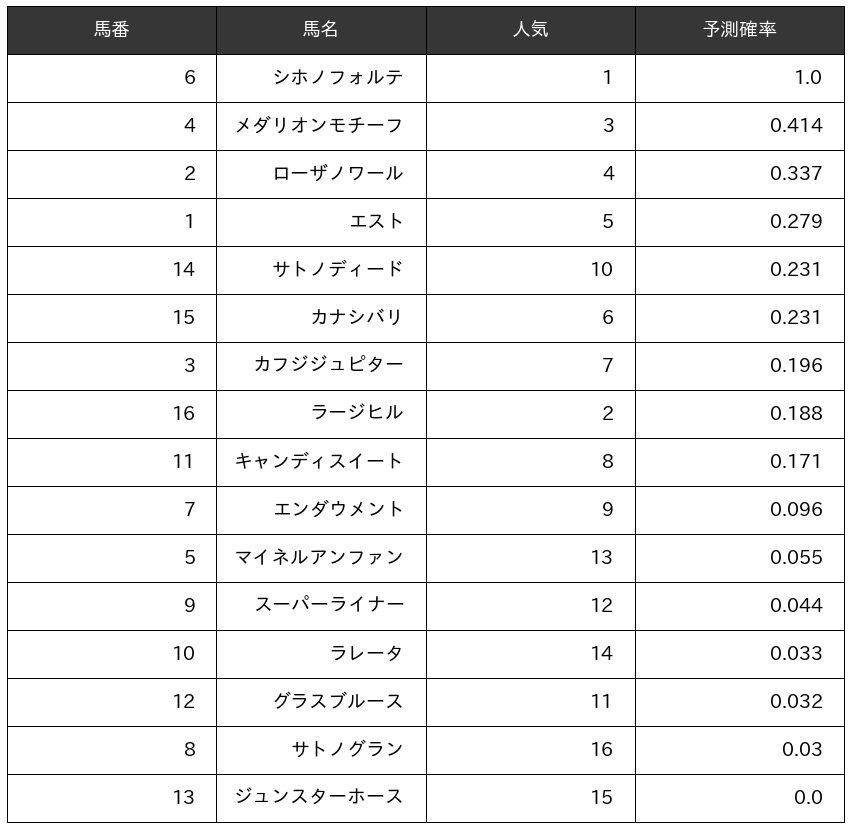

In [1526]:
print(Today_results_all['race_cat'].iloc[0])
print(Today_results_all['race_name'].iloc[0])
print('0.5以上頭数=',len(rank_pdf[rank_pdf['予測確率(単勝オッズなし)'] > 0.5]))
rank_pdf
rank_pdf12

import japanize_matplotlib
tweet_df  = rank_pdf[['馬番','馬名','人気','予測確率(単勝オッズなし)','正規化予測確率(単勝オッズなし)']].round(3).sort_values('予測確率(単勝オッズなし)', ascending=False)
tweet_df  = rank_pdf[['馬番','馬名','人気','正規化予測確率(単勝オッズなし)']].round(3).sort_values('正規化予測確率(単勝オッズなし)', ascending=False)
tweet_df = tweet_df.rename(columns={'正規化予測確率(単勝オッズなし)':'予測確率'})

#mpl.rcParams['font.family'] = 'AppleGothic'
#mpl.rcParams['font.family'] = 'sans-serif'
#plt.rcParams["font.family"] = "IPAexGothic"
plt.rcParams["font.size"] = 40
plt.tight_layout()

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
ax.axis('tight')
tb = ax.table(cellText=tweet_df.values,
         colLabels=tweet_df.columns,
         loc='center',
         bbox=[0,0,1,1]
        )
#tb[:, 0].set_facecolor('#363636')
tb[0, 0].set_facecolor('#363636')
tb[0, 1].set_facecolor('#363636')
tb[0, 2].set_facecolor('#363636')
tb[0, 3].set_facecolor('#363636')
#tb[0, 4].set_facecolor('#363636')

#tb[:, 0].set_text_props(color='w')
tb[0, 0].set_text_props(color='w')
tb[0, 1].set_text_props(color='w')
tb[0, 2].set_text_props(color='w')
tb[0, 3].set_text_props(color='w')
#tb[0, 4].set_text_props(color='w')
plt.savefig('table.jpeg')

<Figure size 432x288 with 0 Axes>

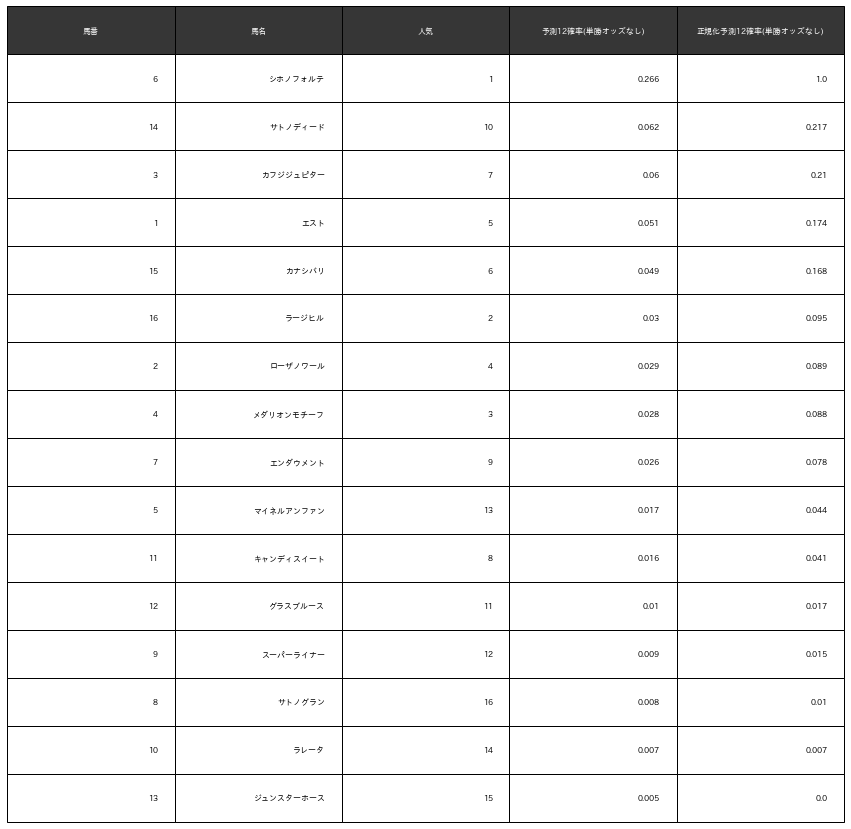

In [1527]:
tweet_df12  = rank_pdf12[['馬番','馬名','人気','予測12確率(単勝オッズなし)','正規化予測12確率(単勝オッズなし)']].round(3).sort_values('予測12確率(単勝オッズなし)', ascending=False)

#mpl.rcParams['font.family'] = 'AppleGothic'
#mpl.rcParams['font.family'] = 'sans-serif'
#plt.rcParams["font.family"] = "IPAexGothic"
plt.rcParams["font.size"] = 40
plt.tight_layout()

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
ax.axis('tight')
tb = ax.table(cellText=tweet_df12.values,
         colLabels=tweet_df12.columns,
         loc='center',
         bbox=[0,0,1,1]
        )
#tb[:, 0].set_facecolor('#363636')
tb[0, 0].set_facecolor('#363636')
tb[0, 1].set_facecolor('#363636')
tb[0, 2].set_facecolor('#363636')
tb[0, 3].set_facecolor('#363636')
tb[0, 4].set_facecolor('#363636')

#tb[:, 0].set_text_props(color='w')
tb[0, 0].set_text_props(color='w')
tb[0, 1].set_text_props(color='w')
tb[0, 2].set_text_props(color='w')
tb[0, 3].set_text_props(color='w')
tb[0, 4].set_text_props(color='w')
#plt.savefig('table.jpeg')

In [1428]:
#day = Today_result['date'].iloc[0].strftime('%Y年%m月%d日')
day = Today_result['date'].iloc[0]
place = Today_result['place'].iloc[0]
race_name = Today_result['race_name'].iloc[0]

# Twitterオブジェクトの生成
auth = tweepy.OAuthHandler(CK, CS)
auth.set_access_token(AT, AS)

api = tweepy.API(auth)
text = day + '\n' + place + race_name + '\n' + '#競馬予想 #競馬AI'
#画像付きツイート
if Today_result['place'].iloc[0] == '中山':
    api.update_with_media(status = text, filename = 'table.jpeg')
    print('画像付きpost OK')
else:
     print('ツイートせず')   
    
print(text)

画像付きpost OK
2020年10月4日
中山スプリンターズS
#競馬予想 #競馬AI


In [1427]:
import tweepy

# 先ほど取得した各種キーを代入する
CK="p3NhJPkB3Op678214B2ubtijd"
CS="1oGCIR8P7MO6OPytY9Az2EoqZg1E8oEDQrmGAcpkzBwFIDbxS5"
AT="1588559436-OhNXXbcQSQ1OM9S13f6HxKPO2JUkWAHb8z9nDUH"
AS="dy9JQjlOoXjA9ABNycoqIzJO0IxSIzpIBTHm5dFTafYfP"

In [1866]:
# Twitterオブジェクトの生成
auth = tweepy.OAuthHandler(CK, CS)
auth.set_access_token(AT, AS)
api = tweepy.API(auth)

# 好きな言葉をツイート
api.update_status("test投稿")
print('post OK')

post OK


access_token = "1588559436-OhNXXbcQSQ1OM9S13f6HxKPO2JUkWAHb8z9nDUH"
access_token_secret = "dy9JQjlOoXjA9ABNycoqIzJO0IxSIzpIBTHm5dFTafYfP"
api_key = "p3NhJPkB3Op678214B2ubtijd"
api_secret = "1oGCIR8P7MO6OPytY9Az2EoqZg1E8oEDQrmGAcpkzBwFIDbxS5"